In [1]:
import numpy as np
import matplotlib.pyplot as plt
import yt
from astropy.constants import G
import astropy.units as u
import seaborn as sns
from tqdm import tqdm

In [2]:
def search_closest_upper(value, array):
    diff = array - value
    return np.where(diff >= 0)[0][0]

In [3]:
ray_tree = np.load('/scratch/bbvl/gtg115x/new_zoom_5/box_2_z_1/halotree_1088_final_Thinh_structure.npy', allow_pickle=True).tolist()
apx_tree = np.load('/scratch/bbvl/gtg115x/new_zoom_5/box_2_z_1_no-shield/box_2_z_1_no-shield_run2/halotree_1088_final_Thinh_structure.npy', allow_pickle=True).tolist()

In [3]:
ray_pfs = np.loadtxt('/scratch/bbvl/gtg115x/new_zoom_5/box_2_z_1/pfs_allsnaps_1088.txt', dtype=str).tolist()
apx_pfs = np.loadtxt('/scratch/bbvl/gtg115x/new_zoom_5/box_2_z_1_no-shield/box_2_z_1_no-shield_run2/pfs_allsnaps_1088.txt', dtype=str).tolist()

In [5]:
ray_rawtree = np.load('/scratch/bbvl/gtg115x/new_zoom_5/box_2_z_1/halotree_1088_final.npy', allow_pickle=True).tolist()
#apx_rawtree = np.load('/scratch/bbvl/gtg115x/new_zoom_5/box_2_z_1_no-shield/box_2_z_1_no-shield_run2/halotree_1088_final.npy', allow_pickle=True).tolist()

In [4]:
time_list = np.array([ray_tree['0'][key]['time'] for key in ray_tree['0'].keys()])
idx_list = np.array([int(key) for key in ray_tree['0'].keys()])

In [5]:
ray_halo_wstars = {}
apx_halo_wstars = {}

In [7]:
idx = '170'

ray_halo_wstars_pos = np.empty(shape=(0,3))
ray_halo_wstars_rvir = np.array([])
ray_halo_wstars_branch = np.array([])
#ray_halo_wstars_dmmass = np.empty(shape=(0,1))

for key, vals in ray_tree.items():
    if idx in vals.keys() and vals[idx]['star_mass'] > 1:
        ray_halo_wstars[key] = vals[idx]
        ray_halo_wstars_pos = np.vstack((ray_halo_wstars_pos, vals[idx]['coor']))
        ray_halo_wstars_rvir = np.append(ray_halo_wstars_rvir, vals[idx]['Rvir'])
        ray_halo_wstars_branch = np.append(ray_halo_wstars_branch, key)
        
for key, vals in apx_tree.items():
    if idx in vals.keys() and vals[idx]['star_mass'] > 1:
        apx_halo_wstars[key] = vals[idx]

In [8]:
#Locate the overlapping halos. 
#For these halos, the stellar mass from the Thinh_structure file can be double counted. Therefore, we need to uniquely assign stars to each halo rather than loading the whole yt region.
overlap_pair = []
for i in range(len(ray_halo_wstars_branch)):
    for j in range(len(ray_halo_wstars_branch)):
        if (i == j) or sorted([ray_halo_wstars_branch[i],ray_halo_wstars_branch[j]]) in overlap_pair:
            continue
        else:
            if np.linalg.norm(ray_halo_wstars_pos[i] - ray_halo_wstars_pos[j]) < (ray_halo_wstars_rvir[i] + ray_halo_wstars_rvir[j]): #overlapping condition
                overlap_pair.append(sorted([ray_halo_wstars_branch[i],ray_halo_wstars_branch[j]]))

overlap_group = []
for pair in overlap_pair:
    if pair == overlap_pair[0]:
        group = pair
    else:
        if (pair[0] in group) or (pair[1] in group):
            group = list(set(group + pair))
        else:
            overlap_group.append(group)
            group = pair

In [9]:
#These are the groups of halos that need to be disentangled in terms of stellar mass
overlap_group

[['0_20', '0_21', '0', '0_16', '0_18', '0_19', '0_4', '0_2'],
 ['1', '1_14', '1_10'],
 ['3_1', '3', '3_7'],
 ['5', '5_1']]

In [76]:
ray_metadata = np.load('/work/hdd/bbvl/gtg115x/new_zoom_5/box_2_z_1/star_metadata/star_metadata_allbox_%s.npy' % idx, allow_pickle=True).tolist()
ray_pos_all = ray_metadata['pos']
ray_age_all = ray_metadata['age']
ray_ID_all = np.array(np.load('/work/hdd/bbvl/gtg115x/new_zoom_5/box_2_z_1/star_metadata/star_ID_allbox_%s.npy' % idx, allow_pickle=True).tolist())
ray_vel_all = np.array(np.load('/work/hdd/bbvl/gtg115x/new_zoom_5/box_2_z_1/star_metadata/star_vel_allbox_%s.npy' % idx, allow_pickle=True).tolist()['vel'])

In [79]:
group_test = np.array(overlap_group[0])
group_velcom = np.array([ray_rawtree[group_i][int(idx)]['Vel_Com'] for group_i in group_test])
#convert the unit of halo velocity from code_length/s to km/s
ds = yt.load(ray_pfs[int(idx)])
group_velcom = (group_velcom*ds.units.code_length/ds.units.s).to('km/s').v
group_starID = {}
allstars = []
for halo in group_test:
    halo_center = ray_tree[halo][idx]['coor']
    halo_radius = ray_tree[halo][idx]['Rvir']
    boolean = np.linalg.norm(ray_pos_all - halo_center, axis=1) < halo_radius
    group_starID[halo] = ray_ID_all[boolean].astype(int)
    allstars = list(set(allstars + list(ray_ID_all[boolean].astype(int))))
allstars = np.array(group_allstars)

yt : [INFO     ] 2024-12-10 10:23:52,751 Parameters: current_time              = 19.025726364245
yt : [INFO     ] 2024-12-10 10:23:52,752 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2024-12-10 10:23:52,754 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2024-12-10 10:23:52,762 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2024-12-10 10:23:52,765 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2024-12-10 10:23:52,768 Parameters: current_redshift          = 11.378797765779
yt : [INFO     ] 2024-12-10 10:23:52,770 Parameters: omega_lambda              = 0.6935
yt : [INFO     ] 2024-12-10 10:23:52,773 Parameters: omega_matter              = 0.3065
yt : [INFO     ] 2024-12-10 10:23:52,774 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2024-12-10 10:23:52,774 Parameters: hubble_constant           = 0.679


In [32]:
group_starID

{'0_20': array([65363538, 65364102, 65364638, 65364670, 65364748]),
 '0_21': array([65731297, 65734353, 65734354, 65734355, 65734356, 65734357,
        65734358, 65734359, 65734360, 65734362, 65734363, 65734364,
        65734366]),
 '0': array([65363541, 65363542, 65364086, ..., 65665931, 65665937, 65724384]),
 '0_16': array([65363537, 65363546, 65363851, ..., 65665931, 65665937, 65724384]),
 '0_18': array([65363541, 65363542, 65364086, 65364088, 65364194, 65364698,
        65364664, 65364679, 65364681, 65614185, 65614414, 65617205,
        65659343, 65363652, 65363539, 65363540, 65363665, 65363673,
        65363674, 65363767, 65363773]),
 '0_19': array([65363541, 65363542, 65364086, 65364113, 65364693, 65364695,
        65364700, 65363652, 65363826, 65363539, 65363540, 65363665,
        65363673, 65363683, 65363767, 65363773, 65363831, 65364106]),
 '0_4': array([65364088, 65364194, 65364127, 65364129]),
 '0_2': array([65731297, 65734353, 65734354, 65734355, 65734356, 65734357,
       

In [33]:
allstars

array([65732608, 65658881, 65658882, ..., 65363965, 65724414, 65732607])

In [46]:
count_list = {}
for ID in allstars:
    count = 0
    branch_overlap = []
    for branch in group_starID.keys():
        if ID in group_starID[branch]:
            count += 1
            branch_overlap.append(branch)
    if count > 1:
        count_list[ID] = [count, branch_overlap]

In [85]:
ray_vel_all[ray_ID_all == 65732608]

array([[-65.81759841,  12.10400267, 120.21314368]])

In [90]:
ray_rawtree['0'][171]

{'NumParts': 10324,
 'Halo_Mass': 7628372984.201647,
 'Halo_Radius': 0.003219896406693052,
 'cden': 202.11934833096655,
 'r100': 0.0038463181360783145,
 'r150': 0.0036909953190874156,
 'r200': 0.003237456954225626,
 'r250': 0.0028894798550874417,
 'r300': 0.0026477752928777674,
 'r500': 0.0020518783497319,
 'r700': 0.001687430599046631,
 'Halo_Center': array([0.49444511, 0.50351903, 0.51216658]),
 'Vel_Com': array([-7.90055792e-19, -4.80827245e-20,  1.03378648e-19])}

In [86]:
count_list[65732608]

[2, ['0', '0_16']]

In [88]:
group_velcom[group_test == '0']

array([[-35.6028203 ,  -4.23333669,  10.90924301]])

In [89]:
group_velcom[group_test == '0_16']

array([[  8.91740217, -44.69326534,  60.8857723 ]])

In [65]:
group_test

['0_20', '0_21', '0_4', '0_16', '0', '0_18', '0_19', '0_2']

In [14]:
ray_pos_all.shape

(30056, 3)

In [17]:
ray_halo_wstars_pos

array([[0.49420246, 0.50316925, 0.51266823],
       [0.49296721, 0.50155015, 0.51324955],
       [0.47673882, 0.50389487, 0.5022506 ],
       [0.48908694, 0.50969391, 0.50063493],
       [0.50191681, 0.51200992, 0.53478709],
       [0.50191068, 0.51098171, 0.53401179],
       [0.50015472, 0.49932791, 0.512181  ],
       [0.48527808, 0.4967556 , 0.51121502],
       [0.50025661, 0.50790924, 0.53018027],
       [0.49264434, 0.51777617, 0.49249299],
       [0.48658425, 0.52111066, 0.52580045],
       [0.5022803 , 0.51522828, 0.53829083],
       [0.50312778, 0.51599952, 0.53952004]])

In [21]:
ray_halo_wstars.keys()

dict_keys(['0', '0_2', '1', '3', '4', '4_0', '5', '6', '8', '9', '18', '20', '69'])

In [22]:
ray_halo_wstars['0_2']

{'tree_loc': '0_2',
 'coor': array([0.49296721, 0.50155015, 0.51324955]),
 'Rvir': 0.0014047493591527603,
 'redshift': 10.886019680253,
 'time': 0.42308436376385633,
 'gas_mass': 170519124.77518892,
 'gas_mass_frac': 0.12780071866170767,
 'h2_mass': 5220394.575481022,
 'h2_fraction': 0.030614715987802243,
 'dm_mass': 1162249229.1687708,
 'pop2_mass': 1489589.9787338013,
 'pop3_mass': 5.17818883535532,
 'star_mass': 1489595.1569226366,
 'metal_mass': 14570.536272090665,
 'metallicity': 8.544810613648377e-05,
 'sfr': 0.0,
 'total_mass': 1334257949.1008823}

We need to assign each star to a unique halo. This can be done by tracking back the star's position when it first forms to see if it forms inside the same halo

In [8]:
ray_halo_idx = '0'
ray_halo_center = ray_tree[ray_halo_idx][idx]['coor']
ray_halo_rvir = ray_tree[ray_halo_idx][idx]['Rvir']

In [9]:
ray_metadata = np.load('/work/hdd/bbvl/gtg115x/new_zoom_5/box_2_z_1/star_metadata/star_metadata_allbox_%s.npy' % idx, allow_pickle=True).tolist()
ray_pos_all = ray_metadata['pos']
ray_age_all = ray_metadata['age']
ray_ID_all = np.array(np.load('/work/hdd/bbvl/gtg115x/new_zoom_5/box_2_z_1/star_metadata/star_ID_allbox_%s.npy' % idx, allow_pickle=True).tolist())

In [10]:
halo_star_pos = ray_pos_all[np.linalg.norm(ray_pos_all - ray_halo_center, axis=1) < ray_halo_rvir]
halo_star_age = ray_age_all[np.linalg.norm(ray_pos_all - ray_halo_center, axis=1) < ray_halo_rvir]
halo_star_ID = ray_ID_all[np.linalg.norm(ray_pos_all - ray_halo_center, axis=1) < ray_halo_rvir]

In [15]:
ftime_dict = {}
for j in range(len(halo_star_age)):
    ftime = time_list[-1] - halo_star_age[j]
    ftime_snapidx = idx_list[search_closest_upper(ftime, time_list)]
    try:
        ftime_dict[ftime_snapidx].append(int(halo_star_ID[j]))
    except:
        ftime_dict[ftime_snapidx] = []
        ftime_dict[ftime_snapidx].append(int(halo_star_ID[j]))

In [18]:
ftime_dict.keys()

dict_keys([80, 95, 117, 122, 124, 125, 154, 158, 159, 176, 190, 193, 194, 195, 201, 203, 130, 79, 156, 163, 198, 199, 114, 118, 200, 99, 109, 111, 112, 116, 119, 120, 121, 123, 127, 129, 131, 133, 134, 137, 138, 139, 141, 142, 143, 144, 160, 161, 175, 184, 202, 126, 150, 152, 162, 164, 169, 170, 174, 177, 178, 179, 183, 187, 191, 192, 204, 165, 180, 205, 206, 207, 208, 182, 209, 210, 211])

### Star Assignment Technique by Thinh

Starting from the earlier snapshot to the later snapshot. If a star particle is formed in a halo, assume that it will not escape that halo (there is a chance that during fly by, a DM halo can still some star particles, but since we are investigating star formation in halo, this can be neglected). If that halo is a sub branch, the star particle will belong to the main branch at the time step of merging. If a star particle is formed between the region of multiple halos, use energy definition to determine which halo it belongs to (choose the halo in which the star particle has the lowest total energy)

In [4]:
output = {}
for idx in range(21, 212):
    output[str(idx)] = {}

In [5]:
def list_of_halos_wstars_idx(tree, idx):
    halo_wstars_pos = np.empty(shape=(0,3))
    halo_wstars_rvir = np.array([])
    halo_wstars_branch = np.array([])
    for key, vals in tree.items():
        if idx in vals.keys() and vals[idx]['star_mass'] > 1:
            halo_wstars_pos = np.vstack((halo_wstars_pos, vals[idx]['coor']))
            halo_wstars_rvir = np.append(halo_wstars_rvir, vals[idx]['Rvir'])
            halo_wstars_branch = np.append(halo_wstars_branch, key)   
    return halo_wstars_pos, halo_wstars_rvir, halo_wstars_branch

In [6]:
#In a case where one particle belongs to multiple halos, this code assigns that star to a specific halo
def univDen(ds):
    # Hubble constant
    H0 = ds.hubble_constant * 100 * u.km/u.s/u.Mpc
    H = H0**2 * (ds.omega_matter*(1 + ds.current_redshift)**3 + ds.omega_lambda)  # Technically H^2
    G = 6.67e-11 * u.m**3/u.s**2/u.kg
    # Density of the universe
    den = (3*H/(8*np.pi*G)).to("kg/m**3") / u.kg * u.m**3
    return den.value

def extract_char_radius(tree, branch, idx):
    oden_list = np.array([100, 150, 200, 250, 300, 500, 700])
    char_radius_list = np.array([])
    for oden in oden_list:
        key = 'r%s' % oden
        char_radius_list = np.append(char_radius_list, tree[branch][idx][key])
    return oden_list, char_radius_list

def find_total_E(star_pos, star_vel, ds, tree, branch, idx):
    #this function calculate the total orbital energy of a star around a halo
    #the unit of position is code_length and the unit of velocity is code_length/s
    star_r_codelength = np.linalg.norm(star_pos - tree[branch][idx]['Halo_Center'])
    star_r = (star_r_codelength*ds.units.code_length).to('m').v
    #
    halo_vel = (tree[branch][idx]['Vel_Com']*ds.units.code_length/ds.units.s).to('m/s').v
    star_relvel_mag = np.linalg.norm(star_vel - halo_vel)
    #Kinetic energy
    KE = 0.5*star_relvel_mag**2
    #Approximate M(r < star_r) by using the overdensity
    oden_list, char_radius_list = extract_char_radius(tree, branch, idx)
    char_radius_list = (char_radius_list*ds.units.code_length).to('m').v
    oden = oden_list[char_radius_list > star_r][-1]
    M = (4/3)*np.pi*oden*univDen(ds)*star_r**3
    PE = -G.value*M/star_r
    E = KE + PE
    return E

"""
def find_total_E_multiple(star_pos, star_vel, ds, tree, branch, idx):
    #this function calculate the total orbital energy of a star around a halo
    #the unit of position is km and the unit of velocity is km/s
    #star_pos is an array of stellar positions, star_vel is an array of stellar velocity
    star_r_codelength = np.linalg.norm(star_pos - tree[branch][idx]['Halo_Center'], axis=1)
    star_r = (star_r_codelength*ds.units.code_length).to('m').v
    #
    halo_vel = (tree[branch][idx]['Vel_Com']*ds.units.code_length/ds.units.s).to('m/s').v
    star_relvel_mag = np.linalg.norm(star_vel - halo_vel, axis=1)
    #Kinetic energy
    KE = 0.5*star_relvel_mag**2
    #Approximate M(r < star_r) by using the overdensity
    oden_list, char_radius_list = extract_char_radius(tree, branch, idx)
    char_radius_list = (char_radius_list*ds.units.code_length).to('m').v
    oden_boolean = char_radius_list > star_r[:,np.newaxis]
    oden = np.array([])
    for j in range(len(oden_boolean)):
        oden = np.append(oden, oden_list[np.where(oden_boolean[j] == True)[0][-1]])
    #
    M = (4/3)*np.pi*oden*univDen(ds)*star_r**3
    PE = -G.value*M/star_r
    E = KE + PE
    return E
"""

"\ndef find_total_E_multiple(star_pos, star_vel, ds, tree, branch, idx):\n    #this function calculate the total orbital energy of a star around a halo\n    #the unit of position is km and the unit of velocity is km/s\n    #star_pos is an array of stellar positions, star_vel is an array of stellar velocity\n    star_r_codelength = np.linalg.norm(star_pos - tree[branch][idx]['Halo_Center'], axis=1)\n    star_r = (star_r_codelength*ds.units.code_length).to('m').v\n    #\n    halo_vel = (tree[branch][idx]['Vel_Com']*ds.units.code_length/ds.units.s).to('m/s').v\n    star_relvel_mag = np.linalg.norm(star_vel - halo_vel, axis=1)\n    #Kinetic energy\n    KE = 0.5*star_relvel_mag**2\n    #Approximate M(r < star_r) by using the overdensity\n    oden_list, char_radius_list = extract_char_radius(tree, branch, idx)\n    char_radius_list = (char_radius_list*ds.units.code_length).to('m').v\n    oden_boolean = char_radius_list > star_r[:,np.newaxis]\n    oden = np.array([])\n    for j in range(len(o

In [7]:
ray_tree = np.load('/scratch/bbvl/gtg115x/new_zoom_5/box_2_z_1/halotree_1088_final_Thinh_structure.npy', allow_pickle=True).tolist()
ray_rawtree = np.load('/scratch/bbvl/gtg115x/new_zoom_5/box_2_z_1/halotree_1088_final.npy', allow_pickle=True).tolist()

In [9]:
'1_2_0'.count('_')

2

In [27]:
print_mode = True

for idx in tqdm(range(21, 212)):
    idx = str(idx)
    #
    ray_metadata = np.load('/work/hdd/bbvl/gtg115x/new_zoom_5/box_2_z_1/star_metadata/star_metadata_allbox_%s.npy' % idx, allow_pickle=True).tolist()
    ray_pos_all = ray_metadata['pos']
    ray_age_all = ray_metadata['age']
    ray_mass_all = ray_metadata['mass']
    ray_ID_all = np.array(np.load('/work/hdd/bbvl/gtg115x/new_zoom_5/box_2_z_1/star_metadata/star_ID_allbox_%s.npy' % idx, allow_pickle=True).tolist()).astype(int)
    ray_vel_all = np.array(np.load('/work/hdd/bbvl/gtg115x/new_zoom_5/box_2_z_1/star_metadata/star_vel_allbox_%s.npy' % idx, allow_pickle=True).tolist()['vel'])
    #
    if idx == '21':
        ray_ID_all_prev = np.array([])
    #
    ray_ID_unassign = np.setdiff1d(ray_ID_all, ray_ID_all_prev)
    ray_pos_unassign = ray_pos_all[np.intersect1d(ray_ID_all, ray_ID_unassign, return_indices=True)[1]]
    ray_vel_unassign = ray_vel_all[np.intersect1d(ray_ID_all, ray_ID_unassign, return_indices=True)[1]]
    #Obtain the halos with stars
    halo_wstars_pos, halo_wstars_rvir, halo_wstars_branch = list_of_halos_wstars_idx(ray_tree, idx)
    #
    #The shape of halo_boolean is (X,Y), where X is the number of star particles and Y is the number of halos with stars
    halo_boolean = np.linalg.norm(ray_pos_unassign[:, np.newaxis, :] - halo_wstars_pos, axis=2) <= halo_wstars_rvir
    #The number of halos a star particle is in. For example, if this value = 2, the star particle is in the region of 2 halos
    overlap_boolean = np.sum(halo_boolean, axis=1) 
    #
    ray_ID_overlap = ray_ID_unassign[overlap_boolean > 1]
    halo_boolean_overlap = halo_boolean[overlap_boolean > 1]
    ray_ID_indp = ray_ID_unassign[overlap_boolean == 1]
    halo_boolean_indp = halo_boolean[overlap_boolean == 1]
    #
    #The list of stars in each halo's region
    starmap_ID = []
    for j in range(halo_boolean_indp.shape[1]):
        starmap_ID.append(ray_ID_indp[halo_boolean_indp[:,j]])
    #
    if len(ray_ID_overlap) > 0:
        ds = yt.load(ray_pfs[int(idx)])
        ray_pos_overlap = ray_pos_unassign[overlap_boolean > 1]
        ray_vel_overlap = ray_vel_unassign[overlap_boolean > 1]
        overlap_branch_total = []
        for k in range(len(ray_ID_overlap)):
            overlap_branch = halo_wstars_branch[halo_boolean_overlap[k]]
            E_list = np.array([])
            for branch in overlap_branch:
                overlap_branch_total.append(branch)
                E = find_total_E(ray_pos_overlap[k], ray_vel_overlap[k], ds, ray_rawtree, branch, int(idx))
                E_list = np.append(E_list, E)
            bound_branch = overlap_branch[np.argmin(E_list)]
            #print('Star ID', ray_ID_overlap[k], 'belong to Branch', bound_branch)
            starmap_ID[list(halo_wstars_branch).index(bound_branch)] = np.append(starmap_ID[list(halo_wstars_branch).index(bound_branch)], ray_ID_overlap[k])
        print('OVERLAP DETECTED AT BRANCHES', set(overlap_branch_total))
    len_starmap = [len(i) for i in starmap_ID]
    #
    for i in range(len(halo_wstars_branch)):
        if len(starmap_ID[i]) > 0: 
            for j in ray_tree[halo_wstars_branch[i]].keys(): #assuming when a star forms inside a halo, it will not leave that halo 
                if int(j) >= int(idx):
                    if halo_wstars_branch[i] not in output[j].keys():
                        output[j][halo_wstars_branch[i]] = starmap_ID[i]
                    else:
                        output[j][halo_wstars_branch[i]] = np.append(output[j][halo_wstars_branch[i]], starmap_ID[i])
            if '_' in halo_wstars_branch[i]: #for subbranch, the stars in the sub-branch will belong to the main branch after the two halos merge
                mainbranch = halo_wstars_branch[i].split('_')[0]
                merge_timestep = np.max(np.array(list(ray_tree[halo_wstars_branch[i]].keys())).astype(int)) + 1
                last_timestep = np.max(np.array(list(ray_tree['0'].keys())).astype(int))
                for j in range(merge_timestep, last_timestep + 1):
                    if mainbranch not in output[str(j)].keys():
                        output[str(j)][mainbranch] = starmap_ID[i]
                    else:
                        output[str(j)][mainbranch] = np.append(output[str(j)][mainbranch], starmap_ID[i])
                
    #
    ray_ID_all_prev = ray_ID_all
    #
    if print_mode == True:
        print(idx, 'Number of total unassigned stars is:', len(ray_ID_unassign))
        print('Number of overlapped stars is', len(ray_ID_overlap), ', Number of independent stars is', len(ray_ID_indp))
        print('Halo with stars:', halo_wstars_branch)
        print('Number of assingned stars in each halo:', len_starmap)
        print(starmap_ID,'\n')

 24%|██▎       | 45/191 [00:00<00:00, 230.15it/s]

21 Number of total unassigned stars is: 4
Number of overlapped stars is 0 , Number of independent stars is 4
Halo with stars: ['1']
Number of assingned stars in each halo: [4]
[array([65333248, 65333864, 65333953, 65333965])] 

22 Number of total unassigned stars is: 0
Number of overlapped stars is 0 , Number of independent stars is 0
Halo with stars: ['1']
Number of assingned stars in each halo: [0]
[array([], dtype=int64)] 

23 Number of total unassigned stars is: 0
Number of overlapped stars is 0 , Number of independent stars is 0
Halo with stars: ['1']
Number of assingned stars in each halo: [0]
[array([], dtype=int64)] 

24 Number of total unassigned stars is: 186
Number of overlapped stars is 0 , Number of independent stars is 186
Halo with stars: ['1']
Number of assingned stars in each halo: [186]
[array([65333966, 65333967, 65333969, 65333970, 65333971, 65333972,
       65333973, 65333974, 65333975, 65333976, 65333977, 65333980,
       65333981, 65333982, 65333983, 65333984, 65

 37%|███▋      | 70/191 [00:00<00:00, 235.36it/s]yt : [INFO     ] 2025-01-02 04:09:38,275 Parameters: current_time              = 14.485372364245
yt : [INFO     ] 2025-01-02 04:09:38,277 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2025-01-02 04:09:38,278 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-01-02 04:09:38,280 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2025-01-02 04:09:38,281 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2025-01-02 04:09:38,282 Parameters: current_redshift          = 13.847170857863
yt : [INFO     ] 2025-01-02 04:09:38,284 Parameters: omega_lambda              = 0.6935
yt : [INFO     ] 2025-01-02 04:09:38,285 Parameters: omega_matter              = 0.3065
yt : [INFO     ] 2025-01-02 04:09:38,286 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-01-02 04:09:38,288 Parameters: hubble_constant           = 0.679


67 Number of total unassigned stars is: 0
Number of overlapped stars is 0 , Number of independent stars is 0
Halo with stars: ['1' '7']
Number of assingned stars in each halo: [0, 0]
[array([], dtype=int64), array([], dtype=int64)] 

68 Number of total unassigned stars is: 0
Number of overlapped stars is 0 , Number of independent stars is 0
Halo with stars: ['1' '7']
Number of assingned stars in each halo: [0, 0]
[array([], dtype=int64), array([], dtype=int64)] 

69 Number of total unassigned stars is: 0
Number of overlapped stars is 0 , Number of independent stars is 0
Halo with stars: ['1' '7']
Number of assingned stars in each halo: [0, 0]
[array([], dtype=int64), array([], dtype=int64)] 

70 Number of total unassigned stars is: 0
Number of overlapped stars is 0 , Number of independent stars is 0
Halo with stars: ['1' '7']
Number of assingned stars in each halo: [0, 0]
[array([], dtype=int64), array([], dtype=int64)] 

71 Number of total unassigned stars is: 0
Number of overlapped s

yt : [INFO     ] 2025-01-02 04:09:38,414 Parameters: current_time              = 14.676545164245
yt : [INFO     ] 2025-01-02 04:09:38,416 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2025-01-02 04:09:38,417 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-01-02 04:09:38,419 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2025-01-02 04:09:38,420 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2025-01-02 04:09:38,422 Parameters: current_redshift          = 13.71792907663
yt : [INFO     ] 2025-01-02 04:09:38,423 Parameters: omega_lambda              = 0.6935
yt : [INFO     ] 2025-01-02 04:09:38,424 Parameters: omega_matter              = 0.3065
yt : [INFO     ] 2025-01-02 04:09:38,425 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-01-02 04:09:38,427 Parameters: hubble_constant           = 0.679


92 Number of total unassigned stars is: 0
Number of overlapped stars is 0 , Number of independent stars is 0
Halo with stars: ['0' '0_36' '0_34' '0_35' '1' '1_22']
Number of assingned stars in each halo: [0, 0, 0, 0, 0, 0]
[array([], dtype=int64), array([], dtype=int64), array([], dtype=int64), array([], dtype=int64), array([], dtype=int64), array([], dtype=int64)] 

93 Number of total unassigned stars is: 96
Number of overlapped stars is 0 , Number of independent stars is 96
Halo with stars: ['0' '0_36' '0_34' '0_35' '1']
Number of assingned stars in each halo: [0, 0, 0, 0, 96]
[array([], dtype=int64), array([], dtype=int64), array([], dtype=int64), array([], dtype=int64), array([65364492, 65364493, 65364494, 65364495, 65364496, 65364497,
       65364498, 65364500, 65364502, 65364503, 65364504, 65364505,
       65364508, 65364510, 65364511, 65364512, 65364513, 65364515,
       65364516, 65364517, 65364518, 65364520, 65364521, 65364522,
       65364523, 65364524, 65364525, 65364526, 65

yt : [INFO     ] 2025-01-02 04:09:38,633 Parameters: current_time              = 14.772131564245
yt : [INFO     ] 2025-01-02 04:09:38,634 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2025-01-02 04:09:38,636 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-01-02 04:09:38,637 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2025-01-02 04:09:38,639 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2025-01-02 04:09:38,640 Parameters: current_redshift          = 13.65435486334
yt : [INFO     ] 2025-01-02 04:09:38,641 Parameters: omega_lambda              = 0.6935
yt : [INFO     ] 2025-01-02 04:09:38,643 Parameters: omega_matter              = 0.3065
yt : [INFO     ] 2025-01-02 04:09:38,644 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-01-02 04:09:38,645 Parameters: hubble_constant           = 0.679
yt : [INFO     ] 2025-01-02 04:09:38,736 Parameters: current_time              = 14.819924764245


96 Number of total unassigned stars is: 40
Number of overlapped stars is 0 , Number of independent stars is 40
Halo with stars: ['0' '0_36' '0_34' '0_35' '1']
Number of assingned stars in each halo: [0, 0, 0, 0, 40]
[array([], dtype=int64), array([], dtype=int64), array([], dtype=int64), array([], dtype=int64), array([65364784, 65364785, 65364786, 65364787, 65364788, 65364789,
       65364790, 65364791, 65364792, 65364793, 65364794, 65364795,
       65364796, 65364797, 65364798, 65364799, 65364800, 65364801,
       65364802, 65364804, 65364805, 65364806, 65364807, 65364808,
       65364809, 65364810, 65364811, 65364812, 65364814, 65364815,
       65364816, 65364817, 65364818, 65364820, 65364822, 65364823,
       65364824, 65364825, 65364827, 65364828])] 

OVERLAP DETECTED AT BRANCHES {'6_6', '6'}
97 Number of total unassigned stars is: 14
Number of overlapped stars is 14 , Number of independent stars is 0
Halo with stars: ['0' '0_36' '0_34' '0_35' '0_30' '1' '6' '6_6']
Number of assing

yt : [INFO     ] 2025-01-02 04:09:38,843 Parameters: current_time              = 14.867717964245
yt : [INFO     ] 2025-01-02 04:09:38,845 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2025-01-02 04:09:38,846 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-01-02 04:09:38,848 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2025-01-02 04:09:38,849 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2025-01-02 04:09:38,850 Parameters: current_redshift          = 13.591462463737
yt : [INFO     ] 2025-01-02 04:09:38,852 Parameters: omega_lambda              = 0.6935
yt : [INFO     ] 2025-01-02 04:09:38,853 Parameters: omega_matter              = 0.3065
yt : [INFO     ] 2025-01-02 04:09:38,854 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-01-02 04:09:38,856 Parameters: hubble_constant           = 0.679
yt : [INFO     ] 2025-01-02 04:09:38,999 Parameters: current_time              = 14.915511164245

OVERLAP DETECTED AT BRANCHES {'0_34', '6_6', '0', '6', '0_35'}
99 Number of total unassigned stars is: 103
Number of overlapped stars is 38 , Number of independent stars is 65
Halo with stars: ['0' '0_33' '0_34' '0_35' '0_30' '1' '6' '6_6' '6_5']
Number of assingned stars in each halo: [37, 0, 0, 0, 0, 65, 1, 0, 0]
[array([65383937, 65383938, 65383939, 65383940, 65383941, 65383942,
       65383944, 65383945, 65383946, 65383947, 65383948, 65383949,
       65383950, 65383954, 65383955, 65383958, 65383959, 65383961,
       65383964, 65383966, 65383970, 65383972, 65383974, 65383975,
       65383982, 65383984, 65383986, 65383989, 65383993, 65383994,
       65383997, 65383998, 65383999, 65384000, 65384001, 65384002,
       65384003]), array([], dtype=int64), array([], dtype=int64), array([], dtype=int64), array([], dtype=int64), array([65383884, 65383885, 65383886, 65383887, 65383888, 65383889,
       65383890, 65383891, 65383892, 65383894, 65383895, 65383896,
       65383897, 65383899, 6538

yt : [INFO     ] 2025-01-02 04:09:39,138 Parameters: current_time              = 14.963304364245
yt : [INFO     ] 2025-01-02 04:09:39,141 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2025-01-02 04:09:39,142 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-01-02 04:09:39,143 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2025-01-02 04:09:39,145 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2025-01-02 04:09:39,146 Parameters: current_redshift          = 13.529240250548
yt : [INFO     ] 2025-01-02 04:09:39,147 Parameters: omega_lambda              = 0.6935
yt : [INFO     ] 2025-01-02 04:09:39,149 Parameters: omega_matter              = 0.3065
yt : [INFO     ] 2025-01-02 04:09:39,150 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-01-02 04:09:39,151 Parameters: hubble_constant           = 0.679
yt : [INFO     ] 2025-01-02 04:09:39,276 Parameters: current_time              = 15.011097564245

OVERLAP DETECTED AT BRANCHES {'6_5', '6'}
101 Number of total unassigned stars is: 72
Number of overlapped stars is 42 , Number of independent stars is 30
Halo with stars: ['0' '0_32' '0_33' '0_34' '0_30' '1' '6' '6_5']
Number of assingned stars in each halo: [0, 0, 0, 0, 0, 30, 42, 0]
[array([], dtype=int64), array([], dtype=int64), array([], dtype=int64), array([], dtype=int64), array([], dtype=int64), array([65443683, 65443744, 65471224, 65471225, 65471226, 65471227,
       65471228, 65471229, 65471231, 65471232, 65471234, 65471236,
       65471238, 65471240, 65471241, 65471242, 65471243, 65471244,
       65471246, 65471247, 65471249, 65471250, 65471251, 65471252,
       65471253, 65471254, 65471255, 65471256, 65471257, 65471258]), array([65440880, 65440909, 65440912, 65440915, 65441195, 65441462,
       65441888, 65442258, 65442550, 65442617, 65442621, 65442627,
       65442706, 65442846, 65443047, 65443309, 65443503, 65443896,
       65444599, 65444895, 65445221, 65445436, 6544629

yt : [INFO     ] 2025-01-02 04:09:39,451 Parameters: current_time              = 15.058890764245
yt : [INFO     ] 2025-01-02 04:09:39,453 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2025-01-02 04:09:39,454 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-01-02 04:09:39,456 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2025-01-02 04:09:39,457 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2025-01-02 04:09:39,458 Parameters: current_redshift          = 13.467676867405
yt : [INFO     ] 2025-01-02 04:09:39,460 Parameters: omega_lambda              = 0.6935
yt : [INFO     ] 2025-01-02 04:09:39,461 Parameters: omega_matter              = 0.3065
yt : [INFO     ] 2025-01-02 04:09:39,462 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-01-02 04:09:39,463 Parameters: hubble_constant           = 0.679
yt : [INFO     ] 2025-01-02 04:09:40,237 Parameters: current_time              = 15.441236364245

OVERLAP DETECTED AT BRANCHES {'6_5', '6'}
103 Number of total unassigned stars is: 598
Number of overlapped stars is 545 , Number of independent stars is 53
Halo with stars: ['0' '0_32' '0_33' '0_34' '0_30' '0_26' '1' '6' '6_5']
Number of assingned stars in each halo: [0, 0, 0, 0, 0, 0, 53, 545, 0]
[array([], dtype=int64), array([], dtype=int64), array([], dtype=int64), array([], dtype=int64), array([], dtype=int64), array([], dtype=int64), array([65609401, 65610304, 65610305, 65610306, 65610307, 65610308,
       65610309, 65610310, 65610311, 65610313, 65610315, 65610316,
       65610317, 65610319, 65610320, 65610321, 65610324, 65610326,
       65610327, 65610328, 65610329, 65610331, 65610332, 65610333,
       65610334, 65610335, 65610336, 65610337, 65610338, 65610339,
       65610341, 65610342, 65610343, 65610344, 65610345, 65610346,
       65610349, 65610350, 65610351, 65610352, 65610353, 65610355,
       65610356, 65610357, 65610360, 65610361, 65610362, 65610364,
       65610367, 65

yt : [INFO     ] 2025-01-02 04:09:40,434 Parameters: current_time              = 15.489029564245
yt : [INFO     ] 2025-01-02 04:09:40,436 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2025-01-02 04:09:40,437 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-01-02 04:09:40,439 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2025-01-02 04:09:40,440 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2025-01-02 04:09:40,441 Parameters: current_redshift          = 13.19850312348
yt : [INFO     ] 2025-01-02 04:09:40,443 Parameters: omega_lambda              = 0.6935
yt : [INFO     ] 2025-01-02 04:09:40,444 Parameters: omega_matter              = 0.3065
yt : [INFO     ] 2025-01-02 04:09:40,445 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-01-02 04:09:40,446 Parameters: hubble_constant           = 0.679
yt : [INFO     ] 2025-01-02 04:09:40,587 Parameters: current_time              = 15.584615964245


OVERLAP DETECTED AT BRANCHES {'0', '0_30'}
112 Number of total unassigned stars is: 189
Number of overlapped stars is 45 , Number of independent stars is 144
Halo with stars: ['0' '0_32' '0_27' '0_29' '0_30' '0_26' '1' '1_18' '6']
Number of assingned stars in each halo: [45, 0, 0, 0, 0, 0, 144, 0, 0]
[array([65612665, 65612666, 65612668, 65612669, 65612670, 65612671,
       65612672, 65612674, 65612676, 65612677, 65612679, 65612680,
       65612681, 65612682, 65612683, 65612686, 65612687, 65612688,
       65612690, 65612692, 65612693, 65612696, 65612698, 65612699,
       65612700, 65612701, 65612702, 65612703, 65612704, 65612706,
       65612707, 65612708, 65612709, 65612711, 65612713, 65612714,
       65612715, 65612716, 65612718, 65612719, 65612720, 65612721,
       65612722, 65612724, 65612727]), array([], dtype=int64), array([], dtype=int64), array([], dtype=int64), array([], dtype=int64), array([], dtype=int64), array([65612728, 65612729, 65612730, 65612731, 65612733, 65612734,
  

yt : [INFO     ] 2025-01-02 04:09:40,729 Parameters: current_time              = 15.632409164245
yt : [INFO     ] 2025-01-02 04:09:40,732 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2025-01-02 04:09:40,733 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-01-02 04:09:40,735 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2025-01-02 04:09:40,736 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2025-01-02 04:09:40,737 Parameters: current_redshift          = 13.111528223491
yt : [INFO     ] 2025-01-02 04:09:40,739 Parameters: omega_lambda              = 0.6935
yt : [INFO     ] 2025-01-02 04:09:40,740 Parameters: omega_matter              = 0.3065
yt : [INFO     ] 2025-01-02 04:09:40,741 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-01-02 04:09:40,742 Parameters: hubble_constant           = 0.679
yt : [INFO     ] 2025-01-02 04:09:40,865 Parameters: current_time              = 15.680202364245

OVERLAP DETECTED AT BRANCHES {'1_18', '1'}
115 Number of total unassigned stars is: 37
Number of overlapped stars is 37 , Number of independent stars is 0
Halo with stars: ['0' '0_27' '0_15' '0_29' '0_30' '0_26' '1' '1_18' '6']
Number of assingned stars in each halo: [0, 0, 0, 0, 0, 0, 37, 0, 0]
[array([], dtype=int64), array([], dtype=int64), array([], dtype=int64), array([], dtype=int64), array([], dtype=int64), array([], dtype=int64), array([65613517, 65613518, 65613519, 65613520, 65613521, 65613522,
       65613523, 65613524, 65613525, 65613527, 65613528, 65613529,
       65613530, 65613531, 65613532, 65613533, 65613534, 65613535,
       65613536, 65613537, 65613538, 65613539, 65613540, 65613542,
       65613543, 65613544, 65613546, 65613547, 65613548, 65613550,
       65613551, 65613552, 65613553, 65613554, 65613555, 65613556,
       65613557]), array([], dtype=int64), array([], dtype=int64)] 

OVERLAP DETECTED AT BRANCHES {'0', '0_30'}
116 Number of total unassigned stars is: 195

yt : [INFO     ] 2025-01-02 04:09:41,148 Parameters: current_time              = 15.727995564245
yt : [INFO     ] 2025-01-02 04:09:41,149 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2025-01-02 04:09:41,150 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-01-02 04:09:41,151 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2025-01-02 04:09:41,152 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2025-01-02 04:09:41,153 Parameters: current_redshift          = 13.054279821133
yt : [INFO     ] 2025-01-02 04:09:41,154 Parameters: omega_lambda              = 0.6935
yt : [INFO     ] 2025-01-02 04:09:41,155 Parameters: omega_matter              = 0.3065
yt : [INFO     ] 2025-01-02 04:09:41,156 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-01-02 04:09:41,157 Parameters: hubble_constant           = 0.679
yt : [INFO     ] 2025-01-02 04:09:41,635 Parameters: current_time              = 15.775788764245

OVERLAP DETECTED AT BRANCHES {'0', '0_30'}
117 Number of total unassigned stars is: 423
Number of overlapped stars is 423 , Number of independent stars is 0
Halo with stars: ['0' '0_27' '0_15' '0_29' '0_30' '0_26' '0_18_0' '1' '1_18' '6']
Number of assingned stars in each halo: [423, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[array([65613897, 65613899, 65613900, 65613901, 65613902, 65613903,
       65613904, 65613905, 65613906, 65613909, 65613910, 65613911,
       65613912, 65613913, 65613914, 65613915, 65613916, 65613917,
       65613919, 65613921, 65613922, 65613923, 65613924, 65613925,
       65613927, 65613928, 65613930, 65613931, 65613932, 65613933,
       65613934, 65613935, 65613936, 65613937, 65613938, 65613939,
       65613940, 65613941, 65613942, 65613943, 65613944, 65613945,
       65613946, 65613947, 65613949, 65613950, 65613951, 65613952,
       65613954, 65613955, 65613956, 65613957, 65613958, 65613959,
       65613960, 65613961, 65613962, 65613963, 65613964, 65613965,
       65613966, 

yt : [INFO     ] 2025-01-02 04:09:41,808 Parameters: current_time              = 15.823581964245
yt : [INFO     ] 2025-01-02 04:09:41,810 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2025-01-02 04:09:41,811 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-01-02 04:09:41,812 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2025-01-02 04:09:41,813 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2025-01-02 04:09:41,814 Parameters: current_redshift          = 12.997608249284
yt : [INFO     ] 2025-01-02 04:09:41,815 Parameters: omega_lambda              = 0.6935
yt : [INFO     ] 2025-01-02 04:09:41,816 Parameters: omega_matter              = 0.3065
yt : [INFO     ] 2025-01-02 04:09:41,817 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-01-02 04:09:41,818 Parameters: hubble_constant           = 0.679


OVERLAP DETECTED AT BRANCHES {'4', '0', '4_10', '0_30'}
119 Number of total unassigned stars is: 157
Number of overlapped stars is 137 , Number of independent stars is 20
Halo with stars: ['0' '0_27' '0_29' '0_30' '0_26' '0_18_0' '1' '1_18' '4' '4_10' '6']
Number of assingned stars in each halo: [133, 0, 0, 0, 0, 0, 0, 0, 4, 0, 20]
[array([65614828, 65614829, 65614830, 65614831, 65614832, 65614833,
       65614834, 65614836, 65614838, 65614840, 65614841, 65614842,
       65614843, 65614845, 65614846, 65614847, 65614849, 65614850,
       65614851, 65614852, 65614853, 65614855, 65614856, 65614857,
       65614858, 65614859, 65614861, 65614862, 65614863, 65614864,
       65614865, 65614866, 65614867, 65614893, 65614894, 65614895,
       65614896, 65615794, 65615894, 65616146, 65616217, 65616302,
       65616348, 65616420, 65616478, 65616598, 65616762, 65616778,
       65616900, 65616917, 65616971, 65617083, 65617085, 65617086,
       65617087, 65617090, 65617091, 65617093, 65617095, 65617

yt : [INFO     ] 2025-01-02 04:09:42,353 Parameters: current_time              = 15.871375164245
yt : [INFO     ] 2025-01-02 04:09:42,354 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2025-01-02 04:09:42,356 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-01-02 04:09:42,357 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2025-01-02 04:09:42,358 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2025-01-02 04:09:42,360 Parameters: current_redshift          = 12.969485877534
yt : [INFO     ] 2025-01-02 04:09:42,361 Parameters: omega_lambda              = 0.6935
yt : [INFO     ] 2025-01-02 04:09:42,363 Parameters: omega_matter              = 0.3065
yt : [INFO     ] 2025-01-02 04:09:42,364 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-01-02 04:09:42,365 Parameters: hubble_constant           = 0.679


OVERLAP DETECTED AT BRANCHES {'4', '0', '4_10', '0_30'}
120 Number of total unassigned stars is: 88
Number of overlapped stars is 88 , Number of independent stars is 0
Halo with stars: ['0' '0_27' '0_29' '0_30' '0_26' '0_18_0' '1' '1_18' '4' '4_10' '6']
Number of assingned stars in each halo: [86, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0]
[array([65617191, 65617192, 65617193, 65617194, 65617195, 65617196,
       65617197, 65617198, 65617199, 65617202, 65617203, 65617204,
       65617205, 65617206, 65617207, 65617209, 65617210, 65617211,
       65617212, 65617214, 65617215, 65617216, 65617217, 65617218,
       65617219, 65617220, 65617221, 65617222, 65617223, 65617224,
       65617225, 65617226, 65617227, 65617228, 65617229, 65617230,
       65617232, 65617234, 65617235, 65617236, 65617237, 65617238,
       65617241, 65617242, 65617247, 65617249, 65617250, 65617252,
       65617256, 65617257, 65617258, 65617259, 65617261, 65617263,
       65617264, 65617265, 65617267, 65617268, 65617270, 65617271,


yt : [INFO     ] 2025-01-02 04:09:42,788 Parameters: current_time              = 15.919168364245
yt : [INFO     ] 2025-01-02 04:09:42,789 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2025-01-02 04:09:42,791 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-01-02 04:09:42,792 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2025-01-02 04:09:42,794 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2025-01-02 04:09:42,795 Parameters: current_redshift          = 12.941504262223
yt : [INFO     ] 2025-01-02 04:09:42,796 Parameters: omega_lambda              = 0.6935
yt : [INFO     ] 2025-01-02 04:09:42,797 Parameters: omega_matter              = 0.3065
yt : [INFO     ] 2025-01-02 04:09:42,799 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-01-02 04:09:42,800 Parameters: hubble_constant           = 0.679


OVERLAP DETECTED AT BRANCHES {'4', '1_18', '4_10', '1'}
121 Number of total unassigned stars is: 85
Number of overlapped stars is 53 , Number of independent stars is 32
Halo with stars: ['0' '0_27' '0_29' '0_26' '0_18_0' '1' '1_18' '4' '4_10' '6']
Number of assingned stars in each halo: [11, 0, 0, 0, 0, 32, 0, 21, 0, 21]
[array([65652734, 65652849, 65652881, 65652889, 65653067, 65653120,
       65653232, 65653273, 65653707, 65653765, 65653944]), array([], dtype=int64), array([], dtype=int64), array([], dtype=int64), array([], dtype=int64), array([65657938, 65657939, 65657940, 65657941, 65657942, 65657943,
       65657944, 65657945, 65657946, 65657966, 65657973, 65657974,
       65657975, 65657976, 65657978, 65657979, 65657980, 65657981,
       65657982, 65657984, 65657985, 65657986, 65657988, 65657989,
       65657990, 65657991, 65657992, 65657993, 65657994, 65657995,
       65657996, 65657997]), array([], dtype=int64), array([65617792, 65618718, 65619962, 65624343, 65627324, 65630440,

yt : [INFO     ] 2025-01-02 04:09:43,493 Parameters: current_time              = 16.014754764245
yt : [INFO     ] 2025-01-02 04:09:43,494 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2025-01-02 04:09:43,496 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-01-02 04:09:43,497 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2025-01-02 04:09:43,498 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2025-01-02 04:09:43,500 Parameters: current_redshift          = 12.885958816771
yt : [INFO     ] 2025-01-02 04:09:43,501 Parameters: omega_lambda              = 0.6935
yt : [INFO     ] 2025-01-02 04:09:43,502 Parameters: omega_matter              = 0.3065
yt : [INFO     ] 2025-01-02 04:09:43,504 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-01-02 04:09:43,505 Parameters: hubble_constant           = 0.679


OVERLAP DETECTED AT BRANCHES {'0', '0_29'}
123 Number of total unassigned stars is: 3
Number of overlapped stars is 3 , Number of independent stars is 0
Halo with stars: ['0' '0_27' '0_28' '0_29' '0_26' '0_18' '0_18_0' '1' '1_18' '4' '4_10' '6']
Number of assingned stars in each halo: [3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[array([65658233, 65658234, 65658235]), array([], dtype=int64), array([], dtype=int64), array([], dtype=int64), array([], dtype=int64), array([], dtype=int64), array([], dtype=int64), array([], dtype=int64), array([], dtype=int64), array([], dtype=int64), array([], dtype=int64), array([], dtype=int64)] 



yt : [INFO     ] 2025-01-02 04:09:49,386 Parameters: current_time              = 16.062547964245
yt : [INFO     ] 2025-01-02 04:09:49,388 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2025-01-02 04:09:49,390 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-01-02 04:09:49,391 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2025-01-02 04:09:49,392 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2025-01-02 04:09:49,394 Parameters: current_redshift          = 12.858392775155
yt : [INFO     ] 2025-01-02 04:09:49,395 Parameters: omega_lambda              = 0.6935
yt : [INFO     ] 2025-01-02 04:09:49,396 Parameters: omega_matter              = 0.3065
yt : [INFO     ] 2025-01-02 04:09:49,398 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-01-02 04:09:49,399 Parameters: hubble_constant           = 0.679


OVERLAP DETECTED AT BRANCHES {'0', '0_28'}
124 Number of total unassigned stars is: 459
Number of overlapped stars is 362 , Number of independent stars is 97
Halo with stars: ['0' '0_25' '0_27' '0_28' '0_26' '0_18' '0_18_0' '1' '1_17' '4' '4_10' '6'
 '1429_0']
Number of assingned stars in each halo: [459, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[array([65658626, 65658627, 65658628, 65658629, 65658631, 65658633,
       65658635, 65658636, 65658637, 65658638, 65658639, 65658641,
       65658642, 65658643, 65658645, 65658646, 65658647, 65658648,
       65658650, 65658652, 65658653, 65658654, 65658656, 65658657,
       65658658, 65658659, 65658660, 65658664, 65658665, 65658667,
       65658669, 65658672, 65658673, 65658676, 65658678, 65658680,
       65658681, 65658684, 65658686, 65658687, 65658688, 65658690,
       65658691, 65658692, 65658693, 65658696, 65658697, 65658700,
       65658701, 65658702, 65658703, 65658705, 65658706, 65658707,
       65658798, 65658803, 65658818, 65658819, 656588

yt : [INFO     ] 2025-01-02 04:09:50,353 Parameters: current_time              = 16.158134364245
yt : [INFO     ] 2025-01-02 04:09:50,354 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2025-01-02 04:09:50,356 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-01-02 04:09:50,357 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2025-01-02 04:09:50,359 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2025-01-02 04:09:50,360 Parameters: current_redshift          = 12.803668615465
yt : [INFO     ] 2025-01-02 04:09:50,361 Parameters: omega_lambda              = 0.6935
yt : [INFO     ] 2025-01-02 04:09:50,363 Parameters: omega_matter              = 0.3065
yt : [INFO     ] 2025-01-02 04:09:50,364 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-01-02 04:09:50,365 Parameters: hubble_constant           = 0.679


OVERLAP DETECTED AT BRANCHES {'4', '4_10', '1429_0'}
126 Number of total unassigned stars is: 43
Number of overlapped stars is 33 , Number of independent stars is 10
Halo with stars: ['0' '0_25' '0_27' '0_26' '0_18' '0_18_0' '1' '1_17' '4' '4_8' '4_10' '6'
 '1429_0']
Number of assingned stars in each halo: [10, 0, 0, 0, 0, 0, 0, 0, 33, 0, 0, 0, 0]
[array([65659247, 65659251, 65659252, 65659254, 65659256, 65659257,
       65659296, 65659297, 65659298, 65659299]), array([], dtype=int64), array([], dtype=int64), array([], dtype=int64), array([], dtype=int64), array([], dtype=int64), array([], dtype=int64), array([], dtype=int64), array([65659258, 65659259, 65659260, 65659261, 65659262, 65659263,
       65659264, 65659265, 65659267, 65659268, 65659271, 65659273,
       65659275, 65659276, 65659277, 65659278, 65659279, 65659280,
       65659281, 65659282, 65659283, 65659284, 65659285, 65659286,
       65659287, 65659288, 65659289, 65659290, 65659291, 65659292,
       65659293, 65659294, 656

yt : [INFO     ] 2025-01-02 04:09:50,732 Parameters: current_time              = 16.205927564245
yt : [INFO     ] 2025-01-02 04:09:50,733 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2025-01-02 04:09:50,735 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-01-02 04:09:50,736 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2025-01-02 04:09:50,737 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2025-01-02 04:09:50,739 Parameters: current_redshift          = 12.776508357231
yt : [INFO     ] 2025-01-02 04:09:50,740 Parameters: omega_lambda              = 0.6935
yt : [INFO     ] 2025-01-02 04:09:50,741 Parameters: omega_matter              = 0.3065
yt : [INFO     ] 2025-01-02 04:09:50,743 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-01-02 04:09:50,744 Parameters: hubble_constant           = 0.679


OVERLAP DETECTED AT BRANCHES {'4', '4_10', '1429_0'}
127 Number of total unassigned stars is: 520
Number of overlapped stars is 103 , Number of independent stars is 417
Halo with stars: ['0' '0_25' '0_27' '0_26' '0_18' '0_18_0' '1' '4' '4_8' '4_10' '6' '6_4'
 '1429_0']
Number of assingned stars in each halo: [131, 0, 0, 0, 0, 0, 0, 103, 0, 0, 286, 0, 0]
[array([65659300, 65659301, 65659302, 65659303, 65659304, 65659305,
       65659306, 65659307, 65659308, 65659309, 65659310, 65659311,
       65659312, 65659313, 65659316, 65659317, 65659318, 65659319,
       65659320, 65659322, 65659323, 65659324, 65659325, 65659327,
       65659328, 65659329, 65659330, 65659331, 65659332, 65659333,
       65659334, 65659335, 65659336, 65659337, 65659338, 65659339,
       65659340, 65659341, 65659343, 65659344, 65659346, 65659347,
       65659349, 65659350, 65659351, 65659352, 65659353, 65659355,
       65659356, 65659357, 65659358, 65659359, 65659360, 65659361,
       65659362, 65659363, 65659364, 656

yt : [INFO     ] 2025-01-02 04:09:51,206 Parameters: current_time              = 16.253720764245
yt : [INFO     ] 2025-01-02 04:09:51,207 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2025-01-02 04:09:51,209 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-01-02 04:09:51,210 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2025-01-02 04:09:51,211 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2025-01-02 04:09:51,213 Parameters: current_redshift          = 12.749481239204
yt : [INFO     ] 2025-01-02 04:09:51,214 Parameters: omega_lambda              = 0.6935
yt : [INFO     ] 2025-01-02 04:09:51,215 Parameters: omega_matter              = 0.3065
yt : [INFO     ] 2025-01-02 04:09:51,216 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-01-02 04:09:51,218 Parameters: hubble_constant           = 0.679


OVERLAP DETECTED AT BRANCHES {'4', '4_10', '1429_0', '4_8'}
128 Number of total unassigned stars is: 274
Number of overlapped stars is 93 , Number of independent stars is 181
Halo with stars: ['0' '0_25' '0_27' '0_26' '0_18' '0_18_0' '1' '4' '4_8' '4_10' '6' '6_4'
 '1429_0']
Number of assingned stars in each halo: [0, 0, 0, 0, 0, 0, 0, 0, 93, 0, 181, 0, 0]
[array([], dtype=int64), array([], dtype=int64), array([], dtype=int64), array([], dtype=int64), array([], dtype=int64), array([], dtype=int64), array([], dtype=int64), array([], dtype=int64), array([65660510, 65660511, 65660512, 65660513, 65660514, 65660515,
       65660516, 65660517, 65660518, 65660519, 65660520, 65660538,
       65660539, 65660540, 65660541, 65660542, 65660544, 65660555,
       65660559, 65660564, 65660571, 65660573, 65660577, 65660578,
       65660582, 65660583, 65660585, 65660586, 65660588, 65660590,
       65660591, 65660592, 65660593, 65660594, 65660597, 65660599,
       65660603, 65660608, 65660610, 65660615,

yt : [INFO     ] 2025-01-02 04:09:56,414 Parameters: current_time              = 16.301513964245
yt : [INFO     ] 2025-01-02 04:09:56,416 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2025-01-02 04:09:56,418 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-01-02 04:09:56,419 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2025-01-02 04:09:56,421 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2025-01-02 04:09:56,422 Parameters: current_redshift          = 12.722586219928
yt : [INFO     ] 2025-01-02 04:09:56,423 Parameters: omega_lambda              = 0.6935
yt : [INFO     ] 2025-01-02 04:09:56,425 Parameters: omega_matter              = 0.3065
yt : [INFO     ] 2025-01-02 04:09:56,426 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-01-02 04:09:56,427 Parameters: hubble_constant           = 0.679
 57%|█████▋    | 109/191 [00:18<00:25,  3.24it/s]

OVERLAP DETECTED AT BRANCHES {'0', '4_8', '4', '0_26', '4_10', '1429_0'}
129 Number of total unassigned stars is: 155
Number of overlapped stars is 95 , Number of independent stars is 60
Halo with stars: ['0' '0_25' '0_27' '0_26' '0_18' '0_18_0' '1' '4' '4_9' '4_8' '4_10' '6'
 '6_4' '1429_0']
Number of assingned stars in each halo: [46, 0, 0, 0, 0, 0, 60, 46, 0, 0, 3, 0, 0, 0]
[array([65661077, 65661078, 65661079, 65661080, 65661081, 65661082,
       65661083, 65661084, 65661085, 65661086, 65661087, 65661088,
       65661089, 65661090, 65661091, 65661092, 65661093, 65661094,
       65661095, 65661096, 65661097, 65661098, 65661099, 65661100,
       65661101, 65661102, 65661103, 65661104, 65661105, 65661106,
       65661107, 65661108, 65661109, 65661110, 65661111, 65661112,
       65661113, 65661114, 65661115, 65661116, 65661117, 65661118,
       65661119, 65661120, 65661121, 65661122]), array([], dtype=int64), array([], dtype=int64), array([], dtype=int64), array([], dtype=int64), array

yt : [INFO     ] 2025-01-02 04:09:58,549 Parameters: current_time              = 16.349307164245
yt : [INFO     ] 2025-01-02 04:09:58,551 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2025-01-02 04:09:58,552 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-01-02 04:09:58,554 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2025-01-02 04:09:58,555 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2025-01-02 04:09:58,556 Parameters: current_redshift          = 12.695822269115
yt : [INFO     ] 2025-01-02 04:09:58,558 Parameters: omega_lambda              = 0.6935
yt : [INFO     ] 2025-01-02 04:09:58,559 Parameters: omega_matter              = 0.3065
yt : [INFO     ] 2025-01-02 04:09:58,560 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-01-02 04:09:58,562 Parameters: hubble_constant           = 0.679
 58%|█████▊    | 110/191 [00:20<00:28,  2.85it/s]

OVERLAP DETECTED AT BRANCHES {'0_26', '0'}
130 Number of total unassigned stars is: 105
Number of overlapped stars is 65 , Number of independent stars is 40
Halo with stars: ['0' '0_25' '0_26' '0_24' '0_18' '0_18_0' '1' '4' '4_9' '4_8' '6' '6_4'
 '1429_0']
Number of assingned stars in each halo: [65, 0, 0, 0, 0, 0, 0, 0, 0, 0, 40, 0, 0]
[array([65661192, 65661193, 65661194, 65661195, 65661197, 65661198,
       65661199, 65661200, 65661202, 65661203, 65661205, 65661206,
       65661207, 65661209, 65661210, 65661212, 65661214, 65661217,
       65661219, 65661220, 65661221, 65661222, 65661225, 65661227,
       65661228, 65661229, 65661230, 65661232, 65661233, 65661234,
       65661235, 65661236, 65661237, 65661238, 65661239, 65661240,
       65661241, 65661242, 65661243, 65661244, 65661245, 65661246,
       65661248, 65661249, 65661250, 65661251, 65661253, 65661254,
       65661256, 65661257, 65661258, 65661259, 65661260, 65661261,
       65661262, 65661263, 65661264, 65661265, 65661266, 

yt : [INFO     ] 2025-01-02 04:10:06,036 Parameters: current_time              = 16.397100364245
yt : [INFO     ] 2025-01-02 04:10:06,037 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2025-01-02 04:10:06,039 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-01-02 04:10:06,040 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2025-01-02 04:10:06,042 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2025-01-02 04:10:06,043 Parameters: current_redshift          = 12.669188367492
yt : [INFO     ] 2025-01-02 04:10:06,044 Parameters: omega_lambda              = 0.6935
yt : [INFO     ] 2025-01-02 04:10:06,045 Parameters: omega_matter              = 0.3065
yt : [INFO     ] 2025-01-02 04:10:06,047 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-01-02 04:10:06,048 Parameters: hubble_constant           = 0.679


OVERLAP DETECTED AT BRANCHES {'0_26', '0'}
131 Number of total unassigned stars is: 48
Number of overlapped stars is 38 , Number of independent stars is 10
Halo with stars: ['0' '0_25' '0_26' '0_24' '0_18' '0_18_0' '1' '4' '4_9' '4_8' '6' '1429_0']
Number of assingned stars in each halo: [38, 0, 0, 0, 0, 0, 10, 0, 0, 0, 0, 0]
[array([65661285, 65661286, 65661287, 65661288, 65661289, 65661290,
       65661292, 65661294, 65661295, 65661296, 65661297, 65661298,
       65661299, 65661300, 65661301, 65661302, 65661303, 65661304,
       65661305, 65661306, 65661307, 65661308, 65661309, 65661310,
       65661311, 65661312, 65661313, 65661314, 65661315, 65661316,
       65661317, 65661318, 65661319, 65661321, 65661323, 65661324,
       65661326, 65661328]), array([], dtype=int64), array([], dtype=int64), array([], dtype=int64), array([], dtype=int64), array([], dtype=int64), array([65661275, 65661276, 65661277, 65661278, 65661279, 65661280,
       65661281, 65661282, 65661283, 65661284]), arra

yt : [INFO     ] 2025-01-02 04:10:06,346 Parameters: current_time              = 16.444893564245
yt : [INFO     ] 2025-01-02 04:10:06,349 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2025-01-02 04:10:06,350 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-01-02 04:10:06,352 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2025-01-02 04:10:06,353 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2025-01-02 04:10:06,354 Parameters: current_redshift          = 12.642683506655
yt : [INFO     ] 2025-01-02 04:10:06,356 Parameters: omega_lambda              = 0.6935
yt : [INFO     ] 2025-01-02 04:10:06,357 Parameters: omega_matter              = 0.3065
yt : [INFO     ] 2025-01-02 04:10:06,358 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-01-02 04:10:06,360 Parameters: hubble_constant           = 0.679


OVERLAP DETECTED AT BRANCHES {'4', '4_8'}
132 Number of total unassigned stars is: 166
Number of overlapped stars is 89 , Number of independent stars is 77
Halo with stars: ['0' '0_25' '0_24' '0_18' '0_18_0' '1' '4' '4_8' '6' '6_4']
Number of assingned stars in each halo: [0, 0, 0, 0, 0, 77, 89, 0, 0, 0]
[array([], dtype=int64), array([], dtype=int64), array([], dtype=int64), array([], dtype=int64), array([], dtype=int64), array([65661330, 65661331, 65661332, 65661333, 65661334, 65661335,
       65661336, 65661337, 65661338, 65661339, 65661340, 65661341,
       65661342, 65661344, 65661345, 65661346, 65661347, 65661348,
       65661349, 65661350, 65661351, 65661352, 65661353, 65661354,
       65661355, 65661356, 65661357, 65661358, 65661359, 65661360,
       65661362, 65661365, 65661366, 65661367, 65661368, 65661369,
       65661370, 65661371, 65661373, 65661375, 65661376, 65661377,
       65661378, 65661380, 65661382, 65661383, 65661386, 65661387,
       65661391, 65661394, 65661395, 

yt : [INFO     ] 2025-01-02 04:10:06,737 Parameters: current_time              = 16.492686764245
yt : [INFO     ] 2025-01-02 04:10:06,738 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2025-01-02 04:10:06,740 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-01-02 04:10:06,741 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2025-01-02 04:10:06,743 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2025-01-02 04:10:06,744 Parameters: current_redshift          = 12.616306688919
yt : [INFO     ] 2025-01-02 04:10:06,745 Parameters: omega_lambda              = 0.6935
yt : [INFO     ] 2025-01-02 04:10:06,747 Parameters: omega_matter              = 0.3065
yt : [INFO     ] 2025-01-02 04:10:06,748 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-01-02 04:10:06,749 Parameters: hubble_constant           = 0.679


OVERLAP DETECTED AT BRANCHES {'4', '4_8'}
133 Number of total unassigned stars is: 457
Number of overlapped stars is 186 , Number of independent stars is 271
Halo with stars: ['0' '0_25' '0_24' '0_18' '0_18_0' '1' '4' '4_8' '6' '6_4']
Number of assingned stars in each halo: [80, 0, 0, 0, 0, 161, 186, 0, 30, 0]
[array([65661867, 65661868, 65661869, 65661870, 65661872, 65661873,
       65661874, 65661875, 65661878, 65661879, 65661946, 65661951,
       65661959, 65661961, 65661964, 65661966, 65661967, 65661968,
       65661969, 65661970, 65661971, 65661972, 65661973, 65661974,
       65661975, 65661976, 65661977, 65661978, 65661979, 65661983,
       65661985, 65661986, 65661987, 65661988, 65661989, 65661990,
       65661991, 65661995, 65661996, 65661998, 65661999, 65662000,
       65662001, 65662004, 65662005, 65662006, 65662007, 65662008,
       65662009, 65662010, 65662012, 65662013, 65662016, 65662017,
       65662020, 65662021, 65662022, 65662023, 65662024, 65662025,
       65662026, 

yt : [INFO     ] 2025-01-02 04:10:07,695 Parameters: current_time              = 16.683859564245
yt : [INFO     ] 2025-01-02 04:10:07,696 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2025-01-02 04:10:07,698 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-01-02 04:10:07,699 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2025-01-02 04:10:07,701 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2025-01-02 04:10:07,702 Parameters: current_redshift          = 12.512060262453
yt : [INFO     ] 2025-01-02 04:10:07,703 Parameters: omega_lambda              = 0.6935
yt : [INFO     ] 2025-01-02 04:10:07,705 Parameters: omega_matter              = 0.3065
yt : [INFO     ] 2025-01-02 04:10:07,706 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-01-02 04:10:07,707 Parameters: hubble_constant           = 0.679


OVERLAP DETECTED AT BRANCHES {'4', '4_8'}
137 Number of total unassigned stars is: 242
Number of overlapped stars is 185 , Number of independent stars is 57
Halo with stars: ['0' '0_24' '0_18' '0_18_0' '1' '4' '4_8' '6' '6_4']
Number of assingned stars in each halo: [35, 0, 0, 0, 21, 185, 0, 1, 0]
[array([65663360, 65663361, 65663362, 65663363, 65663364, 65663365,
       65663366, 65663368, 65663369, 65663370, 65663371, 65663372,
       65663373, 65663374, 65663426, 65663429, 65663430, 65663434,
       65663435, 65663438, 65663439, 65663443, 65663444, 65663445,
       65663448, 65663451, 65663453, 65663456, 65663457, 65663458,
       65663459, 65663460, 65663461, 65663462, 65663463]), array([], dtype=int64), array([], dtype=int64), array([], dtype=int64), array([65663607, 65663609, 65663610, 65663611, 65663612, 65663613,
       65663614, 65663615, 65663616, 65663617, 65663618, 65663619,
       65663620, 65663621, 65663622, 65663624, 65663625, 65663626,
       65663627, 65663628, 656636

 63%|██████▎   | 120/191 [00:30<00:36,  1.95it/s]

140 Number of total unassigned stars is: 308
Number of overlapped stars is 0 , Number of independent stars is 308
Halo with stars: ['0' '1' '3' '4' '4_6' '4_7_0' '5' '6' '6_2' '6_4']
Number of assingned stars in each halo: [0, 85, 31, 159, 0, 0, 0, 33, 0, 0]
[array([], dtype=int64), array([65665987, 65665988, 65665989, 65665991, 65665993, 65665994,
       65665995, 65665996, 65665997, 65665998, 65665999, 65666000,
       65666002, 65666003, 65666005, 65666006, 65666007, 65666009,
       65666010, 65666012, 65666013, 65666014, 65666015, 65666016,
       65666017, 65666018, 65666019, 65666020, 65666022, 65666023,
       65666024, 65666025, 65666026, 65666027, 65666028, 65666029,
       65666030, 65666031, 65666032, 65666033, 65666034, 65666035,
       65666036, 65666037, 65666038, 65666039, 65666041, 65666042,
       65666043, 65666044, 65666045, 65666046, 65666047, 65666048,
       65666049, 65666050, 65666051, 65666052, 65666053, 65666097,
       65666103, 65666104, 65666108, 65666111,

yt : [INFO     ] 2025-01-02 04:10:08,708 Parameters: current_time              = 16.875032364245
yt : [INFO     ] 2025-01-02 04:10:08,710 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2025-01-02 04:10:08,711 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-01-02 04:10:08,713 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2025-01-02 04:10:08,714 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2025-01-02 04:10:08,715 Parameters: current_redshift          = 12.40978540168
yt : [INFO     ] 2025-01-02 04:10:08,717 Parameters: omega_lambda              = 0.6935
yt : [INFO     ] 2025-01-02 04:10:08,718 Parameters: omega_matter              = 0.3065
yt : [INFO     ] 2025-01-02 04:10:08,719 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-01-02 04:10:08,721 Parameters: hubble_constant           = 0.679


OVERLAP DETECTED AT BRANCHES {'4', '4_7'}
141 Number of total unassigned stars is: 282
Number of overlapped stars is 85 , Number of independent stars is 197
Halo with stars: ['0' '0_24' '1' '3' '4' '4_6' '4_7' '4_7_0' '5' '6' '6_2' '6_4']
Number of assingned stars in each halo: [44, 0, 0, 6, 163, 0, 0, 0, 0, 69, 0, 0]
[array([65723918, 65723919, 65723920, 65723921, 65723922, 65723923,
       65723924, 65723926, 65723927, 65723928, 65723929, 65723930,
       65723931, 65723933, 65723934, 65723935, 65723937, 65723938,
       65723939, 65723940, 65723941, 65723943, 65723945, 65723946,
       65723947, 65723948, 65723949, 65723950, 65723951, 65723952,
       65723953, 65723954, 65723955, 65723957, 65723958, 65723959,
       65723960, 65723961, 65723962, 65723963, 65723965, 65723966,
       65723967, 65723968]), array([], dtype=int64), array([], dtype=int64), array([65720603, 65721822, 65722937, 65723636, 65723711, 65724033]), array([65723748, 65723754, 65723764, 65723787, 65723791, 6572379

yt : [INFO     ] 2025-01-02 04:10:09,103 Parameters: current_time              = 16.922825564245
yt : [INFO     ] 2025-01-02 04:10:09,105 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2025-01-02 04:10:09,106 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-01-02 04:10:09,108 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2025-01-02 04:10:09,109 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2025-01-02 04:10:09,110 Parameters: current_redshift          = 12.384517775072
yt : [INFO     ] 2025-01-02 04:10:09,112 Parameters: omega_lambda              = 0.6935
yt : [INFO     ] 2025-01-02 04:10:09,113 Parameters: omega_matter              = 0.3065
yt : [INFO     ] 2025-01-02 04:10:09,114 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-01-02 04:10:09,116 Parameters: hubble_constant           = 0.679


OVERLAP DETECTED AT BRANCHES {'4', '4_7_0', '4_7'}
142 Number of total unassigned stars is: 363
Number of overlapped stars is 85 , Number of independent stars is 278
Halo with stars: ['0' '0_24' '1' '3' '4' '4_6' '4_7' '4_7_0' '5' '6' '6_2' '6_4']
Number of assingned stars in each halo: [237, 0, 24, 0, 85, 0, 0, 0, 6, 11, 0, 0]
[array([65724080, 65724081, 65724082, 65724083, 65724084, 65724085,
       65724086, 65724087, 65724088, 65724089, 65724090, 65724091,
       65724092, 65724093, 65724094, 65724095, 65724114, 65724117,
       65724118, 65724119, 65724120, 65724121, 65724122, 65724123,
       65724124, 65724125, 65724126, 65724127, 65724128, 65724129,
       65724131, 65724132, 65724133, 65724134, 65724135, 65724136,
       65724137, 65724138, 65724139, 65724140, 65724141, 65724142,
       65724143, 65724145, 65724146, 65724147, 65724148, 65724149,
       65724150, 65724151, 65724152, 65724153, 65724154, 65724155,
       65724156, 65724157, 65724158, 65724159, 65724160, 65724186,

yt : [INFO     ] 2025-01-02 04:10:18,304 Parameters: current_time              = 16.970618764245
yt : [INFO     ] 2025-01-02 04:10:18,307 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2025-01-02 04:10:18,308 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-01-02 04:10:18,310 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2025-01-02 04:10:18,311 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2025-01-02 04:10:18,312 Parameters: current_redshift          = 12.359368773632
yt : [INFO     ] 2025-01-02 04:10:18,314 Parameters: omega_lambda              = 0.6935
yt : [INFO     ] 2025-01-02 04:10:18,315 Parameters: omega_matter              = 0.3065
yt : [INFO     ] 2025-01-02 04:10:18,316 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-01-02 04:10:18,318 Parameters: hubble_constant           = 0.679


OVERLAP DETECTED AT BRANCHES {'4', '4_7'}
143 Number of total unassigned stars is: 300
Number of overlapped stars is 192 , Number of independent stars is 108
Halo with stars: ['0' '0_24' '1' '3' '3_8' '4' '4_6' '4_7' '5' '6' '6_2' '6_4']
Number of assingned stars in each halo: [36, 0, 0, 0, 0, 192, 0, 0, 0, 72, 0, 0]
[array([65724902, 65724903, 65724904, 65724905, 65724906, 65724908,
       65724909, 65724910, 65724911, 65724912, 65724913, 65724914,
       65724915, 65724916, 65724917, 65724918, 65724919, 65724920,
       65724921, 65724922, 65724923, 65724924, 65724925, 65724926,
       65724927, 65724928, 65724929, 65724930, 65724931, 65724933,
       65724934, 65724935, 65724936, 65724937, 65724938, 65724939]), array([], dtype=int64), array([], dtype=int64), array([], dtype=int64), array([], dtype=int64), array([65724564, 65724565, 65724566, 65724567, 65724568, 65724569,
       65724570, 65724571, 65724572, 65724573, 65724575, 65724577,
       65724578, 65724580, 65724581, 65724582,

 63%|██████▎   | 120/191 [00:50<00:36,  1.95it/s]yt : [INFO     ] 2025-01-02 04:10:30,462 Parameters: current_time              = 17.018411964245
yt : [INFO     ] 2025-01-02 04:10:30,463 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2025-01-02 04:10:30,465 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-01-02 04:10:30,466 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2025-01-02 04:10:30,468 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2025-01-02 04:10:30,469 Parameters: current_redshift          = 12.33433750855
yt : [INFO     ] 2025-01-02 04:10:30,470 Parameters: omega_lambda              = 0.6935
yt : [INFO     ] 2025-01-02 04:10:30,472 Parameters: omega_matter              = 0.3065
yt : [INFO     ] 2025-01-02 04:10:30,473 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-01-02 04:10:30,474 Parameters: hubble_constant           = 0.679
 65%|██████▍   | 124/191 [00:52<01:17,  1.15s/it

OVERLAP DETECTED AT BRANCHES {'3_8', '3'}
144 Number of total unassigned stars is: 314
Number of overlapped stars is 56 , Number of independent stars is 258
Halo with stars: ['0' '0_24' '1' '3' '3_8' '4' '5' '6' '6_2' '6_4']
Number of assingned stars in each halo: [13, 0, 0, 0, 56, 226, 0, 19, 0, 0]
[array([65725086, 65725087, 65725088, 65725090, 65725091, 65725092,
       65725093, 65725094, 65725095, 65725096, 65725097, 65725098,
       65725099]), array([], dtype=int64), array([], dtype=int64), array([], dtype=int64), array([65724940, 65724941, 65724942, 65724943, 65724944, 65724946,
       65724947, 65724948, 65724949, 65724950, 65724951, 65724952,
       65724954, 65724955, 65724956, 65724958, 65724959, 65724960,
       65724961, 65724962, 65724964, 65724965, 65724966, 65724967,
       65724968, 65724969, 65724970, 65724971, 65724972, 65724973,
       65724974, 65724975, 65724977, 65724980, 65724982, 65724983,
       65724984, 65724985, 65724986, 65724992, 65724995, 65724996,
    

yt : [INFO     ] 2025-01-02 04:10:30,864 Parameters: current_time              = 17.066205164245
yt : [INFO     ] 2025-01-02 04:10:30,865 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2025-01-02 04:10:30,866 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-01-02 04:10:30,868 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2025-01-02 04:10:30,869 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2025-01-02 04:10:30,870 Parameters: current_redshift          = 12.309423100143
yt : [INFO     ] 2025-01-02 04:10:30,872 Parameters: omega_lambda              = 0.6935
yt : [INFO     ] 2025-01-02 04:10:30,873 Parameters: omega_matter              = 0.3065
yt : [INFO     ] 2025-01-02 04:10:30,874 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-01-02 04:10:30,876 Parameters: hubble_constant           = 0.679
 65%|██████▌   | 125/191 [00:53<01:14,  1.12s/it]

OVERLAP DETECTED AT BRANCHES {'3_8', '3'}
145 Number of total unassigned stars is: 211
Number of overlapped stars is 126 , Number of independent stars is 85
Halo with stars: ['0' '1' '3' '3_8' '4' '5' '6' '6_3' '6_2' '6_4']
Number of assingned stars in each halo: [0, 12, 0, 126, 0, 0, 73, 0, 0, 0]
[array([], dtype=int64), array([65725556, 65725557, 65725558, 65725559, 65725560, 65725561,
       65725562, 65725563, 65725564, 65725565, 65725566, 65725567]), array([], dtype=int64), array([65725597, 65725598, 65725599, 65725600, 65725601, 65725602,
       65725603, 65725604, 65725605, 65725608, 65725609, 65725611,
       65725612, 65725613, 65725614, 65725615, 65725616, 65725617,
       65725618, 65725619, 65725620, 65725621, 65725622, 65725623,
       65725624, 65725625, 65725626, 65725628, 65725630, 65725632,
       65725633, 65725637, 65725638, 65725641, 65725642, 65725643,
       65725649, 65725650, 65725651, 65725658, 65725662, 65725665,
       65725669, 65725673, 65725674, 65725682, 

yt : [INFO     ] 2025-01-02 04:10:37,043 Parameters: current_time              = 17.257377964245
yt : [INFO     ] 2025-01-02 04:10:37,045 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2025-01-02 04:10:37,047 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-01-02 04:10:37,048 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2025-01-02 04:10:37,050 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2025-01-02 04:10:37,051 Parameters: current_redshift          = 12.210916752618
yt : [INFO     ] 2025-01-02 04:10:37,052 Parameters: omega_lambda              = 0.6935
yt : [INFO     ] 2025-01-02 04:10:37,053 Parameters: omega_matter              = 0.3065
yt : [INFO     ] 2025-01-02 04:10:37,055 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-01-02 04:10:37,056 Parameters: hubble_constant           = 0.679


OVERLAP DETECTED AT BRANCHES {'6_4', '6'}
149 Number of total unassigned stars is: 179
Number of overlapped stars is 39 , Number of independent stars is 140
Halo with stars: ['0' '0_23' '0_24' '1' '1_15' '3' '3_8' '4' '5' '6' '6_3' '6_4']
Number of assingned stars in each halo: [0, 0, 0, 0, 0, 0, 0, 140, 0, 39, 0, 0]
[array([], dtype=int64), array([], dtype=int64), array([], dtype=int64), array([], dtype=int64), array([], dtype=int64), array([], dtype=int64), array([], dtype=int64), array([65727586, 65727587, 65727588, 65727589, 65727590, 65727591,
       65727592, 65727593, 65727594, 65727595, 65727596, 65727597,
       65727598, 65727599, 65727600, 65727601, 65727602, 65727603,
       65727604, 65727625, 65727626, 65727627, 65727628, 65727629,
       65727630, 65727631, 65727632, 65727633, 65727635, 65727636,
       65727637, 65727638, 65727639, 65727640, 65727641, 65727642,
       65727643, 65727644, 65727645, 65727646, 65727647, 65727648,
       65727650, 65727653, 65727654, 657276

yt : [INFO     ] 2025-01-02 04:10:37,436 Parameters: current_time              = 17.305171164245
yt : [INFO     ] 2025-01-02 04:10:37,437 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2025-01-02 04:10:37,439 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-01-02 04:10:37,440 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2025-01-02 04:10:37,442 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2025-01-02 04:10:37,443 Parameters: current_redshift          = 12.186573743727
yt : [INFO     ] 2025-01-02 04:10:37,444 Parameters: omega_lambda              = 0.6935
yt : [INFO     ] 2025-01-02 04:10:37,445 Parameters: omega_matter              = 0.3065
yt : [INFO     ] 2025-01-02 04:10:37,447 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-01-02 04:10:37,448 Parameters: hubble_constant           = 0.679
 68%|██████▊   | 130/191 [00:59<01:11,  1.17s/it]

OVERLAP DETECTED AT BRANCHES {'6_4', '6'}
150 Number of total unassigned stars is: 411
Number of overlapped stars is 119 , Number of independent stars is 292
Halo with stars: ['0' '0_23' '0_24' '1' '1_15' '3' '3_8' '4' '5' '6' '6_3' '6_4' '44']
Number of assingned stars in each halo: [42, 0, 0, 80, 0, 0, 0, 170, 0, 119, 0, 0, 0]
[array([65728188, 65728204, 65728259, 65728260, 65728261, 65728262,
       65728263, 65728264, 65728265, 65728266, 65728267, 65728268,
       65728269, 65728270, 65728271, 65728272, 65728273, 65728274,
       65728275, 65728277, 65728278, 65728279, 65728280, 65728281,
       65728285, 65728286, 65728287, 65728288, 65728289, 65728290,
       65728291, 65728292, 65728293, 65728294, 65728295, 65728297,
       65728298, 65728299, 65728300, 65728301, 65728302, 65728303]), array([], dtype=int64), array([], dtype=int64), array([65728007, 65728008, 65728009, 65728010, 65728011, 65728012,
       65728013, 65728014, 65728015, 65728017, 65728018, 65728019,
       65728020

yt : [INFO     ] 2025-01-02 04:10:38,191 Parameters: current_time              = 17.448550764245
yt : [INFO     ] 2025-01-02 04:10:38,192 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2025-01-02 04:10:38,194 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-01-02 04:10:38,195 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2025-01-02 04:10:38,196 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2025-01-02 04:10:38,198 Parameters: current_redshift          = 12.114212032114
yt : [INFO     ] 2025-01-02 04:10:38,199 Parameters: omega_lambda              = 0.6935
yt : [INFO     ] 2025-01-02 04:10:38,200 Parameters: omega_matter              = 0.3065
yt : [INFO     ] 2025-01-02 04:10:38,202 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-01-02 04:10:38,203 Parameters: hubble_constant           = 0.679
 70%|██████▉   | 133/191 [01:00<00:58,  1.01s/it]

OVERLAP DETECTED AT BRANCHES {'5', '44'}
153 Number of total unassigned stars is: 404
Number of overlapped stars is 121 , Number of independent stars is 283
Halo with stars: ['0' '0_23' '0_24' '1' '1_15' '3' '3_7' '3_8' '4' '5' '6' '6_3' '6_4' '33'
 '44']
Number of assingned stars in each halo: [0, 0, 0, 0, 0, 0, 0, 0, 283, 121, 0, 0, 0, 0, 0]
[array([], dtype=int64), array([], dtype=int64), array([], dtype=int64), array([], dtype=int64), array([], dtype=int64), array([], dtype=int64), array([], dtype=int64), array([], dtype=int64), array([65728661, 65728663, 65728664, 65728666, 65728667, 65728671,
       65728674, 65728677, 65728679, 65728682, 65728683, 65728684,
       65728685, 65728686, 65728687, 65728688, 65728689, 65728691,
       65728692, 65728693, 65728694, 65728695, 65728696, 65728697,
       65728698, 65728699, 65728701, 65728702, 65728704, 65728705,
       65728707, 65728708, 65728710, 65728713, 65728714, 65728716,
       65728718, 65728719, 65728720, 65728721, 65728722, 65

yt : [INFO     ] 2025-01-02 04:10:38,797 Parameters: current_time              = 17.544137164245
yt : [INFO     ] 2025-01-02 04:10:38,799 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2025-01-02 04:10:38,800 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-01-02 04:10:38,802 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2025-01-02 04:10:38,803 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2025-01-02 04:10:38,804 Parameters: current_redshift          = 12.06651889921
yt : [INFO     ] 2025-01-02 04:10:38,806 Parameters: omega_lambda              = 0.6935
yt : [INFO     ] 2025-01-02 04:10:38,807 Parameters: omega_matter              = 0.3065
yt : [INFO     ] 2025-01-02 04:10:38,808 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-01-02 04:10:38,809 Parameters: hubble_constant           = 0.679


OVERLAP DETECTED AT BRANCHES {'1_15', '1'}
155 Number of total unassigned stars is: 227
Number of overlapped stars is 91 , Number of independent stars is 136
Halo with stars: ['0' '0_24' '1' '1_10' '1_15' '3' '3_7' '3_8' '4' '5' '6' '6_3' '33' '44'
 '44_0']
Number of assingned stars in each halo: [0, 0, 0, 0, 91, 0, 0, 0, 136, 0, 0, 0, 0, 0, 0]
[array([], dtype=int64), array([], dtype=int64), array([], dtype=int64), array([], dtype=int64), array([65730619, 65730620, 65730621, 65730622, 65730623, 65730624,
       65730625, 65730626, 65730627, 65730628, 65730629, 65730630,
       65730631, 65730632, 65730633, 65730634, 65730635, 65730636,
       65730637, 65730638, 65730640, 65730641, 65730642, 65730643,
       65730644, 65730645, 65730646, 65730647, 65730648, 65730649,
       65730650, 65730651, 65730652, 65730653, 65730654, 65730656,
       65730657, 65730658, 65730660, 65730661, 65730662, 65730663,
       65730664, 65730665, 65730666, 65730667, 65730668, 65730669,
       65730670, 657

yt : [INFO     ] 2025-01-02 04:10:49,044 Parameters: current_time              = 17.591930364245
yt : [INFO     ] 2025-01-02 04:10:49,046 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2025-01-02 04:10:49,048 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-01-02 04:10:49,049 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2025-01-02 04:10:49,051 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2025-01-02 04:10:49,052 Parameters: current_redshift          = 12.042834351225
yt : [INFO     ] 2025-01-02 04:10:49,053 Parameters: omega_lambda              = 0.6935
yt : [INFO     ] 2025-01-02 04:10:49,055 Parameters: omega_matter              = 0.3065
yt : [INFO     ] 2025-01-02 04:10:49,056 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-01-02 04:10:49,057 Parameters: hubble_constant           = 0.679
 71%|███████   | 136/191 [01:11<01:23,  1.52s/it]

OVERLAP DETECTED AT BRANCHES {'1_15', '0_2', '1', '0_2_0'}
156 Number of total unassigned stars is: 242
Number of overlapped stars is 81 , Number of independent stars is 161
Halo with stars: ['0' '0_2' '0_2_0' '0_24' '1' '1_16' '1_10' '1_15' '3' '3_7' '3_8' '4' '5'
 '6' '6_3' '33' '44' '44_0']
Number of assingned stars in each halo: [0, 7, 0, 0, 74, 0, 0, 0, 0, 0, 0, 104, 0, 57, 0, 0, 0, 0]
[array([], dtype=int64), array([65731001, 65731127, 65731297, 65731533, 65731669, 65731813,
       65731906]), array([], dtype=int64), array([], dtype=int64), array([65731908, 65731909, 65731910, 65731911, 65731912, 65731913,
       65731914, 65731915, 65731917, 65731918, 65731919, 65731920,
       65731921, 65731922, 65731924, 65731926, 65731927, 65731929,
       65731930, 65731931, 65731932, 65731933, 65731935, 65731936,
       65731937, 65731939, 65731940, 65731941, 65731942, 65731944,
       65731946, 65731948, 65731949, 65731950, 65731951, 65731952,
       65731953, 65731954, 65731955, 65731956

yt : [INFO     ] 2025-01-02 04:10:49,421 Parameters: current_time              = 17.639723564245
yt : [INFO     ] 2025-01-02 04:10:49,423 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2025-01-02 04:10:49,424 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-01-02 04:10:49,426 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2025-01-02 04:10:49,427 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2025-01-02 04:10:49,428 Parameters: current_redshift          = 12.019256774436
yt : [INFO     ] 2025-01-02 04:10:49,429 Parameters: omega_lambda              = 0.6935
yt : [INFO     ] 2025-01-02 04:10:49,431 Parameters: omega_matter              = 0.3065
yt : [INFO     ] 2025-01-02 04:10:49,432 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-01-02 04:10:49,433 Parameters: hubble_constant           = 0.679
 72%|███████▏  | 137/191 [01:11<01:17,  1.43s/it]

OVERLAP DETECTED AT BRANCHES {'5', '44', '1_15', '1'}
157 Number of total unassigned stars is: 198
Number of overlapped stars is 198 , Number of independent stars is 0
Halo with stars: ['0' '0_0' '0_2' '0_2_0' '0_24' '1' '1_16' '1_10' '1_15' '3' '3_7' '3_8'
 '4' '5' '6' '33' '44' '44_0']
Number of assingned stars in each halo: [0, 0, 0, 0, 0, 52, 0, 0, 0, 0, 0, 0, 0, 146, 0, 0, 0, 0]
[array([], dtype=int64), array([], dtype=int64), array([], dtype=int64), array([], dtype=int64), array([], dtype=int64), array([65732080, 65732081, 65732085, 65732086, 65732087, 65732090,
       65732093, 65732094, 65732095, 65732098, 65732099, 65732100,
       65732101, 65732102, 65732104, 65732107, 65732108, 65732109,
       65732110, 65732113, 65732115, 65732117, 65732118, 65732119,
       65732120, 65732122, 65732124, 65732126, 65732127, 65732128,
       65732129, 65732130, 65732131, 65732132, 65732133, 65732134,
       65732135, 65732136, 65732137, 65732138, 65732139, 65732140,
       65732141, 657321

yt : [INFO     ] 2025-01-02 04:10:49,982 Parameters: current_time              = 17.687516764245
yt : [INFO     ] 2025-01-02 04:10:49,984 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2025-01-02 04:10:49,985 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-01-02 04:10:49,986 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2025-01-02 04:10:49,988 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2025-01-02 04:10:49,989 Parameters: current_redshift          = 11.995785397681
yt : [INFO     ] 2025-01-02 04:10:49,991 Parameters: omega_lambda              = 0.6935
yt : [INFO     ] 2025-01-02 04:10:49,992 Parameters: omega_matter              = 0.3065
yt : [INFO     ] 2025-01-02 04:10:49,993 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-01-02 04:10:49,995 Parameters: hubble_constant           = 0.679


OVERLAP DETECTED AT BRANCHES {'0', '0_24'}
158 Number of total unassigned stars is: 53
Number of overlapped stars is 53 , Number of independent stars is 0
Halo with stars: ['0' '0_0' '0_2' '0_2_0' '0_24' '1' '1_16' '1_10' '1_15' '3' '3_7' '3_8'
 '4' '5' '5_1' '6' '33' '44' '44_0']
Number of assingned stars in each halo: [53, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[array([65732528, 65732529, 65732530, 65732531, 65732532, 65732533,
       65732534, 65732535, 65732536, 65732537, 65732538, 65732539,
       65732540, 65732541, 65732542, 65732543, 65732544, 65732545,
       65732546, 65732547, 65732548, 65732549, 65732550, 65732551,
       65732552, 65732554, 65732555, 65732556, 65732557, 65732558,
       65732559, 65732560, 65732561, 65732562, 65732563, 65732564,
       65732565, 65732566, 65732567, 65732568, 65732569, 65732570,
       65732572, 65732573, 65732575, 65732576, 65732577, 65732578,
       65732579, 65732580, 65732582, 65732583, 65732584]), array([], dtype=int64),

yt : [INFO     ] 2025-01-02 04:10:50,367 Parameters: current_time              = 17.735309964245
yt : [INFO     ] 2025-01-02 04:10:50,368 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2025-01-02 04:10:50,370 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-01-02 04:10:50,371 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2025-01-02 04:10:50,373 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2025-01-02 04:10:50,374 Parameters: current_redshift          = 11.972419457422
yt : [INFO     ] 2025-01-02 04:10:50,375 Parameters: omega_lambda              = 0.6935
yt : [INFO     ] 2025-01-02 04:10:50,377 Parameters: omega_matter              = 0.3065
yt : [INFO     ] 2025-01-02 04:10:50,378 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-01-02 04:10:50,379 Parameters: hubble_constant           = 0.679
 73%|███████▎  | 139/191 [01:12<01:03,  1.23s/it]

OVERLAP DETECTED AT BRANCHES {'0', '0_24'}
159 Number of total unassigned stars is: 56
Number of overlapped stars is 56 , Number of independent stars is 0
Halo with stars: ['0' '0_0' '0_2' '0_2_0' '0_21' '0_24' '0_18' '1' '1_16' '1_10' '1_15' '3'
 '3_7' '3_8' '4' '5' '5_1' '6' '33' '44' '44_0']
Number of assingned stars in each halo: [56, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[array([65732585, 65732586, 65732587, 65732588, 65732589, 65732591,
       65732592, 65732594, 65732595, 65732596, 65732598, 65732599,
       65732600, 65732601, 65732603, 65732604, 65732605, 65732607,
       65732608, 65732610, 65732612, 65732614, 65732615, 65732617,
       65732619, 65732620, 65732621, 65732622, 65732624, 65732625,
       65732627, 65732628, 65732630, 65732634, 65732635, 65732637,
       65732638, 65732639, 65732641, 65732643, 65732644, 65732646,
       65732648, 65732649, 65732650, 65732651, 65732652, 65732654,
       65732655, 65732656, 65732657, 65732658, 65732659, 65732

yt : [INFO     ] 2025-01-02 04:10:50,748 Parameters: current_time              = 17.783103164245
yt : [INFO     ] 2025-01-02 04:10:50,750 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2025-01-02 04:10:50,751 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-01-02 04:10:50,752 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2025-01-02 04:10:50,754 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2025-01-02 04:10:50,755 Parameters: current_redshift          = 11.949158197647
yt : [INFO     ] 2025-01-02 04:10:50,756 Parameters: omega_lambda              = 0.6935
yt : [INFO     ] 2025-01-02 04:10:50,758 Parameters: omega_matter              = 0.3065
yt : [INFO     ] 2025-01-02 04:10:50,759 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-01-02 04:10:50,760 Parameters: hubble_constant           = 0.679


OVERLAP DETECTED AT BRANCHES {'5', '44', '0', '0_24'}
160 Number of total unassigned stars is: 440
Number of overlapped stars is 440 , Number of independent stars is 0
Halo with stars: ['0' '0_0' '0_2' '0_21' '0_24' '1' '1_16' '1_10' '1_15' '3' '3_7' '3_8'
 '4' '5' '5_1' '6' '33' '44' '44_0']
Number of assingned stars in each halo: [217, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 223, 0, 0, 0, 0, 0]
[array([65732664, 65732665, 65732666, 65732667, 65732668, 65732669,
       65732670, 65732671, 65732673, 65732674, 65732675, 65732676,
       65732677, 65732678, 65732679, 65732680, 65732681, 65732682,
       65732684, 65732685, 65732686, 65732687, 65732688, 65732689,
       65732690, 65732691, 65732692, 65732693, 65732694, 65732695,
       65732697, 65732698, 65732699, 65732701, 65732702, 65732703,
       65732704, 65732705, 65732706, 65732707, 65732708, 65732709,
       65732710, 65732711, 65732713, 65732714, 65732715, 65732716,
       65732717, 65732718, 65732719, 65732720, 65732721, 65732722,


yt : [INFO     ] 2025-01-02 04:10:51,747 Parameters: current_time              = 17.830896364245
yt : [INFO     ] 2025-01-02 04:10:51,748 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2025-01-02 04:10:51,750 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-01-02 04:10:51,751 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2025-01-02 04:10:51,752 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2025-01-02 04:10:51,754 Parameters: current_redshift          = 11.926000869779
yt : [INFO     ] 2025-01-02 04:10:51,755 Parameters: omega_lambda              = 0.6935
yt : [INFO     ] 2025-01-02 04:10:51,756 Parameters: omega_matter              = 0.3065
yt : [INFO     ] 2025-01-02 04:10:51,758 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-01-02 04:10:51,759 Parameters: hubble_constant           = 0.679
 74%|███████▍  | 141/191 [01:14<00:56,  1.12s/it]

OVERLAP DETECTED AT BRANCHES {'0', '0_24'}
161 Number of total unassigned stars is: 148
Number of overlapped stars is 148 , Number of independent stars is 0
Halo with stars: ['0' '0_0' '0_2' '0_21' '0_24' '1' '1_16' '1_10' '1_15' '3' '3_7' '3_1'
 '3_8' '4' '5' '5_1' '6' '33' '44' '44_0']
Number of assingned stars in each halo: [148, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[array([65734043, 65734044, 65734045, 65734046, 65734047, 65734048,
       65734049, 65734050, 65734051, 65734052, 65734053, 65734055,
       65734056, 65734057, 65734058, 65734059, 65734060, 65734061,
       65734062, 65734063, 65734064, 65734065, 65734066, 65734067,
       65734068, 65734069, 65734070, 65734072, 65734073, 65734074,
       65734075, 65734077, 65734078, 65734080, 65734081, 65734082,
       65734083, 65734084, 65734086, 65734087, 65734089, 65734091,
       65734093, 65734095, 65734096, 65734097, 65734098, 65734100,
       65734101, 65734102, 65734103, 65734104, 65734105, 65734106,
    

yt : [INFO     ] 2025-01-02 04:10:52,252 Parameters: current_time              = 17.878689564245
yt : [INFO     ] 2025-01-02 04:10:52,254 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2025-01-02 04:10:52,255 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-01-02 04:10:52,257 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2025-01-02 04:10:52,258 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2025-01-02 04:10:52,259 Parameters: current_redshift          = 11.902946732583
yt : [INFO     ] 2025-01-02 04:10:52,261 Parameters: omega_lambda              = 0.6935
yt : [INFO     ] 2025-01-02 04:10:52,262 Parameters: omega_matter              = 0.3065
yt : [INFO     ] 2025-01-02 04:10:52,263 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-01-02 04:10:52,264 Parameters: hubble_constant           = 0.679
 74%|███████▍  | 142/191 [01:14<00:50,  1.03s/it]

OVERLAP DETECTED AT BRANCHES {'3_8', '0', '3', '0_24'}
162 Number of total unassigned stars is: 62
Number of overlapped stars is 62 , Number of independent stars is 0
Halo with stars: ['0' '0_0' '0_20' '0_2' '0_21' '0_24' '1' '1_16' '1_10' '1_15' '3' '3_7'
 '3_1' '3_8' '4' '5' '5_1' '6' '44' '44_0']
Number of assingned stars in each halo: [44, 0, 0, 0, 0, 0, 0, 0, 0, 0, 18, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[array([65734226, 65734227, 65734228, 65734249, 65734250, 65734251,
       65734252, 65734253, 65734254, 65734256, 65734258, 65734259,
       65734261, 65734262, 65734263, 65734264, 65734265, 65734266,
       65734267, 65734268, 65734269, 65734270, 65734271, 65734272,
       65734273, 65734274, 65734275, 65734277, 65734278, 65734279,
       65734280, 65734281, 65734282, 65734283, 65734284, 65734285,
       65734286, 65734287, 65734288, 65734290, 65734291, 65734292,
       65734293, 65734294]), array([], dtype=int64), array([], dtype=int64), array([], dtype=int64), array([], dtype=int64), a

yt : [INFO     ] 2025-01-02 04:10:52,684 Parameters: current_time              = 17.926482764245
yt : [INFO     ] 2025-01-02 04:10:52,685 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2025-01-02 04:10:52,687 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-01-02 04:10:52,688 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2025-01-02 04:10:52,690 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2025-01-02 04:10:52,691 Parameters: current_redshift          = 11.879995052069
yt : [INFO     ] 2025-01-02 04:10:52,692 Parameters: omega_lambda              = 0.6935
yt : [INFO     ] 2025-01-02 04:10:52,693 Parameters: omega_matter              = 0.3065
yt : [INFO     ] 2025-01-02 04:10:52,695 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-01-02 04:10:52,696 Parameters: hubble_constant           = 0.679
 75%|███████▍  | 143/191 [01:14<00:44,  1.07it/s]

OVERLAP DETECTED AT BRANCHES {'0', '0_24', '0_2', '0_4', '0_21'}
163 Number of total unassigned stars is: 65
Number of overlapped stars is 65 , Number of independent stars is 0
Halo with stars: ['0' '0_20' '0_2' '0_21' '0_4' '0_24' '0_18' '1' '1_16' '1_10' '1_15' '3'
 '3_7' '3_1' '3_8' '4' '5' '5_1' '6' '44' '44_0']
Number of assingned stars in each halo: [0, 0, 12, 0, 53, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[array([], dtype=int64), array([], dtype=int64), array([65734353, 65734354, 65734355, 65734356, 65734357, 65734358,
       65734359, 65734360, 65734362, 65734363, 65734364, 65734366]), array([], dtype=int64), array([65734295, 65734296, 65734297, 65734298, 65734299, 65734300,
       65734301, 65734302, 65734303, 65734304, 65734305, 65734306,
       65734308, 65734309, 65734310, 65734311, 65734312, 65734313,
       65734316, 65734317, 65734319, 65734320, 65734321, 65734322,
       65734323, 65734324, 65734325, 65734326, 65734327, 65734328,
       65734329, 65734330, 65734

yt : [INFO     ] 2025-01-02 04:10:53,149 Parameters: current_time              = 17.974275964245
yt : [INFO     ] 2025-01-02 04:10:53,151 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2025-01-02 04:10:53,152 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-01-02 04:10:53,154 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2025-01-02 04:10:53,155 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2025-01-02 04:10:53,156 Parameters: current_redshift          = 11.85714510141
yt : [INFO     ] 2025-01-02 04:10:53,158 Parameters: omega_lambda              = 0.6935
yt : [INFO     ] 2025-01-02 04:10:53,159 Parameters: omega_matter              = 0.3065
yt : [INFO     ] 2025-01-02 04:10:53,160 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-01-02 04:10:53,161 Parameters: hubble_constant           = 0.679
 75%|███████▌  | 144/191 [01:15<00:41,  1.13it/s]

OVERLAP DETECTED AT BRANCHES {'3_8', '0', '3', '0_18', '0_24', '3_7', '0_4'}
164 Number of total unassigned stars is: 138
Number of overlapped stars is 138 , Number of independent stars is 0
Halo with stars: ['0' '0_20' '0_2' '0_21' '0_4' '0_24' '0_19' '0_18' '1' '1_16' '1_10'
 '1_15' '3' '3_7' '3_1' '3_8' '4' '5' '5_1' '6' '44' '44_0']
Number of assingned stars in each halo: [0, 0, 0, 0, 76, 0, 0, 0, 0, 0, 0, 0, 62, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[array([], dtype=int64), array([], dtype=int64), array([], dtype=int64), array([], dtype=int64), array([65734367, 65734368, 65734369, 65734370, 65734371, 65734372,
       65734373, 65734374, 65734375, 65734376, 65734377, 65734378,
       65734379, 65734380, 65734382, 65734383, 65734384, 65734385,
       65734386, 65734387, 65734388, 65734389, 65734390, 65734391,
       65734392, 65734394, 65734395, 65734396, 65734397, 65734398,
       65734399, 65734400, 65734401, 65734402, 65734403, 65734404,
       65734405, 65734406, 65734407, 65734408, 657344

yt : [INFO     ] 2025-01-02 04:10:53,957 Parameters: current_time              = 18.022069164245
yt : [INFO     ] 2025-01-02 04:10:53,958 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2025-01-02 04:10:53,960 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-01-02 04:10:53,961 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2025-01-02 04:10:53,962 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2025-01-02 04:10:53,964 Parameters: current_redshift          = 11.834396160849
yt : [INFO     ] 2025-01-02 04:10:53,965 Parameters: omega_lambda              = 0.6935
yt : [INFO     ] 2025-01-02 04:10:53,966 Parameters: omega_matter              = 0.3065
yt : [INFO     ] 2025-01-02 04:10:53,968 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-01-02 04:10:53,969 Parameters: hubble_constant           = 0.679
 76%|███████▌  | 145/191 [01:16<00:37,  1.22it/s]

OVERLAP DETECTED AT BRANCHES {'3_8', '0', '3', '0_24', '3_7', '0_4'}
165 Number of total unassigned stars is: 37
Number of overlapped stars is 37 , Number of independent stars is 0
Halo with stars: ['0' '0_20' '0_2' '0_21' '0_4' '0_24' '0_19' '0_18' '1' '1_10' '1_15' '3'
 '3_7' '3_1' '3_8' '4' '5' '5_1' '6' '1342']
Number of assingned stars in each halo: [0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 33, 0, 0, 0, 0, 0, 0, 0, 0]
[array([], dtype=int64), array([], dtype=int64), array([], dtype=int64), array([], dtype=int64), array([65734519, 65734520, 65734521, 65734522]), array([], dtype=int64), array([], dtype=int64), array([], dtype=int64), array([], dtype=int64), array([], dtype=int64), array([], dtype=int64), array([65734523, 65734524, 65734525, 65734526, 65734527, 65734529,
       65734530, 65734532, 65734533, 65734534, 65734537, 65734538,
       65734539, 65734540, 65734541, 65734542, 65734544, 65734545,
       65734546, 65734547, 65734549, 65734550, 65734552, 65734553,
       65734554, 657345

yt : [INFO     ] 2025-01-02 04:10:58,426 Parameters: current_time              = 18.069862364245
yt : [INFO     ] 2025-01-02 04:10:58,428 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2025-01-02 04:10:58,430 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-01-02 04:10:58,431 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2025-01-02 04:10:58,433 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2025-01-02 04:10:58,434 Parameters: current_redshift          = 11.811747517612
yt : [INFO     ] 2025-01-02 04:10:58,435 Parameters: omega_lambda              = 0.6935
yt : [INFO     ] 2025-01-02 04:10:58,437 Parameters: omega_matter              = 0.3065
yt : [INFO     ] 2025-01-02 04:10:58,438 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-01-02 04:10:58,439 Parameters: hubble_constant           = 0.679
 76%|███████▋  | 146/191 [01:20<01:17,  1.73s/it]

OVERLAP DETECTED AT BRANCHES {'1_10', '3_8', '1_15', '3', '3_7', '1'}
166 Number of total unassigned stars is: 266
Number of overlapped stars is 200 , Number of independent stars is 66
Halo with stars: ['0' '0_20' '0_2' '0_21' '0_4' '0_24' '0_19' '0_18' '1' '1_10' '1_15' '3'
 '3_7' '3_1' '3_8' '4' '5' '5_1' '6' '20' '1342']
Number of assingned stars in each halo: [0, 0, 0, 0, 0, 0, 0, 0, 175, 0, 0, 25, 0, 0, 0, 0, 0, 0, 66, 0, 0]
[array([], dtype=int64), array([], dtype=int64), array([], dtype=int64), array([], dtype=int64), array([], dtype=int64), array([], dtype=int64), array([], dtype=int64), array([], dtype=int64), array([65734563, 65734564, 65734565, 65734567, 65734568, 65734569,
       65734571, 65734572, 65734575, 65734576, 65734577, 65734580,
       65734581, 65734582, 65734585, 65734586, 65734587, 65734590,
       65734592, 65734593, 65734594, 65734604, 65734605, 65734608,
       65734615, 65734617, 65734620, 65734621, 65734624, 65734626,
       65734627, 65734628, 65734629, 6

yt : [INFO     ] 2025-01-02 04:10:59,154 Parameters: current_time              = 18.117655564245
yt : [INFO     ] 2025-01-02 04:10:59,156 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2025-01-02 04:10:59,157 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-01-02 04:10:59,159 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2025-01-02 04:10:59,160 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2025-01-02 04:10:59,162 Parameters: current_redshift          = 11.789198465821
yt : [INFO     ] 2025-01-02 04:10:59,163 Parameters: omega_lambda              = 0.6935
yt : [INFO     ] 2025-01-02 04:10:59,164 Parameters: omega_matter              = 0.3065
yt : [INFO     ] 2025-01-02 04:10:59,165 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-01-02 04:10:59,167 Parameters: hubble_constant           = 0.679
 77%|███████▋  | 147/191 [01:21<01:05,  1.48s/it]

OVERLAP DETECTED AT BRANCHES {'1_10', '3_1', '1_15', '3', '3_7', '1'}
167 Number of total unassigned stars is: 195
Number of overlapped stars is 195 , Number of independent stars is 0
Halo with stars: ['0' '0_20' '0_2' '0_21' '0_4' '0_24' '0_19' '0_16' '0_18' '1' '1_10'
 '1_15' '3' '3_7' '3_1' '4' '5' '5_1' '6' '20' '1342']
Number of assingned stars in each halo: [0, 0, 0, 0, 0, 0, 0, 0, 0, 36, 0, 0, 0, 0, 159, 0, 0, 0, 0, 0, 0]
[array([], dtype=int64), array([], dtype=int64), array([], dtype=int64), array([], dtype=int64), array([], dtype=int64), array([], dtype=int64), array([], dtype=int64), array([], dtype=int64), array([], dtype=int64), array([65734885, 65734886, 65734887, 65734888, 65734889, 65734890,
       65734891, 65734892, 65734893, 65734894, 65734896, 65734897,
       65734898, 65734899, 65734900, 65734901, 65734902, 65734903,
       65734968, 65734969, 65734970, 65734971, 65734972, 65734973,
       65734974, 65734975, 65734976, 65734977, 65734978, 65734979,
       65734980

yt : [INFO     ] 2025-01-02 04:11:09,054 Parameters: current_time              = 18.165448764245
yt : [INFO     ] 2025-01-02 04:11:09,056 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2025-01-02 04:11:09,058 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-01-02 04:11:09,059 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2025-01-02 04:11:09,060 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2025-01-02 04:11:09,062 Parameters: current_redshift          = 11.766748306412
yt : [INFO     ] 2025-01-02 04:11:09,063 Parameters: omega_lambda              = 0.6935
yt : [INFO     ] 2025-01-02 04:11:09,064 Parameters: omega_matter              = 0.3065
yt : [INFO     ] 2025-01-02 04:11:09,066 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-01-02 04:11:09,067 Parameters: hubble_constant           = 0.679
 77%|███████▋  | 148/191 [01:31<02:43,  3.81s/it]

OVERLAP DETECTED AT BRANCHES {'1_10', '3_1', '1_15', '3', '3_7', '1'}
168 Number of total unassigned stars is: 626
Number of overlapped stars is 456 , Number of independent stars is 170
Halo with stars: ['0' '0_20' '0_2' '0_21' '0_4' '0_24' '0_19' '0_16' '0_18' '1' '1_10'
 '1_15' '3' '3_7' '3_1' '4' '5' '5_1' '6' '20' '1342']
Number of assingned stars in each halo: [0, 0, 0, 0, 0, 0, 0, 0, 0, 382, 0, 0, 0, 0, 74, 0, 142, 0, 28, 0, 0]
[array([], dtype=int64), array([], dtype=int64), array([], dtype=int64), array([], dtype=int64), array([], dtype=int64), array([], dtype=int64), array([], dtype=int64), array([], dtype=int64), array([], dtype=int64), array([65735145, 65735146, 65735147, 65735148, 65735149, 65735150,
       65735151, 65735152, 65735153, 65735154, 65735155, 65735156,
       65735157, 65735158, 65735159, 65735160, 65735161, 65735162,
       65735163, 65735164, 65735165, 65735166, 65735167, 65735168,
       65735169, 65735170, 65735171, 65735172, 65735173, 65735174,
       657

yt : [INFO     ] 2025-01-02 04:11:10,174 Parameters: current_time              = 18.213241964245
yt : [INFO     ] 2025-01-02 04:11:10,175 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2025-01-02 04:11:10,177 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-01-02 04:11:10,178 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2025-01-02 04:11:10,180 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2025-01-02 04:11:10,181 Parameters: current_redshift          = 11.744396347051
yt : [INFO     ] 2025-01-02 04:11:10,182 Parameters: omega_lambda              = 0.6935
yt : [INFO     ] 2025-01-02 04:11:10,184 Parameters: omega_matter              = 0.3065
yt : [INFO     ] 2025-01-02 04:11:10,185 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-01-02 04:11:10,186 Parameters: hubble_constant           = 0.679
 78%|███████▊  | 149/191 [01:32<02:06,  3.00s/it]

OVERLAP DETECTED AT BRANCHES {'1_10', '0_16', '0', '1'}
169 Number of total unassigned stars is: 552
Number of overlapped stars is 449 , Number of independent stars is 103
Halo with stars: ['0' '0_20' '0_2' '0_21' '0_4' '0_19' '0_16' '0_18' '1' '1_14' '1_10' '3'
 '3_7' '3_1' '4' '5' '5_1' '6' '20' '36' '1342']
Number of assingned stars in each halo: [0, 0, 0, 0, 0, 0, 15, 0, 434, 0, 0, 0, 0, 0, 0, 101, 0, 0, 0, 2, 0]
[array([], dtype=int64), array([], dtype=int64), array([], dtype=int64), array([], dtype=int64), array([], dtype=int64), array([], dtype=int64), array([65735901, 65735902, 65735903, 65735904, 65735905, 65735906,
       65735907, 65735908, 65735909, 65735910, 65735911, 65735912,
       65735913, 65735914, 65735915]), array([], dtype=int64), array([65735916, 65735917, 65735918, 65735919, 65735920, 65735921,
       65735922, 65735924, 65735925, 65735926, 65735927, 65735929,
       65735931, 65735932, 65735933, 65735934, 65735935, 65735936,
       65735937, 65735938, 65735939,

yt : [INFO     ] 2025-01-02 04:11:11,074 Parameters: current_time              = 18.261035164245
yt : [INFO     ] 2025-01-02 04:11:11,076 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2025-01-02 04:11:11,077 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-01-02 04:11:11,079 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2025-01-02 04:11:11,080 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2025-01-02 04:11:11,081 Parameters: current_redshift          = 11.722141902049
yt : [INFO     ] 2025-01-02 04:11:11,083 Parameters: omega_lambda              = 0.6935
yt : [INFO     ] 2025-01-02 04:11:11,084 Parameters: omega_matter              = 0.3065
yt : [INFO     ] 2025-01-02 04:11:11,085 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-01-02 04:11:11,087 Parameters: hubble_constant           = 0.679
 79%|███████▊  | 150/191 [01:33<01:40,  2.45s/it]

OVERLAP DETECTED AT BRANCHES {'1_10', '3_1', '0', '3', '5', '3_7', '1', '0_16', '5_1'}
170 Number of total unassigned stars is: 481
Number of overlapped stars is 481 , Number of independent stars is 0
Halo with stars: ['0' '0_20' '0_2' '0_21' '0_4' '0_19' '0_16' '0_18' '1' '1_14' '1_10' '3'
 '3_7' '3_1' '4' '5' '5_1' '6' '20' '36' '1342']
Number of assingned stars in each halo: [29, 0, 0, 0, 0, 0, 0, 0, 68, 0, 0, 0, 0, 174, 0, 210, 0, 0, 0, 0, 0]
[array([65736938, 65736939, 65736940, 65736941, 65736942, 65736943,
       65736944, 65736945, 65736946, 65737171, 65737172, 65737173,
       65737174, 65737175, 65737176, 65737177, 65737179, 65737180,
       65737181, 65737182, 65737183, 65737184, 65737185, 65737186,
       65737187, 65737188, 65737189, 65737190, 65737192]), array([], dtype=int64), array([], dtype=int64), array([], dtype=int64), array([], dtype=int64), array([], dtype=int64), array([], dtype=int64), array([], dtype=int64), array([65736629, 65736630, 65736631, 65736632, 657366

yt : [INFO     ] 2025-01-02 04:11:12,167 Parameters: current_time              = 18.308828364245
yt : [INFO     ] 2025-01-02 04:11:12,169 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2025-01-02 04:11:12,170 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-01-02 04:11:12,172 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2025-01-02 04:11:12,173 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2025-01-02 04:11:12,174 Parameters: current_redshift          = 11.699984292285
yt : [INFO     ] 2025-01-02 04:11:12,176 Parameters: omega_lambda              = 0.6935
yt : [INFO     ] 2025-01-02 04:11:12,177 Parameters: omega_matter              = 0.3065
yt : [INFO     ] 2025-01-02 04:11:12,178 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-01-02 04:11:12,179 Parameters: hubble_constant           = 0.679
 79%|███████▉  | 151/191 [01:34<01:17,  1.94s/it]

OVERLAP DETECTED AT BRANCHES {'3_1', '1_10', '3', '1'}
171 Number of total unassigned stars is: 195
Number of overlapped stars is 195 , Number of independent stars is 0
Halo with stars: ['0' '0_20' '0_2' '0_21' '0_4' '0_19' '0_16' '0_18' '1' '1_10' '3' '3_1'
 '4' '5' '5_1' '6' '6_2' '20' '36' '319' '1342']
Number of assingned stars in each halo: [0, 0, 0, 0, 0, 0, 0, 0, 107, 0, 0, 88, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[array([], dtype=int64), array([], dtype=int64), array([], dtype=int64), array([], dtype=int64), array([], dtype=int64), array([], dtype=int64), array([], dtype=int64), array([], dtype=int64), array([65737325, 65737326, 65737327, 65737328, 65737329, 65737330,
       65737331, 65737332, 65737333, 65737334, 65737335, 65737336,
       65737337, 65737338, 65737339, 65737340, 65737341, 65737343,
       65737344, 65737345, 65737346, 65737347, 65737348, 65737349,
       65737350, 65737352, 65737353, 65737355, 65737356, 65737357,
       65737358, 65737359, 65737360, 65737362, 65737363, 

yt : [INFO     ] 2025-01-02 04:11:12,718 Parameters: current_time              = 18.356621564245
yt : [INFO     ] 2025-01-02 04:11:12,719 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2025-01-02 04:11:12,721 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-01-02 04:11:12,722 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2025-01-02 04:11:12,723 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2025-01-02 04:11:12,725 Parameters: current_redshift          = 11.677922845122
yt : [INFO     ] 2025-01-02 04:11:12,726 Parameters: omega_lambda              = 0.6935
yt : [INFO     ] 2025-01-02 04:11:12,727 Parameters: omega_matter              = 0.3065
yt : [INFO     ] 2025-01-02 04:11:12,729 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-01-02 04:11:12,730 Parameters: hubble_constant           = 0.679
 80%|███████▉  | 152/191 [01:35<01:01,  1.57s/it]

OVERLAP DETECTED AT BRANCHES {'1_10', '3_1', '3', '1'}
172 Number of total unassigned stars is: 300
Number of overlapped stars is 300 , Number of independent stars is 0
Halo with stars: ['0' '0_20' '0_2' '0_21' '0_4' '0_9' '0_19' '0_16' '0_18' '1' '1_10' '3'
 '3_6' '3_1' '4' '5' '5_1' '6' '6_2' '20' '36' '1342']
Number of assingned stars in each halo: [0, 0, 0, 0, 0, 0, 0, 0, 0, 261, 0, 0, 0, 39, 0, 0, 0, 0, 0, 0, 0, 0]
[array([], dtype=int64), array([], dtype=int64), array([], dtype=int64), array([], dtype=int64), array([], dtype=int64), array([], dtype=int64), array([], dtype=int64), array([], dtype=int64), array([], dtype=int64), array([65737466, 65737467, 65737468, 65737469, 65737470, 65737472,
       65737473, 65737474, 65737475, 65737478, 65737479, 65737482,
       65737483, 65737484, 65737485, 65737486, 65737487, 65737488,
       65737491, 65737492, 65737494, 65737495, 65737496, 65737497,
       65737498, 65737499, 65737501, 65737502, 65737504, 65737507,
       65737508, 6573751

yt : [INFO     ] 2025-01-02 04:11:13,424 Parameters: current_time              = 18.404414764245
yt : [INFO     ] 2025-01-02 04:11:13,425 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2025-01-02 04:11:13,427 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-01-02 04:11:13,428 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2025-01-02 04:11:13,430 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2025-01-02 04:11:13,431 Parameters: current_redshift          = 11.655956894331
yt : [INFO     ] 2025-01-02 04:11:13,432 Parameters: omega_lambda              = 0.6935
yt : [INFO     ] 2025-01-02 04:11:13,434 Parameters: omega_matter              = 0.3065
yt : [INFO     ] 2025-01-02 04:11:13,435 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-01-02 04:11:13,436 Parameters: hubble_constant           = 0.679
 80%|████████  | 153/191 [01:36<00:55,  1.46s/it]

OVERLAP DETECTED AT BRANCHES {'1_10', '3_1', '3', '1', '3_6'}
173 Number of total unassigned stars is: 722
Number of overlapped stars is 712 , Number of independent stars is 10
Halo with stars: ['0' '0_20' '0_2' '0_21' '0_4' '0_9' '0_19' '0_16' '0_17' '0_18' '1'
 '1_10' '3' '3_6' '3_1' '4' '5' '5_1' '6' '6_2' '20' '36' '319']
Number of assingned stars in each halo: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 476, 0, 0, 0, 236, 0, 0, 0, 10, 0, 0, 0, 0]
[array([], dtype=int64), array([], dtype=int64), array([], dtype=int64), array([], dtype=int64), array([], dtype=int64), array([], dtype=int64), array([], dtype=int64), array([], dtype=int64), array([], dtype=int64), array([], dtype=int64), array([65737828, 65737829, 65737831, 65737833, 65737834, 65737836,
       65737838, 65737839, 65737840, 65737841, 65737842, 65737846,
       65737847, 65737848, 65737849, 65737850, 65737851, 65737852,
       65737853, 65737854, 65737857, 65737858, 65737859, 65737862,
       65737864, 65737865, 65737866, 65737867, 6

yt : [INFO     ] 2025-01-02 04:11:14,634 Parameters: current_time              = 18.452207964245
yt : [INFO     ] 2025-01-02 04:11:14,635 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2025-01-02 04:11:14,637 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-01-02 04:11:14,638 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2025-01-02 04:11:14,640 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2025-01-02 04:11:14,641 Parameters: current_redshift          = 11.634085780014
yt : [INFO     ] 2025-01-02 04:11:14,642 Parameters: omega_lambda              = 0.6935
yt : [INFO     ] 2025-01-02 04:11:14,643 Parameters: omega_matter              = 0.3065
yt : [INFO     ] 2025-01-02 04:11:14,645 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-01-02 04:11:14,646 Parameters: hubble_constant           = 0.679
 81%|████████  | 154/191 [01:37<00:50,  1.38s/it]

OVERLAP DETECTED AT BRANCHES {'1_10', '3_1', '0_19', '3', '0', '0_18', '6', '5', '1', '0_16', '6_2', '3_6', '5_1'}
174 Number of total unassigned stars is: 621
Number of overlapped stars is 621 , Number of independent stars is 0
Halo with stars: ['0' '0_20' '0_2' '0_21' '0_4' '0_9' '0_19' '0_16' '0_17' '0_18' '1'
 '1_10' '3' '3_6' '3_1' '4' '5' '5_1' '6' '6_2' '20' '319']
Number of assingned stars in each halo: [0, 0, 0, 0, 0, 0, 18, 0, 0, 0, 132, 0, 0, 0, 86, 0, 353, 0, 32, 0, 0, 0]
[array([], dtype=int64), array([], dtype=int64), array([], dtype=int64), array([], dtype=int64), array([], dtype=int64), array([], dtype=int64), array([65738997, 65738998, 65738999, 65739000, 65739001, 65739002,
       65739400, 65739401, 65739402, 65739403, 65739404, 65739405,
       65739406, 65739407, 65739408, 65739409, 65739410, 65739411]), array([], dtype=int64), array([], dtype=int64), array([], dtype=int64), array([65738718, 65738719, 65738720, 65738721, 65738722, 65738723,
       65738725, 6573872

yt : [INFO     ] 2025-01-02 04:11:15,770 Parameters: current_time              = 18.500001164245
yt : [INFO     ] 2025-01-02 04:11:15,772 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2025-01-02 04:11:15,773 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-01-02 04:11:15,774 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2025-01-02 04:11:15,776 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2025-01-02 04:11:15,777 Parameters: current_redshift          = 11.612308848527
yt : [INFO     ] 2025-01-02 04:11:15,778 Parameters: omega_lambda              = 0.6935
yt : [INFO     ] 2025-01-02 04:11:15,780 Parameters: omega_matter              = 0.3065
yt : [INFO     ] 2025-01-02 04:11:15,781 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-01-02 04:11:15,782 Parameters: hubble_constant           = 0.679
 81%|████████  | 155/191 [01:38<00:43,  1.21s/it]

OVERLAP DETECTED AT BRANCHES {'1_10', '3_1', '8', '0', '3', '0_18', '8_1', '1', '0_16', '0_19', '8_2'}
175 Number of total unassigned stars is: 299
Number of overlapped stars is 257 , Number of independent stars is 42
Halo with stars: ['0' '0_20' '0_2' '0_21' '0_9' '0_19' '0_16' '0_18' '1' '1_4' '1_10' '3'
 '3_1' '4' '5' '5_1' '5_1_0' '6' '8' '8_1' '8_2' '20' '319']
Number of assingned stars in each halo: [0, 0, 0, 0, 0, 139, 0, 0, 94, 0, 0, 0, 20, 0, 0, 0, 0, 42, 0, 4, 0, 0, 0]
[array([], dtype=int64), array([], dtype=int64), array([], dtype=int64), array([], dtype=int64), array([], dtype=int64), array([65739537, 65739538, 65739539, 65739592, 65739593, 65739594,
       65739595, 65739596, 65739597, 65739598, 65739599, 65739600,
       65739602, 65739603, 65739604, 65739605, 65739606, 65739607,
       65739608, 65739609, 65739610, 65739611, 65739612, 65739614,
       65739615, 65739617, 65739619, 65739620, 65739622, 65739623,
       65739625, 65739627, 65739629, 65739630, 65739631, 657

yt : [INFO     ] 2025-01-02 04:11:16,664 Parameters: current_time              = 18.547794364245
yt : [INFO     ] 2025-01-02 04:11:16,666 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2025-01-02 04:11:16,667 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-01-02 04:11:16,668 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2025-01-02 04:11:16,670 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2025-01-02 04:11:16,671 Parameters: current_redshift          = 11.590625452402
yt : [INFO     ] 2025-01-02 04:11:16,672 Parameters: omega_lambda              = 0.6935
yt : [INFO     ] 2025-01-02 04:11:16,674 Parameters: omega_matter              = 0.3065
yt : [INFO     ] 2025-01-02 04:11:16,675 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-01-02 04:11:16,676 Parameters: hubble_constant           = 0.679
 82%|████████▏ | 156/191 [01:39<00:43,  1.24s/it]

OVERLAP DETECTED AT BRANCHES {'3_1', '0', '3', '0_18', '0_16', '0_19'}
176 Number of total unassigned stars is: 443
Number of overlapped stars is 443 , Number of independent stars is 0
Halo with stars: ['0' '0_20' '0_2' '0_21' '0_9' '0_19' '0_16' '0_17' '0_18' '0_13' '1'
 '1_4' '1_10' '3' '3_4' '3_1' '4' '5' '5_1' '6' '8' '8_1' '8_2' '20']
Number of assingned stars in each halo: [0, 0, 0, 0, 0, 331, 0, 0, 0, 0, 0, 0, 0, 0, 0, 112, 0, 0, 0, 0, 0, 0, 0, 0]
[array([], dtype=int64), array([], dtype=int64), array([], dtype=int64), array([], dtype=int64), array([], dtype=int64), array([65740848, 65740849, 65740850, 65740851, 65740852, 65740853,
       65740854, 65740855, 65740857, 65740860, 65740861, 65740862,
       65740863, 65740864, 65740865, 65740866, 65740867, 65740868,
       65740869, 65740870, 65740871, 65740872, 65740874, 65740875,
       65740876, 65740877, 65740878, 65740879, 65740880, 65740881,
       65740882, 65740884, 65740885, 65740886, 65740887, 65740889,
       65740890, 6

yt : [INFO     ] 2025-01-02 04:11:17,915 Parameters: current_time              = 18.595587564245
yt : [INFO     ] 2025-01-02 04:11:17,916 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2025-01-02 04:11:17,918 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-01-02 04:11:17,919 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2025-01-02 04:11:17,921 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2025-01-02 04:11:17,922 Parameters: current_redshift          = 11.569034950277
yt : [INFO     ] 2025-01-02 04:11:17,923 Parameters: omega_lambda              = 0.6935
yt : [INFO     ] 2025-01-02 04:11:17,925 Parameters: omega_matter              = 0.3065
yt : [INFO     ] 2025-01-02 04:11:17,926 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-01-02 04:11:17,927 Parameters: hubble_constant           = 0.679
 82%|████████▏ | 157/191 [01:40<00:34,  1.00s/it]

OVERLAP DETECTED AT BRANCHES {'3_1', '0', '3', '0_18', '0_16', '0_19'}
177 Number of total unassigned stars is: 83
Number of overlapped stars is 83 , Number of independent stars is 0
Halo with stars: ['0' '0_20' '0_2' '0_21' '0_9' '0_19' '0_16' '0_17' '0_18' '0_13' '1'
 '1_4' '1_10' '3' '3_4' '3_1' '4' '4_4' '4_5' '5' '5_1' '6' '8' '8_1'
 '8_2' '20' '319']
Number of assingned stars in each halo: [4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 79, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[array([65741362, 65741363, 65741364, 65741365]), array([], dtype=int64), array([], dtype=int64), array([], dtype=int64), array([], dtype=int64), array([], dtype=int64), array([], dtype=int64), array([], dtype=int64), array([], dtype=int64), array([], dtype=int64), array([], dtype=int64), array([], dtype=int64), array([], dtype=int64), array([], dtype=int64), array([], dtype=int64), array([65741366, 65741367, 65741368, 65741369, 65741370, 65741371,
       65741372, 65741373, 65741374, 65741375, 65741376, 65741377

yt : [INFO     ] 2025-01-02 04:11:18,426 Parameters: current_time              = 18.643380764245
yt : [INFO     ] 2025-01-02 04:11:18,428 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2025-01-02 04:11:18,429 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-01-02 04:11:18,431 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2025-01-02 04:11:18,432 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2025-01-02 04:11:18,433 Parameters: current_redshift          = 11.547536706822
yt : [INFO     ] 2025-01-02 04:11:18,435 Parameters: omega_lambda              = 0.6935
yt : [INFO     ] 2025-01-02 04:11:18,436 Parameters: omega_matter              = 0.3065
yt : [INFO     ] 2025-01-02 04:11:18,437 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-01-02 04:11:18,438 Parameters: hubble_constant           = 0.679
 83%|████████▎ | 158/191 [01:40<00:29,  1.11it/s]

OVERLAP DETECTED AT BRANCHES {'1_10', '3_1', '8', '0', '3', '0_18', '8_1', '1', '0_16', '0_19', '8_2'}
178 Number of total unassigned stars is: 123
Number of overlapped stars is 123 , Number of independent stars is 0
Halo with stars: ['0' '0_20' '0_2' '0_21' '0_9' '0_19' '0_16' '0_17' '0_18' '0_13' '1'
 '1_4' '1_10' '1_8' '3' '3_4' '3_5' '3_1' '4' '4_5' '5' '6' '8' '8_1'
 '8_2' '20' '319' '1257']
Number of assingned stars in each halo: [83, 0, 0, 0, 0, 0, 0, 0, 0, 0, 19, 0, 0, 0, 16, 0, 0, 0, 0, 0, 0, 0, 4, 1, 0, 0, 0, 0]
[array([65741463, 65741464, 65741465, 65741466, 65741468, 65741469,
       65741470, 65741471, 65741472, 65741473, 65741476, 65741477,
       65741478, 65741479, 65741480, 65741482, 65741487, 65741488,
       65741489, 65741502, 65741534, 65741585, 65741614, 65741667,
       65741768, 65741808, 65741845, 65741906, 65741965, 65742009,
       65742032, 65742174, 65742284, 65742308, 65742393, 65742432,
       65742530, 65742568, 65742596, 65742646, 65742728, 65742812,
  

yt : [INFO     ] 2025-01-02 04:11:24,737 Parameters: current_time              = 18.691173964245
yt : [INFO     ] 2025-01-02 04:11:24,739 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2025-01-02 04:11:24,740 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-01-02 04:11:24,742 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2025-01-02 04:11:24,743 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2025-01-02 04:11:24,744 Parameters: current_redshift          = 11.526130092664
yt : [INFO     ] 2025-01-02 04:11:24,746 Parameters: omega_lambda              = 0.6935
yt : [INFO     ] 2025-01-02 04:11:24,747 Parameters: omega_matter              = 0.3065
yt : [INFO     ] 2025-01-02 04:11:24,748 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-01-02 04:11:24,750 Parameters: hubble_constant           = 0.679
 83%|████████▎ | 159/191 [01:47<01:20,  2.51s/it]

OVERLAP DETECTED AT BRANCHES {'3_1', '1_10', '3', '0', '0_18', '1', '0_16', '0_19'}
179 Number of total unassigned stars is: 375
Number of overlapped stars is 161 , Number of independent stars is 214
Halo with stars: ['0' '0_20' '0_2' '0_9' '0_19' '0_16' '0_17' '0_18' '0_13' '1' '1_4'
 '1_10' '1_8' '3' '3_4' '3_5' '3_1' '4' '4_4' '4_5' '5' '6' '8' '8_1'
 '8_2' '20' '1257']
Number of assingned stars in each halo: [12, 0, 0, 0, 0, 0, 0, 0, 0, 18, 0, 0, 0, 131, 0, 0, 0, 0, 0, 0, 0, 214, 0, 0, 0, 0, 0]
[array([65743759, 65743760, 65743761, 65743762, 65743763, 65743764,
       65743765, 65743767, 65743768, 65743769, 65743770, 65743771]), array([], dtype=int64), array([], dtype=int64), array([], dtype=int64), array([], dtype=int64), array([], dtype=int64), array([], dtype=int64), array([], dtype=int64), array([], dtype=int64), array([65743372, 65743373, 65743374, 65743376, 65743377, 65743378,
       65743379, 65743380, 65743381, 65743382, 65743383, 65743385,
       65743386, 65743387, 657433

yt : [INFO     ] 2025-01-02 04:11:29,995 Parameters: current_time              = 18.738967164245
yt : [INFO     ] 2025-01-02 04:11:29,997 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2025-01-02 04:11:29,998 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-01-02 04:11:30,000 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2025-01-02 04:11:30,001 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2025-01-02 04:11:30,003 Parameters: current_redshift          = 11.50481448432
yt : [INFO     ] 2025-01-02 04:11:30,004 Parameters: omega_lambda              = 0.6935
yt : [INFO     ] 2025-01-02 04:11:30,005 Parameters: omega_matter              = 0.3065
yt : [INFO     ] 2025-01-02 04:11:30,006 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-01-02 04:11:30,008 Parameters: hubble_constant           = 0.679
 84%|████████▍ | 160/191 [01:52<01:42,  3.32s/it]

OVERLAP DETECTED AT BRANCHES {'3_1', '1_10', '8', '0', '3', '0_18', '1', '0_16', '0_19', '8_2'}
180 Number of total unassigned stars is: 123
Number of overlapped stars is 123 , Number of independent stars is 0
Halo with stars: ['0' '0_20' '0_2' '0_9' '0_19' '0_16' '0_17' '0_18' '0_13' '1' '1_4'
 '1_10' '1_8' '3' '3_4' '3_5' '3_1' '4' '4_4' '4_5' '5' '6' '8' '8_1'
 '8_2' '20' '1257']
Number of assingned stars in each halo: [9, 0, 0, 0, 0, 0, 0, 0, 0, 64, 0, 0, 0, 25, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 25, 0, 0]
[array([65743788, 65743789, 65743790, 65743791, 65743792, 65743793,
       65743794, 65743795, 65743796]), array([], dtype=int64), array([], dtype=int64), array([], dtype=int64), array([], dtype=int64), array([], dtype=int64), array([], dtype=int64), array([], dtype=int64), array([], dtype=int64), array([65751339, 65751341, 65751342, 65751343, 65751344, 65751345,
       65751346, 65751347, 65751348, 65751349, 65751350, 65751351,
       65751352, 65751354, 65751356, 65751357, 65751358,

yt : [INFO     ] 2025-01-02 04:11:30,502 Parameters: current_time              = 18.786760364245
yt : [INFO     ] 2025-01-02 04:11:30,504 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2025-01-02 04:11:30,505 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-01-02 04:11:30,507 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2025-01-02 04:11:30,508 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2025-01-02 04:11:30,509 Parameters: current_redshift          = 11.483589264125
yt : [INFO     ] 2025-01-02 04:11:30,511 Parameters: omega_lambda              = 0.6935
yt : [INFO     ] 2025-01-02 04:11:30,512 Parameters: omega_matter              = 0.3065
yt : [INFO     ] 2025-01-02 04:11:30,513 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-01-02 04:11:30,515 Parameters: hubble_constant           = 0.679
 84%|████████▍ | 161/191 [01:52<01:14,  2.49s/it]

OVERLAP DETECTED AT BRANCHES {'3_1', '1_10', '3', '1', '1_8'}
181 Number of total unassigned stars is: 184
Number of overlapped stars is 126 , Number of independent stars is 58
Halo with stars: ['0' '0_2' '0_9' '0_16' '0_17' '0_18' '0_13' '1' '1_4' '1_10' '1_8' '3'
 '3_4' '3_1' '4' '4_4' '4_5' '5' '6' '8' '8_1' '8_2' '20']
Number of assingned stars in each halo: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 96, 30, 0, 0, 0, 0, 0, 0, 58, 0, 0, 0, 0]
[array([], dtype=int64), array([], dtype=int64), array([], dtype=int64), array([], dtype=int64), array([], dtype=int64), array([], dtype=int64), array([], dtype=int64), array([], dtype=int64), array([], dtype=int64), array([], dtype=int64), array([65762526, 65762529, 65762530, 65762534, 65762536, 65762540,
       65762573, 65762576, 65762580, 65762581, 65762585, 65762586,
       65762588, 65762591, 65762594, 65762595, 65762598, 65762599,
       65762603, 65762605, 65762606, 65762610, 65762613, 65762614,
       65762617, 65762619, 65762622, 65762627, 657626

yt : [INFO     ] 2025-01-02 04:11:34,731 Parameters: current_time              = 18.834553564245
yt : [INFO     ] 2025-01-02 04:11:34,733 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2025-01-02 04:11:34,734 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-01-02 04:11:34,736 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2025-01-02 04:11:34,737 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2025-01-02 04:11:34,739 Parameters: current_redshift          = 11.462453820163
yt : [INFO     ] 2025-01-02 04:11:34,740 Parameters: omega_lambda              = 0.6935
yt : [INFO     ] 2025-01-02 04:11:34,741 Parameters: omega_matter              = 0.3065
yt : [INFO     ] 2025-01-02 04:11:34,742 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-01-02 04:11:34,744 Parameters: hubble_constant           = 0.679
 85%|████████▍ | 162/191 [01:57<01:28,  3.04s/it]

OVERLAP DETECTED AT BRANCHES {'1_10', '3_1', '0_16', '3', '0', '0_18', '1', '1_8'}
182 Number of total unassigned stars is: 269
Number of overlapped stars is 222 , Number of independent stars is 47
Halo with stars: ['0' '0_2' '0_9' '0_16' '0_17' '0_18' '0_13' '1' '1_4' '1_10' '1_8' '3'
 '3_4' '3_1' '4' '4_4' '4_5' '5' '6' '8' '8_1' '8_2' '20']
Number of assingned stars in each halo: [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 79, 142, 0, 0, 0, 0, 0, 0, 47, 0, 0, 0, 0]
[array([65763018]), array([], dtype=int64), array([], dtype=int64), array([], dtype=int64), array([], dtype=int64), array([], dtype=int64), array([], dtype=int64), array([], dtype=int64), array([], dtype=int64), array([], dtype=int64), array([65762751, 65762752, 65762753, 65762754, 65762755, 65762756,
       65762757, 65762758, 65762759, 65762760, 65762761, 65762762,
       65762763, 65762764, 65762765, 65762766, 65762767, 65762768,
       65762769, 65762770, 65762771, 65762772, 65762773, 65762774,
       65762775, 65762776, 65762777,

yt : [INFO     ] 2025-01-02 04:11:35,467 Parameters: current_time              = 18.882346764245
yt : [INFO     ] 2025-01-02 04:11:35,468 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2025-01-02 04:11:35,470 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-01-02 04:11:35,471 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2025-01-02 04:11:35,473 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2025-01-02 04:11:35,474 Parameters: current_redshift          = 11.441407546199
yt : [INFO     ] 2025-01-02 04:11:35,475 Parameters: omega_lambda              = 0.6935
yt : [INFO     ] 2025-01-02 04:11:35,476 Parameters: omega_matter              = 0.3065
yt : [INFO     ] 2025-01-02 04:11:35,478 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-01-02 04:11:35,479 Parameters: hubble_constant           = 0.679
 85%|████████▌ | 163/191 [01:58<01:07,  2.42s/it]

OVERLAP DETECTED AT BRANCHES {'1_10', '3_1', '0_17', '0', '3', '0_18', '1', '1_8', '0_16'}
183 Number of total unassigned stars is: 432
Number of overlapped stars is 404 , Number of independent stars is 28
Halo with stars: ['0' '0_2' '0_9' '0_16' '0_17' '0_18' '0_13' '1' '1_4' '1_11' '1_10' '1_8'
 '3' '3_4' '3_2' '3_1' '4' '4_4' '4_5' '5' '6' '8' '8_1' '8_2' '20']
Number of assingned stars in each halo: [0, 0, 0, 0, 23, 0, 0, 0, 0, 0, 0, 45, 336, 0, 0, 0, 0, 0, 0, 0, 28, 0, 0, 0, 0]
[array([], dtype=int64), array([], dtype=int64), array([], dtype=int64), array([], dtype=int64), array([65763047, 65763048, 65763049, 65763050, 65763051, 65763052,
       65763053, 65763054, 65763055, 65763057, 65763058, 65763059,
       65763060, 65763061, 65763062, 65763063, 65763065, 65763066,
       65763067, 65763068, 65763069, 65763070, 65763071]), array([], dtype=int64), array([], dtype=int64), array([], dtype=int64), array([], dtype=int64), array([], dtype=int64), array([], dtype=int64), array([6576

yt : [INFO     ] 2025-01-02 04:11:36,332 Parameters: current_time              = 18.930139964245
yt : [INFO     ] 2025-01-02 04:11:36,333 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2025-01-02 04:11:36,335 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-01-02 04:11:36,336 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2025-01-02 04:11:36,337 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2025-01-02 04:11:36,339 Parameters: current_redshift          = 11.420449841614
yt : [INFO     ] 2025-01-02 04:11:36,340 Parameters: omega_lambda              = 0.6935
yt : [INFO     ] 2025-01-02 04:11:36,341 Parameters: omega_matter              = 0.3065
yt : [INFO     ] 2025-01-02 04:11:36,343 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-01-02 04:11:36,344 Parameters: hubble_constant           = 0.679
 86%|████████▌ | 164/191 [01:59<00:55,  2.05s/it]

OVERLAP DETECTED AT BRANCHES {'3_1', '1_10', '0_16', '8', '0_17', '3', '0', '3_2', '1', '1_8', '8_2'}
184 Number of total unassigned stars is: 571
Number of overlapped stars is 553 , Number of independent stars is 18
Halo with stars: ['0' '0_2' '0_9' '0_16' '0_17' '0_13' '1' '1_4' '1_11' '1_10' '1_8' '3'
 '3_2' '3_1' '4' '4_4' '4_5' '5' '6' '8' '8_1' '8_2' '20']
Number of assingned stars in each halo: [0, 0, 0, 0, 48, 0, 0, 0, 0, 0, 205, 118, 0, 0, 0, 0, 0, 0, 18, 182, 0, 0, 0]
[array([], dtype=int64), array([], dtype=int64), array([], dtype=int64), array([], dtype=int64), array([65764608, 65764617, 65764618, 65764622, 65764623, 65764627,
       65764630, 65764631, 65764633, 65764635, 65764636, 65764637,
       65764639, 65764642, 65764643, 65764645, 65764649, 65764651,
       65764652, 65764653, 65764655, 65764656, 65764658, 65764659,
       65764660, 65764661, 65764663, 65764664, 65764667, 65764668,
       65764669, 65764670, 65764672, 65764673, 65764674, 65764676,
       65764678, 6

yt : [INFO     ] 2025-01-02 04:11:37,513 Parameters: current_time              = 18.977933164245
yt : [INFO     ] 2025-01-02 04:11:37,515 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2025-01-02 04:11:37,516 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-01-02 04:11:37,518 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2025-01-02 04:11:37,519 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2025-01-02 04:11:37,520 Parameters: current_redshift          = 11.399580111337
yt : [INFO     ] 2025-01-02 04:11:37,522 Parameters: omega_lambda              = 0.6935
yt : [INFO     ] 2025-01-02 04:11:37,523 Parameters: omega_matter              = 0.3065
yt : [INFO     ] 2025-01-02 04:11:37,524 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-01-02 04:11:37,525 Parameters: hubble_constant           = 0.679
 86%|████████▋ | 165/191 [02:00<00:46,  1.80s/it]

OVERLAP DETECTED AT BRANCHES {'1_10', '3_1', '8', '3', '1', '1_8', '8_2'}
185 Number of total unassigned stars is: 613
Number of overlapped stars is 578 , Number of independent stars is 35
Halo with stars: ['0' '0_2' '0_9' '0_16' '0_17' '0_13' '1' '1_11' '1_10' '1_8' '3' '3_2'
 '3_1' '4' '4_4' '4_5' '5' '6' '8' '8_3' '8_2' '20']
Number of assingned stars in each halo: [0, 0, 0, 0, 0, 0, 0, 0, 0, 340, 192, 0, 0, 0, 0, 0, 0, 35, 46, 0, 0, 0]
[array([], dtype=int64), array([], dtype=int64), array([], dtype=int64), array([], dtype=int64), array([], dtype=int64), array([], dtype=int64), array([], dtype=int64), array([], dtype=int64), array([], dtype=int64), array([65764891, 65764892, 65764893, 65764894, 65764895, 65764896,
       65764897, 65764898, 65764899, 65764900, 65764901, 65764903,
       65764904, 65764905, 65764906, 65764908, 65764909, 65764910,
       65764911, 65764912, 65764913, 65764914, 65764915, 65764916,
       65764917, 65764918, 65764919, 65764920, 65764921, 65764922,
    

yt : [INFO     ] 2025-01-02 04:11:38,817 Parameters: current_time              = 19.025726364245
yt : [INFO     ] 2025-01-02 04:11:38,818 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2025-01-02 04:11:38,820 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-01-02 04:11:38,821 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2025-01-02 04:11:38,822 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2025-01-02 04:11:38,824 Parameters: current_redshift          = 11.378797765779
yt : [INFO     ] 2025-01-02 04:11:38,825 Parameters: omega_lambda              = 0.6935
yt : [INFO     ] 2025-01-02 04:11:38,826 Parameters: omega_matter              = 0.3065
yt : [INFO     ] 2025-01-02 04:11:38,828 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-01-02 04:11:38,829 Parameters: hubble_constant           = 0.679
 87%|████████▋ | 166/191 [02:01<00:37,  1.50s/it]

OVERLAP DETECTED AT BRANCHES {'1_10', '3_1', '8', '3', '1', '1_8', '8_2'}
186 Number of total unassigned stars is: 547
Number of overlapped stars is 306 , Number of independent stars is 241
Halo with stars: ['0' '0_2' '0_9' '0_16' '0_13' '1' '1_10' '1_8' '3' '3_2' '3_1' '4' '4_4'
 '4_5' '5' '6' '8' '8_3' '8_2' '20']
Number of assingned stars in each halo: [0, 0, 0, 0, 0, 0, 0, 50, 98, 0, 0, 0, 0, 0, 0, 241, 158, 0, 0, 0]
[array([], dtype=int64), array([], dtype=int64), array([], dtype=int64), array([], dtype=int64), array([], dtype=int64), array([], dtype=int64), array([], dtype=int64), array([65765564, 65765567, 65765571, 65765576, 65765580, 65765584,
       65765588, 65765591, 65765595, 65765649, 65765657, 65765663,
       65765666, 65765669, 65765675, 65765680, 65765683, 65765685,
       65765688, 65765689, 65765692, 65765694, 65765696, 65765697,
       65765698, 65765699, 65765700, 65765701, 65765702, 65765703,
       65765704, 65765705, 65765706, 65765707, 65765709, 65765723,
    

yt : [INFO     ] 2025-01-02 04:11:39,512 Parameters: current_time              = 19.073519564245
yt : [INFO     ] 2025-01-02 04:11:39,514 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2025-01-02 04:11:39,515 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-01-02 04:11:39,516 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2025-01-02 04:11:39,518 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2025-01-02 04:11:39,519 Parameters: current_redshift          = 11.358102220772
yt : [INFO     ] 2025-01-02 04:11:39,520 Parameters: omega_lambda              = 0.6935
yt : [INFO     ] 2025-01-02 04:11:39,522 Parameters: omega_matter              = 0.3065
yt : [INFO     ] 2025-01-02 04:11:39,523 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-01-02 04:11:39,524 Parameters: hubble_constant           = 0.679
 87%|████████▋ | 167/191 [02:01<00:28,  1.18s/it]

OVERLAP DETECTED AT BRANCHES {'1_10', '3_1', '0', '3', '1', '1_8', '0_16'}
187 Number of total unassigned stars is: 70
Number of overlapped stars is 70 , Number of independent stars is 0
Halo with stars: ['0' '0_2' '0_9' '0_16' '0_13' '1' '1_10' '1_8' '3' '3_2' '3_1' '4' '4_4'
 '4_5' '5' '6' '8' '8_3' '8_2' '20' '69_1']
Number of assingned stars in each halo: [3, 0, 0, 0, 0, 0, 0, 64, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[array([65766469, 65766472, 65766474]), array([], dtype=int64), array([], dtype=int64), array([], dtype=int64), array([], dtype=int64), array([], dtype=int64), array([], dtype=int64), array([65766400, 65766401, 65766402, 65766403, 65766404, 65766405,
       65766406, 65766409, 65766410, 65766411, 65766412, 65766413,
       65766414, 65766415, 65766416, 65766417, 65766418, 65766419,
       65766420, 65766421, 65766422, 65766423, 65766425, 65766426,
       65766427, 65766428, 65766429, 65766430, 65766431, 65766432,
       65766433, 65766434, 65766435, 65766436, 6576643

yt : [INFO     ] 2025-01-02 04:11:39,963 Parameters: current_time              = 19.121312764245
yt : [INFO     ] 2025-01-02 04:11:39,965 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2025-01-02 04:11:39,966 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-01-02 04:11:39,968 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2025-01-02 04:11:39,969 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2025-01-02 04:11:39,971 Parameters: current_redshift          = 11.337492897503
yt : [INFO     ] 2025-01-02 04:11:39,972 Parameters: omega_lambda              = 0.6935
yt : [INFO     ] 2025-01-02 04:11:39,973 Parameters: omega_matter              = 0.3065
yt : [INFO     ] 2025-01-02 04:11:39,974 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-01-02 04:11:39,976 Parameters: hubble_constant           = 0.679
 88%|████████▊ | 169/191 [02:02<00:15,  1.44it/s]

OVERLAP DETECTED AT BRANCHES {'8', '8_2'}
188 Number of total unassigned stars is: 50
Number of overlapped stars is 19 , Number of independent stars is 31
Halo with stars: ['0' '0_2' '0_9' '0_13' '1' '1_10' '1_8' '3' '3_2' '3_1' '4' '4_4' '5' '6'
 '8' '8_1' '8_3' '8_2' '20' '69_1' '1450']
Number of assingned stars in each halo: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 31, 0, 0, 0, 19, 0, 0, 0]
[array([], dtype=int64), array([], dtype=int64), array([], dtype=int64), array([], dtype=int64), array([], dtype=int64), array([], dtype=int64), array([], dtype=int64), array([], dtype=int64), array([], dtype=int64), array([], dtype=int64), array([], dtype=int64), array([], dtype=int64), array([], dtype=int64), array([65766497, 65766498, 65766499, 65766500, 65766501, 65766502,
       65766503, 65766504, 65766505, 65766506, 65766508, 65766509,
       65766511, 65766512, 65766513, 65766514, 65766515, 65766516,
       65766517, 65766518, 65766519, 65766520, 65766521, 65766523,
       65766524, 657665

 90%|████████▉ | 171/191 [02:02<00:08,  2.35it/s]

190 Number of total unassigned stars is: 663
Number of overlapped stars is 0 , Number of independent stars is 663
Halo with stars: ['0' '0_2' '0_8' '0_15' '0_13' '1' '1_10' '1_8' '3' '3_2' '3_1' '4' '4_4'
 '5' '5_0' '6' '8' '8_3' '8_2' '20' '69_1' '1450']
Number of assingned stars in each halo: [663, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[array([65766533, 65766534, 65766535, 65766536, 65766537, 65766538,
       65766539, 65766540, 65766541, 65766542, 65766543, 65766544,
       65766545, 65766546, 65766547, 65766548, 65766549, 65766550,
       65766551, 65766552, 65766554, 65766555, 65766556, 65766557,
       65766559, 65766560, 65766561, 65766563, 65766564, 65766566,
       65766567, 65766568, 65766569, 65766572, 65766573, 65766574,
       65766575, 65766577, 65766579, 65766580, 65766582, 65766583,
       65766584, 65766585, 65766586, 65766587, 65766588, 65766590,
       65766591, 65766592, 65766593, 65766595, 65766596, 65766597,
       65766598, 65766600, 6576

yt : [INFO     ] 2025-01-02 04:11:40,811 Parameters: current_time              = 19.312485564245
yt : [INFO     ] 2025-01-02 04:11:40,813 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2025-01-02 04:11:40,814 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-01-02 04:11:40,816 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2025-01-02 04:11:40,817 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2025-01-02 04:11:40,818 Parameters: current_redshift          = 11.255906429548
yt : [INFO     ] 2025-01-02 04:11:40,820 Parameters: omega_lambda              = 0.6935
yt : [INFO     ] 2025-01-02 04:11:40,821 Parameters: omega_matter              = 0.3065
yt : [INFO     ] 2025-01-02 04:11:40,822 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-01-02 04:11:40,824 Parameters: hubble_constant           = 0.679
 90%|█████████ | 172/191 [02:03<00:08,  2.20it/s]

OVERLAP DETECTED AT BRANCHES {'3_1', '0', '3', '0_13'}
192 Number of total unassigned stars is: 143
Number of overlapped stars is 143 , Number of independent stars is 0
Halo with stars: ['0' '0_2' '0_8' '0_15' '0_13' '1' '1_10' '1_8' '3' '3_2' '3_1' '4' '4_4'
 '5' '5_0' '6' '8' '8_3' '8_2' '8_2_0' '20' '69_1']
Number of assingned stars in each halo: [0, 0, 0, 0, 116, 0, 0, 0, 27, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[array([], dtype=int64), array([], dtype=int64), array([], dtype=int64), array([], dtype=int64), array([65767597, 65767599, 65767600, 65767601, 65767602, 65767603,
       65767604, 65767605, 65767606, 65767608, 65767609, 65767610,
       65767611, 65767612, 65767613, 65767614, 65767615, 65767617,
       65767618, 65767619, 65767620, 65767621, 65767622, 65767624,
       65767626, 65767628, 65767629, 65767630, 65767632, 65767635,
       65767637, 65767639, 65767640, 65767662, 65767664, 65767666,
       65767667, 65767668, 65767669, 65767670, 65767671, 65767672,
       65767

yt : [INFO     ] 2025-01-02 04:11:41,357 Parameters: current_time              = 19.360278764245
yt : [INFO     ] 2025-01-02 04:11:41,359 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2025-01-02 04:11:41,360 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-01-02 04:11:41,362 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2025-01-02 04:11:41,363 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2025-01-02 04:11:41,365 Parameters: current_redshift          = 11.235719715924
yt : [INFO     ] 2025-01-02 04:11:41,366 Parameters: omega_lambda              = 0.6935
yt : [INFO     ] 2025-01-02 04:11:41,367 Parameters: omega_matter              = 0.3065
yt : [INFO     ] 2025-01-02 04:11:41,368 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-01-02 04:11:41,370 Parameters: hubble_constant           = 0.679
 91%|█████████ | 173/191 [02:03<00:08,  2.10it/s]

OVERLAP DETECTED AT BRANCHES {'3_1', '0', '3', '0_13'}
193 Number of total unassigned stars is: 124
Number of overlapped stars is 124 , Number of independent stars is 0
Halo with stars: ['0' '0_2' '0_8' '0_15' '0_13' '1' '1_8' '3' '3_2' '3_1' '4' '4_4' '4_0'
 '5' '5_0' '6' '8' '8_1' '8_3' '8_2' '8_2_0' '20' '69' '69_1']
Number of assingned stars in each halo: [0, 0, 0, 0, 111, 0, 0, 13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[array([], dtype=int64), array([], dtype=int64), array([], dtype=int64), array([], dtype=int64), array([65767772, 65767773, 65767774, 65767775, 65767776, 65767777,
       65767778, 65767779, 65767780, 65767781, 65767782, 65767783,
       65767784, 65767785, 65767786, 65767787, 65767789, 65767790,
       65767791, 65767792, 65767793, 65767794, 65767795, 65767796,
       65767797, 65767798, 65767800, 65767801, 65767802, 65767803,
       65767804, 65767806, 65767807, 65767808, 65767809, 65767810,
       65767811, 65767813, 65767814, 65767815, 65767816, 657678

yt : [INFO     ] 2025-01-02 04:11:41,987 Parameters: current_time              = 19.408071964245
yt : [INFO     ] 2025-01-02 04:11:41,989 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2025-01-02 04:11:41,990 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-01-02 04:11:41,992 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2025-01-02 04:11:41,993 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2025-01-02 04:11:41,995 Parameters: current_redshift          = 11.215615860209
yt : [INFO     ] 2025-01-02 04:11:41,996 Parameters: omega_lambda              = 0.6935
yt : [INFO     ] 2025-01-02 04:11:41,997 Parameters: omega_matter              = 0.3065
yt : [INFO     ] 2025-01-02 04:11:41,998 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-01-02 04:11:42,000 Parameters: hubble_constant           = 0.679
 91%|█████████ | 174/191 [02:05<00:13,  1.29it/s]

OVERLAP DETECTED AT BRANCHES {'3_1', '0', '3', '0_13'}
194 Number of total unassigned stars is: 857
Number of overlapped stars is 823 , Number of independent stars is 34
Halo with stars: ['0' '0_2' '0_8' '0_13' '1' '1_8' '3' '3_2' '3_1' '4' '4_0' '5' '5_0' '6'
 '8' '8_3' '8_2' '8_2_0' '20' '69' '69_1']
Number of assingned stars in each halo: [0, 0, 0, 656, 0, 0, 167, 0, 0, 0, 0, 0, 0, 34, 0, 0, 0, 0, 0, 0, 0]
[array([], dtype=int64), array([], dtype=int64), array([], dtype=int64), array([65767919, 65767920, 65767921, 65767922, 65767923, 65767924,
       65767925, 65767926, 65767927, 65767928, 65767930, 65767931,
       65767932, 65767933, 65767935, 65767936, 65767937, 65767938,
       65767941, 65767942, 65767943, 65767945, 65767946, 65767948,
       65767949, 65767950, 65767951, 65767952, 65767954, 65767955,
       65767956, 65767957, 65767960, 65767961, 65767963, 65767964,
       65767968, 65767969, 65767970, 65767971, 65767972, 65767976,
       65767977, 65767978, 65767979, 65767980

yt : [INFO     ] 2025-01-02 04:11:43,415 Parameters: current_time              = 19.455865164245
yt : [INFO     ] 2025-01-02 04:11:43,417 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2025-01-02 04:11:43,418 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-01-02 04:11:43,420 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2025-01-02 04:11:43,421 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2025-01-02 04:11:43,423 Parameters: current_redshift          = 11.195594319384
yt : [INFO     ] 2025-01-02 04:11:43,424 Parameters: omega_lambda              = 0.6935
yt : [INFO     ] 2025-01-02 04:11:43,425 Parameters: omega_matter              = 0.3065
yt : [INFO     ] 2025-01-02 04:11:43,426 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-01-02 04:11:43,428 Parameters: hubble_constant           = 0.679
 92%|█████████▏| 175/191 [02:05<00:12,  1.23it/s]

OVERLAP DETECTED AT BRANCHES {'3_1', '0_13', '3', '0'}
195 Number of total unassigned stars is: 383
Number of overlapped stars is 383 , Number of independent stars is 0
Halo with stars: ['0' '0_2' '0_8' '0_6' '0_13' '1' '1_8' '3' '3_2' '3_1' '4' '4_2' '4_0'
 '5' '5_0' '6' '8' '8_3' '8_2' '20' '69' '69_1']
Number of assingned stars in each halo: [0, 0, 0, 0, 171, 0, 0, 212, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[array([], dtype=int64), array([], dtype=int64), array([], dtype=int64), array([], dtype=int64), array([65769133, 65769137, 65769141, 65769144, 65769148, 65769248,
       65769253, 65769255, 65769256, 65769257, 65769258, 65769261,
       65769263, 65769264, 65769265, 65769266, 65769267, 65769268,
       65769269, 65769270, 65769271, 65769272, 65769273, 65769275,
       65769276, 65769277, 65769279, 65769280, 65769281, 65769282,
       65769283, 65769285, 65769287, 65769288, 65769290, 65769291,
       65769292, 65769294, 65769296, 65769297, 65769298, 65769299,
       65769300,

yt : [INFO     ] 2025-01-02 04:11:44,264 Parameters: current_time              = 19.503658364245
yt : [INFO     ] 2025-01-02 04:11:44,265 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2025-01-02 04:11:44,267 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-01-02 04:11:44,268 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2025-01-02 04:11:44,269 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2025-01-02 04:11:44,271 Parameters: current_redshift          = 11.175654555311
yt : [INFO     ] 2025-01-02 04:11:44,272 Parameters: omega_lambda              = 0.6935
yt : [INFO     ] 2025-01-02 04:11:44,273 Parameters: omega_matter              = 0.3065
yt : [INFO     ] 2025-01-02 04:11:44,275 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-01-02 04:11:44,276 Parameters: hubble_constant           = 0.679
 92%|█████████▏| 176/191 [02:06<00:10,  1.41it/s]

OVERLAP DETECTED AT BRANCHES {'9', '9_1_0', '9_1', '1', '9_1_1_0', '1_8'}
196 Number of total unassigned stars is: 67
Number of overlapped stars is 67 , Number of independent stars is 0
Halo with stars: ['0' '0_14' '0_2' '0_8' '0_10' '0_6' '0_13' '1' '1_8' '3' '3_2' '3_1' '4'
 '4_2' '4_0' '5' '5_0' '6' '8' '8_3' '8_2' '9' '9_1' '9_1_1_0' '9_1_0'
 '20' '69' '69_1']
Number of assingned stars in each halo: [0, 0, 0, 0, 0, 0, 0, 0, 65, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0]
[array([], dtype=int64), array([], dtype=int64), array([], dtype=int64), array([], dtype=int64), array([], dtype=int64), array([], dtype=int64), array([], dtype=int64), array([], dtype=int64), array([65769590, 65769591, 65769592, 65769593, 65769594, 65769595,
       65769596, 65769597, 65769598, 65769599, 65769603, 65769604,
       65769607, 65769608, 65769609, 65769611, 65769614, 65769615,
       65769618, 65769619, 65769622, 65769624, 65769625, 65769626,
       65769627, 65769628, 65769629, 65769631,

yt : [INFO     ] 2025-01-02 04:11:44,764 Parameters: current_time              = 19.551451564245
yt : [INFO     ] 2025-01-02 04:11:44,765 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2025-01-02 04:11:44,767 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-01-02 04:11:44,768 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2025-01-02 04:11:44,770 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2025-01-02 04:11:44,771 Parameters: current_redshift          = 11.155796034681
yt : [INFO     ] 2025-01-02 04:11:44,772 Parameters: omega_lambda              = 0.6935
yt : [INFO     ] 2025-01-02 04:11:44,774 Parameters: omega_matter              = 0.3065
yt : [INFO     ] 2025-01-02 04:11:44,775 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-01-02 04:11:44,776 Parameters: hubble_constant           = 0.679
 93%|█████████▎| 177/191 [02:06<00:08,  1.61it/s]

OVERLAP DETECTED AT BRANCHES {'9_1_0', '9', '9_1'}
197 Number of total unassigned stars is: 1
Number of overlapped stars is 1 , Number of independent stars is 0
Halo with stars: ['0' '0_14' '0_2' '0_8' '0_10' '0_6' '0_13' '1' '1_8' '3' '3_3' '3_2'
 '3_1' '4' '4_2' '4_0' '5' '5_0' '6' '8' '8_2' '8_2_0' '9' '9_1' '9_1_0'
 '20' '69' '69_1']
Number of assingned stars in each halo: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0]
[array([], dtype=int64), array([], dtype=int64), array([], dtype=int64), array([], dtype=int64), array([], dtype=int64), array([], dtype=int64), array([], dtype=int64), array([], dtype=int64), array([], dtype=int64), array([], dtype=int64), array([], dtype=int64), array([], dtype=int64), array([], dtype=int64), array([], dtype=int64), array([], dtype=int64), array([], dtype=int64), array([], dtype=int64), array([], dtype=int64), array([], dtype=int64), array([], dtype=int64), array([], dtype=int64), array([], dtype=int64), array(

yt : [INFO     ] 2025-01-02 04:11:45,110 Parameters: current_time              = 19.599244764245
yt : [INFO     ] 2025-01-02 04:11:45,112 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2025-01-02 04:11:45,113 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-01-02 04:11:45,115 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2025-01-02 04:11:45,116 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2025-01-02 04:11:45,117 Parameters: current_redshift          = 11.136018228952
yt : [INFO     ] 2025-01-02 04:11:45,119 Parameters: omega_lambda              = 0.6935
yt : [INFO     ] 2025-01-02 04:11:45,120 Parameters: omega_matter              = 0.3065
yt : [INFO     ] 2025-01-02 04:11:45,121 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-01-02 04:11:45,122 Parameters: hubble_constant           = 0.679
 93%|█████████▎| 178/191 [02:07<00:08,  1.52it/s]

OVERLAP DETECTED AT BRANCHES {'3_1', '0', '3', '1', '0_13', '1_8'}
198 Number of total unassigned stars is: 349
Number of overlapped stars is 336 , Number of independent stars is 13
Halo with stars: ['0' '0_2' '0_8' '0_10' '0_6' '0_13' '1' '1_8' '3' '3_3' '3_2' '3_1' '4'
 '4_2' '4_0' '5' '5_0' '6' '8' '8_2' '8_2_0' '9' '9_1' '9_1_0' '20' '69'
 '69_1']
Number of assingned stars in each halo: [0, 0, 0, 0, 0, 290, 0, 18, 0, 0, 0, 28, 0, 0, 0, 0, 0, 13, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[array([], dtype=int64), array([], dtype=int64), array([], dtype=int64), array([], dtype=int64), array([], dtype=int64), array([65769686, 65769687, 65769688, 65769689, 65769690, 65769691,
       65769692, 65769694, 65769695, 65769696, 65769698, 65769701,
       65769702, 65769703, 65769704, 65769705, 65769706, 65769708,
       65769709, 65769712, 65769714, 65769716, 65769718, 65769719,
       65769720, 65769721, 65769723, 65769725, 65769726, 65769730,
       65769731, 65769732, 65769734, 65769735, 65769736, 657697

yt : [INFO     ] 2025-01-02 04:11:45,861 Parameters: current_time              = 19.647037964245
yt : [INFO     ] 2025-01-02 04:11:45,863 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2025-01-02 04:11:45,864 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-01-02 04:11:45,865 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2025-01-02 04:11:45,867 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2025-01-02 04:11:45,868 Parameters: current_redshift          = 11.116320614298
yt : [INFO     ] 2025-01-02 04:11:45,869 Parameters: omega_lambda              = 0.6935
yt : [INFO     ] 2025-01-02 04:11:45,871 Parameters: omega_matter              = 0.3065
yt : [INFO     ] 2025-01-02 04:11:45,872 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-01-02 04:11:45,873 Parameters: hubble_constant           = 0.679
 94%|█████████▎| 179/191 [02:08<00:07,  1.56it/s]

OVERLAP DETECTED AT BRANCHES {'0', '0_13'}
199 Number of total unassigned stars is: 207
Number of overlapped stars is 203 , Number of independent stars is 4
Halo with stars: ['0' '0_2' '0_8' '0_10' '0_6' '0_13' '1' '1_8' '3' '3_3' '3_2' '3_1' '4'
 '4_2' '4_0' '5' '5_0' '6' '8' '8_2' '8_2_0' '9' '9_1' '9_1_0' '20' '69'
 '69_1']
Number of assingned stars in each halo: [203, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[array([65770243, 65770244, 65770245, 65770246, 65770247, 65770248,
       65770249, 65770250, 65770251, 65770253, 65770255, 65770257,
       65770259, 65770260, 65770261, 65770262, 65770264, 65770266,
       65770267, 65770268, 65770269, 65770270, 65770272, 65770274,
       65770276, 65770277, 65770278, 65770280, 65770281, 65770283,
       65770284, 65770285, 65770286, 65770287, 65770288, 65770293,
       65770294, 65770295, 65770296, 65770298, 65770299, 65770301,
       65770302, 65770303, 65770304, 65770305, 65770306, 65770307,
       657

yt : [INFO     ] 2025-01-02 04:11:46,443 Parameters: current_time              = 19.694831164245
yt : [INFO     ] 2025-01-02 04:11:46,445 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2025-01-02 04:11:46,446 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-01-02 04:11:46,447 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2025-01-02 04:11:46,449 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2025-01-02 04:11:46,450 Parameters: current_redshift          = 11.096702671559
yt : [INFO     ] 2025-01-02 04:11:46,451 Parameters: omega_lambda              = 0.6935
yt : [INFO     ] 2025-01-02 04:11:46,453 Parameters: omega_matter              = 0.3065
yt : [INFO     ] 2025-01-02 04:11:46,454 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-01-02 04:11:46,455 Parameters: hubble_constant           = 0.679
 94%|█████████▍| 180/191 [02:08<00:06,  1.65it/s]

OVERLAP DETECTED AT BRANCHES {'0', '0_13'}
200 Number of total unassigned stars is: 156
Number of overlapped stars is 156 , Number of independent stars is 0
Halo with stars: ['0' '0_2' '0_10' '0_6' '0_13' '1' '3' '3_3' '3_2' '3_1' '4' '4_2' '4_0'
 '5' '5_0' '6' '8' '8_2' '8_2_0' '9' '9_1' '9_1_0' '20' '69' '69_1']
Number of assingned stars in each halo: [98, 0, 0, 0, 58, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[array([65770551, 65770554, 65770556, 65770566, 65770587, 65770589,
       65770590, 65770593, 65770594, 65770607, 65770616, 65770625,
       65770626, 65770633, 65770639, 65770647, 65770650, 65770651,
       65770654, 65770655, 65770670, 65770671, 65770686, 65770687,
       65770689, 65770699, 65770706, 65770727, 65770749, 65770784,
       65770794, 65770821, 65770867, 65770872, 65770897, 65770936,
       65770947, 65770970, 65770998, 65771010, 65771012, 65771028,
       65771038, 65771039, 65771053, 65771065, 65771074, 65771082,
       65771092, 65771099, 65

yt : [INFO     ] 2025-01-02 04:11:48,399 Parameters: current_time              = 19.742624364245
yt : [INFO     ] 2025-01-02 04:11:48,401 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2025-01-02 04:11:48,402 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-01-02 04:11:48,404 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2025-01-02 04:11:48,405 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2025-01-02 04:11:48,406 Parameters: current_redshift          = 11.077163886182
yt : [INFO     ] 2025-01-02 04:11:48,408 Parameters: omega_lambda              = 0.6935
yt : [INFO     ] 2025-01-02 04:11:48,409 Parameters: omega_matter              = 0.3065
yt : [INFO     ] 2025-01-02 04:11:48,410 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-01-02 04:11:48,411 Parameters: hubble_constant           = 0.679
 95%|█████████▌| 182/191 [02:11<00:07,  1.21it/s]

OVERLAP DETECTED AT BRANCHES {'3_1', '0_13', '3', '0'}
201 Number of total unassigned stars is: 424
Number of overlapped stars is 423 , Number of independent stars is 1
Halo with stars: ['0' '0_2' '0_8' '0_10' '0_9' '0_6' '0_13' '1' '3' '3_2' '3_1' '4' '4_2'
 '4_0' '5' '5_0' '6' '8' '8_2' '8_2_0' '9' '9_1' '9_1_1' '9_1_0' '20' '69'
 '69_1']
Number of assingned stars in each halo: [0, 0, 0, 0, 0, 0, 386, 1, 37, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[array([], dtype=int64), array([], dtype=int64), array([], dtype=int64), array([], dtype=int64), array([], dtype=int64), array([], dtype=int64), array([65771401, 65771402, 65771403, 65771404, 65771405, 65771406,
       65771407, 65771409, 65771410, 65771412, 65771414, 65771415,
       65771416, 65771417, 65771418, 65771419, 65771420, 65771421,
       65771422, 65771423, 65771424, 65771426, 65771427, 65771428,
       65771429, 65771430, 65771431, 65771432, 65771433, 65771434,
       65771436, 65771437, 65771438, 65771439, 65771

yt : [INFO     ] 2025-01-02 04:11:49,476 Parameters: current_time              = 19.838210764245
yt : [INFO     ] 2025-01-02 04:11:49,478 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2025-01-02 04:11:49,480 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-01-02 04:11:49,481 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2025-01-02 04:11:49,482 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2025-01-02 04:11:49,484 Parameters: current_redshift          = 11.038321752048
yt : [INFO     ] 2025-01-02 04:11:49,485 Parameters: omega_lambda              = 0.6935
yt : [INFO     ] 2025-01-02 04:11:49,486 Parameters: omega_matter              = 0.3065
yt : [INFO     ] 2025-01-02 04:11:49,488 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-01-02 04:11:49,489 Parameters: hubble_constant           = 0.679
 96%|█████████▋| 184/191 [02:11<00:03,  1.81it/s]

OVERLAP DETECTED AT BRANCHES {'9_1_0', '9', '9_1_1', '9_1'}
203 Number of total unassigned stars is: 252
Number of overlapped stars is 3 , Number of independent stars is 249
Halo with stars: ['0' '0_2' '0_8' '0_9' '0_6' '1' '3' '3_2' '3_1' '4' '4_2' '4_0' '5' '6'
 '8' '8_2' '8_2_0' '9' '9_1' '9_1_1' '9_1_0' '20' '69' '69_0' '69_1']
Number of assingned stars in each halo: [158, 0, 0, 0, 0, 17, 0, 0, 0, 0, 0, 0, 0, 74, 0, 0, 0, 1, 2, 0, 0, 0, 0, 0, 0]
[array([65772534, 65772662, 65772663, 65772664, 65772665, 65772666,
       65772667, 65772668, 65772669, 65772670, 65772671, 65772672,
       65772674, 65772675, 65772676, 65772677, 65772678, 65772679,
       65772680, 65772682, 65772683, 65772684, 65772685, 65772686,
       65772687, 65772690, 65772691, 65772692, 65772693, 65772694,
       65772695, 65772696, 65772697, 65772698, 65772699, 65772702,
       65772703, 65772705, 65772706, 65772708, 65772710, 65772711,
       65772712, 65772716, 65772717, 65772718, 65772719, 65772722,
       65

yt : [INFO     ] 2025-01-02 04:11:55,843 Parameters: current_time              = 19.933797164245
yt : [INFO     ] 2025-01-02 04:11:55,845 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2025-01-02 04:11:55,846 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-01-02 04:11:55,848 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2025-01-02 04:11:55,849 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2025-01-02 04:11:55,851 Parameters: current_redshift          = 10.999790185728
yt : [INFO     ] 2025-01-02 04:11:55,852 Parameters: omega_lambda              = 0.6935
yt : [INFO     ] 2025-01-02 04:11:55,853 Parameters: omega_matter              = 0.3065
yt : [INFO     ] 2025-01-02 04:11:55,854 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-01-02 04:11:55,856 Parameters: hubble_constant           = 0.679
 97%|█████████▋| 185/191 [02:19<00:15,  2.66s/it]

OVERLAP DETECTED AT BRANCHES {'3_1', '9', '8', '9_1_1', '3', '9_1', '8_0', '9_1_0', '8_2'}
205 Number of total unassigned stars is: 1340
Number of overlapped stars is 714 , Number of independent stars is 626
Halo with stars: ['0' '0_2' '0_11' '0_8' '0_5' '0_9' '0_6' '1' '3' '3_2' '3_1' '4' '4_0'
 '5' '6' '8' '8_0' '8_2' '8_2_0' '9' '9_1' '9_1_1' '9_1_0' '20' '69'
 '69_0' '69_1']
Number of assingned stars in each halo: [429, 0, 0, 0, 0, 0, 0, 197, 0, 0, 68, 0, 0, 0, 0, 316, 0, 0, 0, 0, 0, 0, 330, 0, 0, 0, 0]
[array([65773333, 65773334, 65773335, 65773336, 65773337, 65773338,
       65773339, 65773340, 65773341, 65773342, 65773343, 65773344,
       65773346, 65773347, 65773348, 65773349, 65773350, 65773351,
       65773352, 65773354, 65773355, 65773356, 65773357, 65773358,
       65773360, 65773361, 65773362, 65773363, 65773364, 65773365,
       65773366, 65773367, 65773368, 65773370, 65773371, 65773372,
       65773373, 65773374, 65773375, 65773376, 65773377, 65773379,
       65773380, 

yt : [INFO     ] 2025-01-02 04:11:57,636 Parameters: current_time              = 19.981590364245
yt : [INFO     ] 2025-01-02 04:11:57,637 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2025-01-02 04:11:57,639 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-01-02 04:11:57,640 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2025-01-02 04:11:57,642 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2025-01-02 04:11:57,643 Parameters: current_redshift          = 10.980639626643
yt : [INFO     ] 2025-01-02 04:11:57,644 Parameters: omega_lambda              = 0.6935
yt : [INFO     ] 2025-01-02 04:11:57,646 Parameters: omega_matter              = 0.3065
yt : [INFO     ] 2025-01-02 04:11:57,647 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-01-02 04:11:57,648 Parameters: hubble_constant           = 0.679
 97%|█████████▋| 186/191 [02:19<00:10,  2.02s/it]

OVERLAP DETECTED AT BRANCHES {'8', '8_0', '8_2'}
206 Number of total unassigned stars is: 369
Number of overlapped stars is 84 , Number of independent stars is 285
Halo with stars: ['0' '0_2' '0_8' '0_5' '0_10' '0_9' '0_6' '1' '3' '3_2' '3_1' '4' '4_0'
 '5' '6' '6_0' '8' '8_0' '8_2' '8_2_0' '9' '9_1' '9_1_1' '9_1_0' '20' '69'
 '69_0' '69_1']
Number of assingned stars in each halo: [70, 0, 0, 0, 0, 0, 0, 181, 0, 0, 0, 0, 0, 0, 34, 0, 0, 0, 84, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[array([65776432, 65776433, 65776434, 65776435, 65776436, 65776437,
       65776438, 65776439, 65776528, 65776534, 65776536, 65776540,
       65776541, 65776545, 65776546, 65776549, 65776550, 65776551,
       65776556, 65776557, 65776560, 65776563, 65776564, 65776567,
       65776573, 65776574, 65776576, 65776577, 65776579, 65776584,
       65776586, 65776599, 65776600, 65776602, 65776603, 65776605,
       65776606, 65776609, 65776616, 65776617, 65776619, 65776622,
       65776624, 65776626, 65776629, 65776635, 65776637,

yt : [INFO     ] 2025-01-02 04:11:58,135 Parameters: current_time              = 20.029383564245
yt : [INFO     ] 2025-01-02 04:11:58,137 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2025-01-02 04:11:58,138 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-01-02 04:11:58,140 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2025-01-02 04:11:58,141 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2025-01-02 04:11:58,142 Parameters: current_redshift          = 10.961565231562
yt : [INFO     ] 2025-01-02 04:11:58,144 Parameters: omega_lambda              = 0.6935
yt : [INFO     ] 2025-01-02 04:11:58,145 Parameters: omega_matter              = 0.3065
yt : [INFO     ] 2025-01-02 04:11:58,146 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-01-02 04:11:58,147 Parameters: hubble_constant           = 0.679
 98%|█████████▊| 187/191 [02:20<00:06,  1.52s/it]

OVERLAP DETECTED AT BRANCHES {'8', '8_0', '8_2'}
207 Number of total unassigned stars is: 487
Number of overlapped stars is 6 , Number of independent stars is 481
Halo with stars: ['0' '0_2' '0_8' '0_5' '0_10' '0_9' '0_6' '1' '3' '3_2' '3_1' '4' '4_0'
 '5' '6' '6_0' '8' '8_0' '8_2' '8_2_0' '9' '9_1' '9_1_1' '9_1_0' '20' '69'
 '69_0' '69_1']
Number of assingned stars in each halo: [350, 0, 0, 0, 0, 0, 0, 93, 0, 0, 0, 0, 0, 0, 38, 0, 0, 0, 6, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[array([65776680, 65776681, 65776682, 65776683, 65776685, 65776688,
       65776690, 65776693, 65776832, 65776833, 65776834, 65776835,
       65776836, 65776837, 65776838, 65776839, 65776840, 65776842,
       65776843, 65776844, 65776845, 65776846, 65776847, 65776848,
       65776849, 65776850, 65776851, 65776852, 65776853, 65776855,
       65776857, 65776860, 65776861, 65776863, 65776864, 65776865,
       65776867, 65776869, 65776871, 65776872, 65776875, 65776876,
       65776877, 65776879, 65776882, 65776884, 65776887, 6

yt : [INFO     ] 2025-01-02 04:11:58,498 Parameters: current_time              = 20.077176764245
yt : [INFO     ] 2025-01-02 04:11:58,500 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2025-01-02 04:11:58,501 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-01-02 04:11:58,503 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2025-01-02 04:11:58,504 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2025-01-02 04:11:58,506 Parameters: current_redshift          = 10.942566516787
yt : [INFO     ] 2025-01-02 04:11:58,507 Parameters: omega_lambda              = 0.6935
yt : [INFO     ] 2025-01-02 04:11:58,508 Parameters: omega_matter              = 0.3065
yt : [INFO     ] 2025-01-02 04:11:58,509 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-01-02 04:11:58,511 Parameters: hubble_constant           = 0.679
 99%|█████████▉| 189/191 [02:21<00:01,  1.08it/s]

OVERLAP DETECTED AT BRANCHES {'3_1', '8', '3', '8_0', '8_2'}
208 Number of total unassigned stars is: 330
Number of overlapped stars is 195 , Number of independent stars is 135
Halo with stars: ['0' '0_2' '0_8' '0_5' '0_9' '0_6' '1' '3' '3_2' '3_1' '4' '4_0' '5' '6'
 '6_0' '8' '8_0' '8_2' '8_2_0' '9' '9_1' '9_1_1' '9_1_0' '20' '69' '69_0'
 '69_1']
Number of assingned stars in each halo: [109, 0, 0, 0, 0, 0, 26, 0, 0, 90, 0, 0, 0, 0, 0, 0, 0, 105, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[array([65777434, 65777435, 65777436, 65777437, 65777440, 65777441,
       65777443, 65777445, 65777446, 65777447, 65777448, 65777449,
       65777450, 65777452, 65777453, 65777454, 65777456, 65777457,
       65777458, 65777461, 65777463, 65777464, 65777467, 65777469,
       65777470, 65777471, 65777472, 65777474, 65777475, 65777478,
       65777479, 65777480, 65777481, 65777482, 65777483, 65777484,
       65777485, 65777486, 65777487, 65777488, 65777489, 65777490,
       65777491, 65777492, 65777493, 65777494, 65777

yt : [INFO     ] 2025-01-02 04:11:59,421 Parameters: current_time              = 20.172763164245
yt : [INFO     ] 2025-01-02 04:11:59,422 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2025-01-02 04:11:59,424 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-01-02 04:11:59,425 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2025-01-02 04:11:59,427 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2025-01-02 04:11:59,428 Parameters: current_redshift          = 10.904794214388
yt : [INFO     ] 2025-01-02 04:11:59,429 Parameters: omega_lambda              = 0.6935
yt : [INFO     ] 2025-01-02 04:11:59,431 Parameters: omega_matter              = 0.3065
yt : [INFO     ] 2025-01-02 04:11:59,432 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-01-02 04:11:59,433 Parameters: hubble_constant           = 0.679
100%|██████████| 191/191 [02:21<00:00,  1.35it/s]

OVERLAP DETECTED AT BRANCHES {'18_4', '18', '18_5'}
210 Number of total unassigned stars is: 47
Number of overlapped stars is 9 , Number of independent stars is 38
Halo with stars: ['0' '0_2' '0_5' '0_6' '1' '1_1' '3' '3_1' '4' '4_0' '5' '6' '6_0' '8'
 '8_0' '8_2' '8_2_0' '9' '9_1' '9_1_1' '9_1_0' '18' '18_5' '18_4' '20'
 '69' '69_0' '69_1']
Number of assingned stars in each halo: [38, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 0, 0, 0, 0, 0]
[array([65778159, 65778160, 65778162, 65778163, 65778165, 65778166,
       65778167, 65778168, 65778169, 65778170, 65778171, 65778173,
       65778175, 65778176, 65778177, 65778178, 65778179, 65778180,
       65778181, 65778182, 65778183, 65778184, 65778185, 65778186,
       65778187, 65778188, 65778189, 65778190, 65778191, 65778192,
       65778193, 65778194, 65778195, 65778196, 65778197, 65778198,
       65778199, 65778200]), array([], dtype=int64), array([], dtype=int64), array([], dtype=int64), array([], dtype=int64), ar

In [10]:
output['101'].keys()

dict_keys(['1', '7', '0'])

In [10]:
ray_tree['1_22']['75']

{'tree_loc': '1_22',
 'coor': array([0.47356483, 0.50200012, 0.49968263]),
 'Rvir': 0.0017621845302556892,
 'redshift': 14.393940210744,
 'time': 0.2870843688082701,
 'gas_mass': 302999751.91776574,
 'gas_mass_frac': 0.1788584872392928,
 'h2_mass': 30722800.068975758,
 'h2_fraction': 0.1013954627834611,
 'dm_mass': 1370376768.8724527,
 'pop2_mass': 20698815.49721027,
 'pop3_mass': 0.0,
 'star_mass': 20698815.49721027,
 'metal_mass': 84355.03970861924,
 'metallicity': 0.0002783996989261999,
 'sfr': 0.0,
 'total_mass': 1694075336.2874289}

#### Testing each for loop step

In [9]:
idx = '99'
ray_metadata = np.load('/work/hdd/bbvl/gtg115x/new_zoom_5/box_2_z_1/star_metadata/star_metadata_allbox_%s.npy' % idx, allow_pickle=True).tolist()
ray_pos_all = ray_metadata['pos']
ray_age_all = ray_metadata['age']
ray_mass_all = ray_metadata['mass']
ray_ID_all = np.array(np.load('/work/hdd/bbvl/gtg115x/new_zoom_5/box_2_z_1/star_metadata/star_ID_allbox_%s.npy' % idx, allow_pickle=True).tolist()).astype(int)
ray_vel_all = np.array(np.load('/work/hdd/bbvl/gtg115x/new_zoom_5/box_2_z_1/star_metadata/star_vel_allbox_%s.npy' % idx, allow_pickle=True).tolist()['vel'])
ds = yt.load(ray_pfs[int(idx)])

if idx == '21':
    ray_ID_all_prev = np.array([])

yt : [INFO     ] 2025-01-02 03:57:53,951 Parameters: current_time              = 14.867717964245
yt : [INFO     ] 2025-01-02 03:57:53,953 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2025-01-02 03:57:53,954 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-01-02 03:57:53,956 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2025-01-02 03:57:53,958 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2025-01-02 03:57:53,959 Parameters: current_redshift          = 13.591462463737
yt : [INFO     ] 2025-01-02 03:57:53,961 Parameters: omega_lambda              = 0.6935
yt : [INFO     ] 2025-01-02 03:57:53,962 Parameters: omega_matter              = 0.3065
yt : [INFO     ] 2025-01-02 03:57:53,963 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-01-02 03:57:53,965 Parameters: hubble_constant           = 0.679


In [10]:
ray_ID_unassign = np.setdiff1d(ray_ID_all, ray_ID_all_prev)
print(ray_ID_unassign)
ray_pos_unassign = ray_pos_all[np.intersect1d(ray_ID_all, ray_ID_unassign, return_indices=True)[1]]
ray_vel_unassign = ray_vel_all[np.intersect1d(ray_ID_all, ray_ID_unassign, return_indices=True)[1]]

[65383884 65383885 65383886 65383887 65383888 65383889 65383890 65383891
 65383892 65383894 65383895 65383896 65383897 65383899 65383900 65383902
 65383903 65383904 65383905 65383906 65383907 65383908 65383910 65383912
 65383913 65383915 65383917 65383918 65383920 65383922 65383923 65383924
 65383925 65383926 65383927 65383929 65383930 65383931 65383932 65383933
 65383934 65383935 65383936 65383937 65383938 65383939 65383940 65383941
 65383942 65383944 65383945 65383946 65383947 65383948 65383949 65383950
 65383952 65383954 65383955 65383956 65383957 65383958 65383959 65383960
 65383961 65383962 65383963 65383964 65383965 65383966 65383968 65383969
 65383970 65383971 65383972 65383973 65383974 65383975 65383976 65383978
 65383979 65383981 65383982 65383984 65383985 65383986 65383987 65383988
 65383989 65383990 65383991 65383992 65383993 65383994 65383995 65383997
 65383998 65383999 65384000 65384001 65384002 65384003 65384004]


In [11]:
halo_wstars_pos, halo_wstars_rvir, halo_wstars_branch = list_of_halos_wstars_idx(ray_tree, idx)
print(halo_wstars_branch)

['0' '0_33' '0_34' '0_35' '0_30' '1' '6' '6_6' '6_5']


In [12]:
def find_total_E_multiple(star_pos, star_vel, ds, tree, branch, idx):
    #this function calculate the total orbital energy of a star around a halo
    #the unit of position is code_length and the unit of velocity is code_length/s
    if star_pos.shape == (3,):
        star_r_codelength = np.linalg.norm(star_pos - tree[branch][idx]['Halo_Center'])
    else:
        star_r_codelength = np.linalg.norm(star_pos - tree[branch][idx]['Halo_Center'], axis=1)
    star_r = (star_r_codelength*ds.units.code_length).to('m').v
    #
    halo_vel = (tree[branch][idx]['Vel_Com']*ds.units.code_length/ds.units.s).to('m/s').v
    if star_pos.shape == (3,):
        star_relvel_mag = np.linalg.norm(star_vel - halo_vel)
    else:
        star_relvel_mag = np.linalg.norm(star_vel - halo_vel, axis=1)
    #Kinetic energy
    KE = 0.5*star_relvel_mag**2
    #Approximate M(r < star_r) by using the overdensity
    oden_list, char_radius_list = extract_char_radius(tree, branch, idx)
    char_radius_list = (char_radius_list*ds.units.code_length).to('m').v
    oden_boolean = char_radius_list > star_r[:,np.newaxis]
    oden = np.array([])
    for j in range(len(oden_boolean)):
        oden = np.append(oden, oden_list[np.where(oden_boolean[j] == True)[0][-1]])
    #
    M = (4/3)*np.pi*oden*univDen(ds)*star_r**3
    PE = -G.value*M/star_r
    E = KE + PE
    return E

In [13]:
def find_total_E(star_pos, star_vel, ds, tree, branch, idx):
    #this function calculate the total orbital energy of a star around a halo
    #the unit of position is code_length and the unit of velocity is code_length/s
    star_r_codelength = np.linalg.norm(star_pos - tree[branch][idx]['Halo_Center'])
    star_r = (star_r_codelength*ds.units.code_length).to('m').v
    #
    halo_vel = (tree[branch][idx]['Vel_Com']*ds.units.code_length/ds.units.s).to('m/s').v
    star_relvel_mag = np.linalg.norm(star_vel - halo_vel)
    #Kinetic energy
    KE = 0.5*star_relvel_mag**2
    #Approximate M(r < star_r) by using the overdensity
    oden_list, char_radius_list = extract_char_radius(tree, branch, idx)
    char_radius_list = (char_radius_list*ds.units.code_length).to('m').v
    oden = oden_list[char_radius_list > star_r][-1]
    M = (4/3)*np.pi*oden*univDen(ds)*star_r**3
    PE = -G.value*M/star_r
    E = KE + PE
    return E

In [14]:
#The shape of halo_boolean is (X,Y), where X is the number of star particles and Y is the number of halos with stars
halo_boolean = np.linalg.norm(ray_pos_unassign[:, np.newaxis, :] - halo_wstars_pos, axis=2) <= halo_wstars_rvir
#The number of halos a star particle is in. For example, if this value = 2, the star particle is in the region of 2 halos
overlap_boolean = np.sum(halo_boolean, axis=1) 
#The list of stars in each halo's region
starmap_ID = []
    
ray_ID_overlap = ray_ID_unassign[overlap_boolean > 1]
halo_boolean_overlap = halo_boolean[overlap_boolean > 1]
ray_ID_indp = ray_ID_unassign[overlap_boolean == 1]
halo_boolean_indp = halo_boolean[overlap_boolean == 1]

for j in range(halo_boolean_indp.shape[1]):
    starmap_ID.append(ray_ID_indp[halo_boolean_indp[:,j]])
    
if len(ray_ID_overlap) > 0:
    print('OVERLAP DETECTED')
    ray_pos_overlap = ray_pos_unassign[overlap_boolean > 1]
    ray_vel_overlap = ray_vel_unassign[overlap_boolean > 1]
    #WRITE MORE CODE HERE TO IMPLEMENT THE DETERMINATION OF STARS TO SPECIFIC HALOS
    for k in range(len(ray_ID_overlap)):
        overlap_branch = halo_wstars_branch[halo_boolean_overlap[k]]
        E_list = np.array([])
        for branch in overlap_branch:
            E = find_total_E(ray_pos_overlap[k], ray_vel_overlap[k], ds, ray_rawtree, branch, int(idx))
            E_list = np.append(E_list, E)
        bound_branch = overlap_branch[np.argmin(E_list)]
        print('Star ID', ray_ID_overlap[k], 'belong to Branch', bound_branch, 'with energies', E_list)
        starmap_ID[list(halo_wstars_branch).index(bound_branch)] = np.append(starmap_ID[list(halo_wstars_branch).index(bound_branch)], ray_ID_overlap[k])

OVERLAP DETECTED
Star ID 65383937 belong to Branch 0 with energies [-2.45486218e+09 -6.97379708e+08 -3.31085913e+08]
Star ID 65383938 belong to Branch 0 with energies [-2.44891917e+09 -6.85828307e+08 -3.27913323e+08]
Star ID 65383939 belong to Branch 0 with energies [-2.44554817e+09 -6.97165357e+08 -3.31780419e+08]
Star ID 65383940 belong to Branch 0 with energies [-2.45429203e+09 -6.97499504e+08 -3.31113749e+08]
Star ID 65383941 belong to Branch 0 with energies [-2.45405288e+09 -6.97462131e+08 -3.31103565e+08]
Star ID 65383942 belong to Branch 0 with energies [-2.44691457e+09 -6.92045966e+08 -3.29989654e+08]
Star ID 65383944 belong to Branch 0 with energies [-2.45374139e+09 -6.97504445e+08 -3.31112024e+08]
Star ID 65383945 belong to Branch 0 with energies [-2.44775639e+09 -6.86606640e+08 -3.28163742e+08]
Star ID 65383946 belong to Branch 0 with energies [-2.45321599e+09 -6.97497354e+08 -3.31121734e+08]
Star ID 65383947 belong to Branch 0 with energies [-2.44507007e+09 -6.97600292e+08 

In [ ]:
""" Old version before 01/01/2024
#The shape of halo_boolean is (X,Y), where X is the number of star particles and Y is the number of halos with stars
halo_boolean = np.linalg.norm(ray_pos_unassign[:, np.newaxis, :] - halo_wstars_pos, axis=2) <= halo_wstars_rvir
#The number of halos a star particle is in. For example, if this value = 2, the star particle is in the region of 2 halos
overlap_boolean = np.sum(halo_boolean, axis=1) 
#The list of stars in each halo's region
starmap_ID = []
if len(overlap_boolean) > 0 and (overlap_boolean > 1).any() == True:
    print('OVERLAP DETECTED')
    for n in range(len(halo_wstars_branch)):
        starmap_ID.append(np.empty(0))
    ray_pos_overlap = ray_pos_unassign[overlap_boolean > 1]
    ray_vel_overlap = ray_vel_unassign[overlap_boolean > 1]
    ray_ID_overlap = ray_ID_unassign[overlap_boolean > 1]
    #WRITE MORE CODE HERE TO IMPLEMENT THE DETERMINATION OF STARS TO SPECIFIC HALOS
    for k in range(len(halo_boolean)):
        overlap_branch = halo_wstars_branch[halo_boolean[k]]
        E_list = np.array([])
        for branch in overlap_branch:
            E = find_total_E(ray_pos_overlap[k], ray_vel_overlap[k], ds, ray_rawtree, branch, int(idx))
            E_list = np.append(E_list, E)
        bound_branch = overlap_branch[np.argmin(E_list)]
        print('Star ID', ray_ID_overlap[k], 'belong to Branch', bound_branch)
        starmap_ID[list(halo_wstars_branch).index(bound_branch)] = np.append(starmap_ID[list(halo_wstars_branch).index(bound_branch)], ray_ID_overlap[k])
else: #if none of the stars are in overlapped halos
    for j in range(halo_boolean.shape[1]):
        starmap_ID.append(ray_ID_unassign[halo_boolean[:,j]])
"""

In [41]:
for i in range(len(halo_wstars_branch)):
    if len(starmap_ID[i]) > 0:
        for j in ray_tree[halo_wstars_branch[i]].keys(): #assuming when a star forms inside a halo, it will not leave that halo 
            if int(j) >= int(idx):
                if halo_wstars_branch[i] not in output[j].keys():
                    output[j][halo_wstars_branch[i]] = starmap_ID[i]
                else:
                    output[j][halo_wstars_branch[i]] = np.append(output[j][halo_wstars_branch[i]], starmap_ID[i])
                    
ray_ID_all_prev = ray_ID_all

To do:
+ In a case where one particle belongs to multiple halos, write code to assign that star to a specific halo -> done
+ If a star particle belongs to a sub-branch (for example, '0_20'), add it to the main branch when the halos merge (in the example, add it to branch '0') (done, however, the code doesn't account for sub-sub halos yet (or deeper sub-branches)
+ In the final step, double check whether all stars are located in each halos of all snapshots. If they are not, remove them.


In [342]:
len(output['57']['1'])

269

### Star Assignment Technique using Energy Definition

In [2]:
def univDen(ds):
    # Hubble constant
    H0 = ds.hubble_constant * 100 * u.km/u.s/u.Mpc
    H = H0**2 * (ds.omega_matter*(1 + ds.current_redshift)**3 + ds.omega_lambda)  # Technically H^2
    G = 6.67e-11 * u.m**3/u.s**2/u.kg
    # Density of the universe
    den = (3*H/(8*np.pi*G)).to("kg/m**3") / u.kg * u.m**3
    return den.value

In [3]:
def extract_char_radius(tree, branch, idx):
    oden_list = np.array([100, 150, 200, 250, 300, 500, 700])
    char_radius_list = np.array([])
    for oden in oden_list:
        key = 'r%s' % oden
        char_radius_list = np.append(char_radius_list, tree[branch][idx][key])
    return oden_list, char_radius_list

In [4]:
def find_total_E(star_r, star_relvel_mag, ds, tree, branch, idx):
    #this function calculate the total orbital energy of a star around a halo
    #the unit of position is km and the unit of velocity is km/s
    KE = 0.5*star_relvel_mag**2
    #Approximate M(r < star_r) by using the overdensity
    oden_list, char_radius_list = extract_char_radius(tree, branch, idx)
    char_radius_list = (char_radius_list*ds.units.code_length).to('m').v
    oden = oden_list[char_radius_list > star_r][-1]
    #
    M = (4/3)*np.pi*oden*univDen(ds)*star_r**3
    PE = -G.value*M/star_r
    E = KE + PE
    return E

In [5]:
ray_rawtree = np.load('/scratch/bbvl/gtg115x/new_zoom_5/box_2_z_1/halotree_1088_final.npy', allow_pickle=True).tolist()
ray_pfs = np.loadtxt('/scratch/bbvl/gtg115x/new_zoom_5/box_2_z_1/pfs_allsnaps_1088.txt', dtype=str).tolist()

In [6]:
idx = 170
branch = '0'

In [7]:
ds = yt.load(ray_pfs[idx])

yt : [INFO     ] 2024-12-13 18:28:03,482 Parameters: current_time              = 18.261035164245
yt : [INFO     ] 2024-12-13 18:28:03,484 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2024-12-13 18:28:03,485 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2024-12-13 18:28:03,486 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2024-12-13 18:28:03,487 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2024-12-13 18:28:03,488 Parameters: current_redshift          = 11.722141902049
yt : [INFO     ] 2024-12-13 18:28:03,489 Parameters: omega_lambda              = 0.6935
yt : [INFO     ] 2024-12-13 18:28:03,489 Parameters: omega_matter              = 0.3065
yt : [INFO     ] 2024-12-13 18:28:03,490 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2024-12-13 18:28:03,491 Parameters: hubble_constant           = 0.679


In [8]:
ray_metadata = np.load('/work/hdd/bbvl/gtg115x/new_zoom_5/box_2_z_1/star_metadata/star_metadata_allbox_%s.npy' % idx, allow_pickle=True).tolist()
ray_pos_all = ray_metadata['pos']
ray_age_all = ray_metadata['age']
ray_ID_all = np.array(np.load('/work/hdd/bbvl/gtg115x/new_zoom_5/box_2_z_1/star_metadata/star_ID_allbox_%s.npy' % idx, allow_pickle=True).tolist())
ray_vel_all = np.array(np.load('/work/hdd/bbvl/gtg115x/new_zoom_5/box_2_z_1/star_metadata/star_vel_allbox_%s.npy' % idx, allow_pickle=True).tolist()['vel'])

In [32]:
ray_halo_center = ray_rawtree[branch][idx]['Halo_Center']
ray_halo_rvir = ray_rawtree[branch][idx]['Halo_Radius']
ray_halo_vel = ray_rawtree[branch][idx]['Vel_Com']

In [33]:
halo_boolean = np.linalg.norm(ray_pos_all - ray_halo_center, axis=1) < ray_halo_rvir
halo_star_pos = ray_pos_all[halo_boolean]
halo_star_r = np.linalg.norm(halo_star_pos - ray_halo_center, axis=1)
halo_star_r = (halo_star_r*ds.units.code_length).to('m').v
halo_star_vel = ray_vel_all[halo_boolean]
halo_star_relvel_mag = np.linalg.norm(halo_star_vel - ray_halo_vel, axis=1)
halo_star_relvel_mag = (halo_star_relvel_mag*ds.units.km/ds.units.s).to('m/s').v
halo_star_age = ray_age_all[halo_boolean]
halo_star_ID = ray_ID_all[halo_boolean]

In [34]:
E_list = []
for j in range(len(halo_star_r)):
    E_list.append(find_total_E(halo_star_r[j], halo_star_relvel_mag[j], ds, ray_rawtree, branch, idx))
E_list = np.array(E_list)

Text(0.5, 0, 'Distance to Halo Center / Rvir')

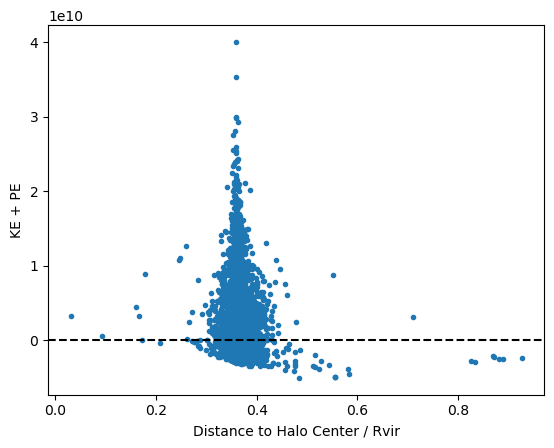

In [35]:
#sns.kdeplot(x = halo_star_r/(ray_halo_rvir*ds.units.code_length).to('m'), y = E_list, fill=True)
plt.plot(halo_star_r/(ray_halo_rvir*ds.units.code_length).to('m'), E_list, '.')
plt.axhline(0, linestyle='--', color='black')
plt.ylabel('KE + PE')
plt.xlabel('Distance to Halo Center / Rvir')

Only 30% of the stars are bound, which is unlikely. The error may come from the fact that the center of the stellar population is significantly off from the halo center, this introduces errors in the energy calculation. 

Suggestion from Kirk: subtract 

Use peak to determine the group of 

### Star Assignment Technique from AGORA Paper V and VII

Because SHINBAD output doesn't store the maximum circular velocity, we need to estimate it from the circular velocity at the virial radius

In [2]:
def weighted_std(values, weights_list):
    """
    Return the weighted standard deviation.

    values, weights -- NumPy ndarrays with the same shape.
    """
    average = np.average(values, weights=weights_list)
    N = len(values)
    # Fast and numerically precise:
    variance = np.sum(weights_list*(values-average)**2)/((N-1)*np.sum(weights_list)/N)
    return np.sqrt(variance)

In [3]:
def star_assignment(tree, branch, idx, pfs, sigma_cut = 2, distance_cut = 2):
    ds = yt.load(pfs[int(idx)])
    #
    branch = '0_4'
    halo_center = tree[branch][int(idx)]['Halo_Center']
    halo_rvir = tree[branch][int(idx)]['Halo_Radius']
    halo_mass = tree[branch][int(idx)]['Halo_Mass']
    halo_vel = tree[branch][int(idx)]['Vel_Com']
    halo_vel = (halo_vel*ds.units.code_length/ds.units.s).to('km/s').v
    #
    halo_rvir_si = ((halo_rvir*ds.units.code_length).to('m').v)*u.m
    halo_mass_si = ((halo_mass*ds.units.Msun).to('kg').v)*u.kg
    vcir = np.sqrt(G*halo_mass_si/halo_rvir_si).to('km/s').value #this is the circular velocity at r = Rvir
    #

In [17]:
idx = '194'
ray_pfs = np.loadtxt('/scratch/bbvl/gtg115x/new_zoom_5/box_2_z_1/pfs_allsnaps_1088.txt', dtype=str).tolist()
ds = yt.load(ray_pfs[int(idx)])

yt : [INFO     ] 2024-12-11 16:59:32,587 Parameters: current_time              = 19.408071964245
yt : [INFO     ] 2024-12-11 16:59:32,590 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2024-12-11 16:59:32,592 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2024-12-11 16:59:32,595 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2024-12-11 16:59:32,597 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2024-12-11 16:59:32,600 Parameters: current_redshift          = 11.215615860209
yt : [INFO     ] 2024-12-11 16:59:32,602 Parameters: omega_lambda              = 0.6935
yt : [INFO     ] 2024-12-11 16:59:32,604 Parameters: omega_matter              = 0.3065
yt : [INFO     ] 2024-12-11 16:59:32,607 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2024-12-11 16:59:32,607 Parameters: hubble_constant           = 0.679


In [5]:
ray_rawtree = np.load('/scratch/bbvl/gtg115x/new_zoom_5/box_2_z_1/halotree_1088_final.npy', allow_pickle=True).tolist()

In [18]:
branch = '0'
halo_center = ray_rawtree[branch][int(idx)]['Halo_Center']
halo_rvir = ray_rawtree[branch][int(idx)]['Halo_Radius']
halo_mass = ray_rawtree[branch][int(idx)]['Halo_Mass']
halo_vel = ray_rawtree[branch][int(idx)]['Vel_Com']
halo_vel = (halo_vel*ds.units.code_length/ds.units.s).to('km/s').v

halo_rvir_si = ((halo_rvir*ds.units.code_length).to('m').v)*u.m
halo_mass_si = ((halo_mass*ds.units.Msun).to('kg').v)*u.kg
vcir = np.sqrt(G*halo_mass_si/halo_rvir_si).to('km/s').value #this is the circular velocity at r = Rvir

In [19]:
ray_metadata = np.load('/work/hdd/bbvl/gtg115x/new_zoom_5/box_2_z_1/star_metadata/star_metadata_allbox_%s.npy' % idx, allow_pickle=True).tolist()
ray_pos_all = ray_metadata['pos']
ray_age_all = ray_metadata['age']
ray_mass_all = ray_metadata['mass']
ray_ID_all = np.array(np.load('/work/hdd/bbvl/gtg115x/new_zoom_5/box_2_z_1/star_metadata/star_ID_allbox_%s.npy' % idx, allow_pickle=True).tolist())
ray_vel_all = np.array(np.load('/work/hdd/bbvl/gtg115x/new_zoom_5/box_2_z_1/star_metadata/star_vel_allbox_%s.npy' % idx, allow_pickle=True).tolist()['vel'])

In [20]:
#Identify all the stars within the halo region
inreg_bool = np.linalg.norm(ray_pos_all - halo_center, axis=1) < halo_rvir
inreg_pos = ray_pos_all[inreg_bool]
inreg_r = np.linalg.norm(inreg_pos - halo_center, axis=1)
#
inreg_vel = ray_vel_all[inreg_bool]
inreg_relvel = inreg_vel - halo_vel
inreg_relvelmag = np.linalg.norm(inreg_relvel, axis=1)
#
inreg_ID = ray_ID_all[inreg_bool]
inreg_mass = ray_mass_all[inreg_bool]

In [21]:
sigma_cut = 2
distance_cut = 2

In [22]:
reduced_bool = np.logical_and(inreg_r < 0.8*halo_rvir, inreg_relvelmag < 4*vcir)
reduced_mass = inreg_mass[reduced_bool]
reduced_pos = inreg_pos[reduced_bool]
reduced_com = np.average(reduced_pos, weights=reduced_mass, axis=0)
#
reduced_vel = inreg_vel[reduced_bool]
reduced_relvel = reduced_vel - np.average(reduced_vel, weights=reduced_mass, axis=0)
reduced_relvelmag = np.linalg.norm(reduced_relvel, axis=1)
sigma_vel = weighted_std(reduced_relvelmag, weights_list=reduced_mass)
#
reduced_ID = inreg_ID[reduced_bool]

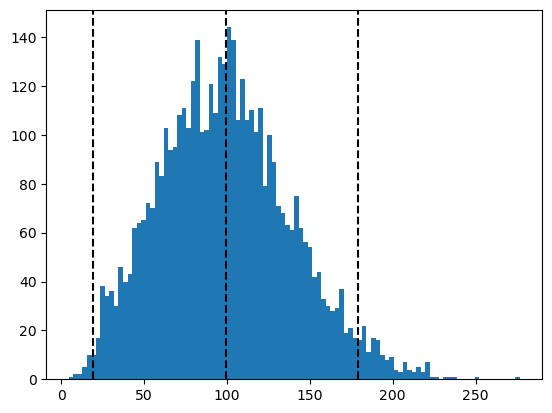

In [11]:
plt.hist(reduced_relvelmag, bins=100)
plt.axvline(np.average(reduced_relvelmag), color='k', linestyle='--')
plt.axvline(np.average(reduced_relvelmag) - sigma_cut*sigma_vel, color='k', linestyle='--')
plt.axvline(np.average(reduced_relvelmag) + sigma_cut*sigma_vel, color='k', linestyle='--')

In [23]:
def cal_R90(pos, center, mass):
    r = np.linalg.norm(pos - center, axis=1)
    r_sort = r[np.argsort(r)]
    mass_sort = mass[np.argsort(r)]
    mass_cumsum = np.cumsum(mass_sort)
    mass_cumsumpercent = mass_cumsum/mass_cumsum[-1]
    R90 = r_sort[np.where(mass_cumsumpercent > 0.9)[0][0]]
    return R90

In [24]:
r90_halocenter = cal_R90(reduced_pos, halo_center, reduced_mass)
r90_starcenter = cal_R90(reduced_pos, reduced_com, reduced_mass)

In [25]:
reduced2_bool = (np.linalg.norm(reduced_pos - halo_center, axis=1) < distance_cut*r90_halocenter) & \
                (np.linalg.norm(reduced_pos - reduced_com, axis=1) < distance_cut*r90_starcenter) & \
                (reduced_relvelmag <= np.average(reduced_relvelmag) + sigma_cut*sigma_vel)
reduced2_pos = reduced_pos[reduced2_bool]
reduced2_mass = reduced_mass[reduced2_bool]
reduced2_ID = reduced_ID[reduced2_bool]
reduced2_vel = reduced_vel[reduced2_bool]
reduced2_com = np.average(reduced2_pos, weights=reduced2_mass, axis=0)

In [26]:
counter = 0
while np.sum(reduced2_bool)/len(reduced2_bool) <= 0.99:
    if len(reduced2_pos) == 0:
        reduced2_com = np.nan
        break
    reduced2_relvel = reduced2_vel - np.average(reduced2_vel, weights=reduced2_mass, axis=0)
    reduced2_relvelmag = np.linalg.norm(reduced2_relvel, axis=1)
    #
    sigma_vel = weighted_std(reduced2_relvelmag, weights_list=reduced2_mass)
    r90_halocenter = cal_R90(reduced2_pos, halo_center, reduced2_mass)
    r90_starcenter = cal_R90(reduced2_pos, reduced2_com, reduced2_mass)
    #
    reduced2_bool = (np.linalg.norm(reduced2_pos - halo_center, axis=1) < distance_cut*r90_halocenter) & \
                    (np.linalg.norm(reduced2_pos - reduced2_com, axis=1) < distance_cut*r90_starcenter) & \
                    (reduced2_relvelmag <= np.average(reduced2_relvelmag) + sigma_cut*sigma_vel)
    reduced2_pos = reduced2_pos[reduced2_bool]
    reduced2_mass = reduced2_mass[reduced2_bool]
    reduced2_ID = reduced2_ID[reduced2_bool]
    reduced2_vel = reduced2_vel[reduced2_bool]
    reduced2_com = np.average(reduced2_pos, weights=reduced2_mass, axis=0)
    counter += 1
    print(counter)

1
2
3


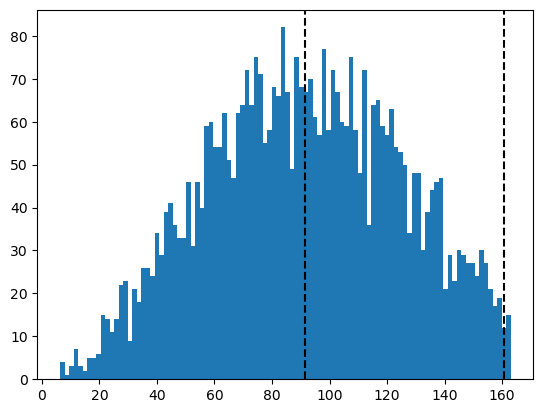

In [19]:
plt.hist(reduced2_relvelmag, bins=100)
plt.axvline(np.average(reduced2_relvelmag), color='k', linestyle='--')
plt.axvline(np.average(reduced2_relvelmag) + sigma_cut*sigma_vel, color='k', linestyle='--')

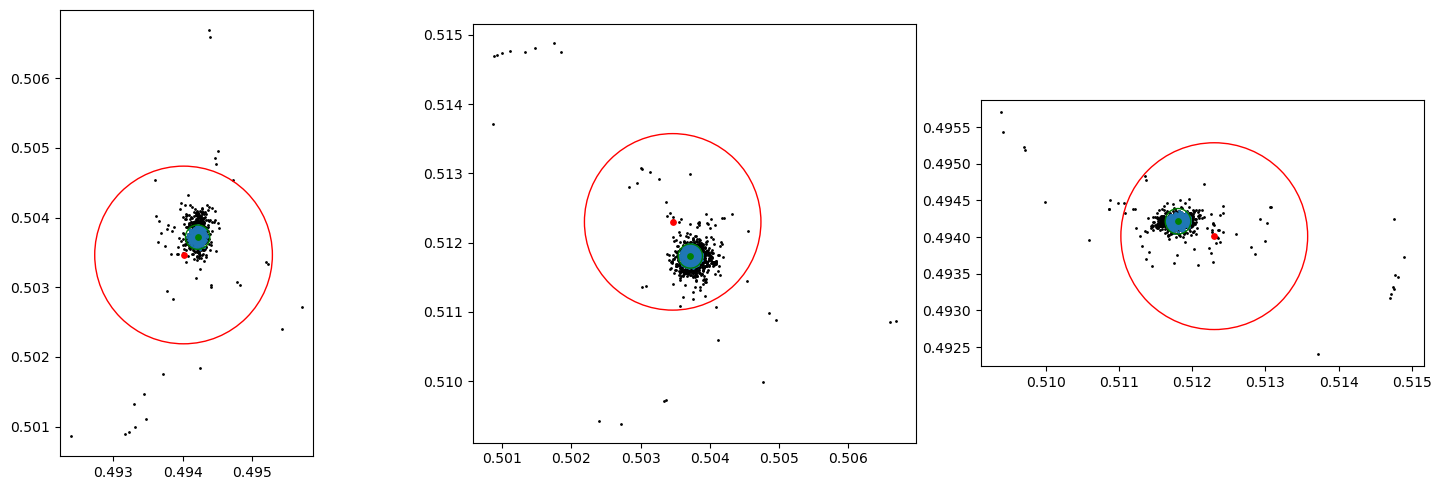

In [27]:
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(15,5))

axs[0].scatter(inreg_pos[:,0], inreg_pos[:,1], s=1, color='black')

axs[0].scatter(reduced2_pos[:,0], reduced2_pos[:,1], s=1)

axs[0].scatter(halo_center[0], halo_center[1], color='red', s=15)
circle1 = plt.Circle((halo_center[0], halo_center[1]), distance_cut*r90_halocenter, color='red', fill=False)
axs[0].add_patch(circle1)

axs[0].scatter(reduced2_com[0], reduced2_com[1], color='green', s=15)
circle2 = plt.Circle((reduced2_com[0], reduced2_com[1]), distance_cut*r90_starcenter, color='green', fill=False)
axs[0].add_patch(circle2)

axs[0].set_aspect('equal')

#---------------------------------------------------------
axs[1].scatter(inreg_pos[:,1], inreg_pos[:,2], s=1, color='black')

axs[1].scatter(reduced2_pos[:,1], reduced2_pos[:,2], s=1)

axs[1].scatter(halo_center[1], halo_center[2], color='red', s=15)
circle1 = plt.Circle((halo_center[1], halo_center[2]), distance_cut*r90_halocenter, color='red', fill=False)
axs[1].add_patch(circle1)

axs[1].scatter(reduced2_com[1], reduced2_com[2], color='green', s=15)
circle2 = plt.Circle((reduced2_com[1], reduced2_com[2]), distance_cut*r90_starcenter, color='green', fill=False)
axs[1].add_patch(circle2)

axs[1].set_aspect('equal')
#---------------------------------------------------------
axs[2].scatter(inreg_pos[:,2], inreg_pos[:,0], s=1, color='black')

axs[2].scatter(reduced2_pos[:,2], reduced2_pos[:,0], s=1)

axs[2].scatter(halo_center[2], halo_center[0], color='red', s=15)
circle1 = plt.Circle((halo_center[2], halo_center[0]), distance_cut*r90_halocenter, color='red', fill=False)
axs[2].add_patch(circle1)

axs[2].scatter(reduced2_com[2], reduced2_com[0], color='green', s=15)
circle2 = plt.Circle((reduced2_com[2], reduced2_com[0]), distance_cut*r90_starcenter, color='green', fill=False)
axs[2].add_patch(circle2)

axs[2].set_aspect('equal')

fig.tight_layout()